# Bias Transfer in Transfer Learning - Heart Disease Dataset

<p float="left">
  <img src="https://thedatafrog.com/static/blog/images/2019/10/dessin_transfer_learning_crop-1-1024x794.jpg" width="33%" />
  <img src="https://cdn.pixabay.com/photo/2023/10/05/19/21/ai-ethics-8296760_1280.jpg" width="38.35%" />
</p>


## <font color='#004812'>Table of contents<font><a class='anchor' id='top'></a>
- <a href="#intro">0. Introduction</a>
- <a href="#import">1. Import Libraries and Initial Data Exploration</a>
    - <a href="#helpers">1.1. Helper Functions</a> 
- <a href="#eda">2. Exploratory Data Analysis</a>
- <a href="#fsa">3. Feature Selection Analysis </a>
- <a href="#featureengineering">4. Feature Engineering </a>
- <a href="#modelanal">5. Model Analysis </a>
- <a href="#hyperparam">6. Hyperparameter Tuning </a>
- <a href="#fairness">7. Fairness </a>
- <a href="#transferanal">8. Transfer Analysis </a>
    - <a href="#individualtraining">8.1. Individual Analysis</a> 
    - <a href="#upstreamdownstream">8.2. Train Upstream, Test Downstream</a> 
    - <a href="#finetune">8.3. Finetune for Downstream</a> 
    - <a href="#oldfinetune">8.4. Previous Finetune Analysis: MLP layer retrain</a> 
- <a href="#biasmit">9. Bias Mitigation </a>
- <a href="#together">10. Putting it all together</a>
    - <a href="#search">10.1. GridSearch Transfer Performance with Bias</a> 
    - <a href="#tableexplore">10.2. Considering Rankings for each Category</a> 
    - <a href="#plotsend">10.3. Analysis and plotting of results</a> 

 <a id='intro'></a>

# 0. Introduction

Ok let me tell you about this project

Transfer learning is a common task, we have **foundation (upstream) models** that are trained once on a huge corpus of data by those with the means, that are repeatedly adapted by end-users via **finetuning** to get a good **downstream** model for their particular problem. This allows people to create quality models with often just a few examples **(few-shot learning)** for a variety of downstream tasks. 

Bias in AI is a widespread issue and is increasing in importance as models are deployed more widely. This bias can seep in at many stages of the pipeline, including subjective features, disparate application of results, but sometimes it is even due to statistical properties of inbalanced datasets. There have been several methods developed to try and aid against this natural discrimination that arises from nievely training with accuracy as the sole target. This problem is typically framed as certain columns (often 'sex', 'age', 'race') being declared **protected attributes**, and maximizing equality metrics is considered alongside gross accuracy metrics. 

This project is looking at the intersection of these broad topics. Inspired by the 2021 paper by Xisen Jin et al - On transferability of bias mitigation effects in language model fine-tuning. They discuss debiasing foundation models, and how bias transfers (or reappears) through the fine-tuning process. Previous work has focused more on debiasing the downstream models after taking biased foundation models, however in the future, we will want to create the next stage of foundation models in a debiased manner, saving us compute, and further removing bias that wouldn't be mitigated by downstream mitigation. 

The 2021 paper looks at a few datasets, uses adversarial bias mitigation, works in the context of LLMs, tries different finetuning techniques (weight-freezing and not), and trains on both distribution shifted and identical downstream datasets. We hope in this work to explore the grid of parameters for how bias and accuracy vary along these axis, as well as introduce some comparisons between upstream bias mitigation (UBM) and downstream bias mitigation (DBM), and try to understand some patterns underlying all of this. 

Paper is available here: https://www.dropbox.com/scl/fi/vbcss0piepzbo90b47me2/Public_DebiasedFoundationModels_Paper.pdf?rlkey=68fpawvqnrbss6xw6xqobic3o&dl=0

 <a id='import'></a>

# 1. Imports, Initial Cleaning

In [1]:
# Standard library imports
import os
import warnings

# Third-party imports for data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# Scikit-learn imports for machine learning
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_recall_curve, auc
)
from sklearn.model_selection import (
    train_test_split, cross_val_score, cross_validate, KFold, GridSearchCV
)
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.svm import SVC
from sklearn.exceptions import ConvergenceWarning

# Feature selection
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

# Ensemble models from third-party libraries
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


# still to be organized

### First understand the combined dataset

In [2]:
df = pd.read_csv('/kaggle/input/heart-disease-dataset/heart_statlog_cleveland_hungary_final.csv')

print(df.shape, '\n')
print(df.info()) # gives us nan analysis
df.head()

(1190, 12) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1190 non-null   int64  
 1   sex                  1190 non-null   int64  
 2   chest pain type      1190 non-null   int64  
 3   resting bp s         1190 non-null   int64  
 4   cholesterol          1190 non-null   int64  
 5   fasting blood sugar  1190 non-null   int64  
 6   resting ecg          1190 non-null   int64  
 7   max heart rate       1190 non-null   int64  
 8   exercise angina      1190 non-null   int64  
 9   oldpeak              1190 non-null   float64
 10  ST slope             1190 non-null   int64  
 11  target               1190 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 111.7 KB
None


age  sex  chest pain type  resting bp s  cholesterol  fasting blood sugar  \
0   40    1                2           140          289                    0   
1   49    0                3           160          180                    0   
2   37    1                2           130          283                    0   
3   48    0                4           138          214                    0   
4   54    1                3           150          195                    0   

   resting ecg  max heart rate  exercise angina  oldpeak  ST slope  target  
0            0             172                0      0.0         1       0  
1            0             156                0      1.0         2       1  
2            1              98                0      0.0         1       0  
3            0             108                1      1.5         2       1  
4            0             122                0      0.0         1       0

In [3]:
df.describe()

age          sex  chest pain type  resting bp s  cholesterol  \
count  1190.000000  1190.000000      1190.000000   1190.000000  1190.000000   
mean     53.720168     0.763866         3.232773    132.153782   210.363866   
std       9.358203     0.424884         0.935480     18.368823   101.420489   
min      28.000000     0.000000         1.000000      0.000000     0.000000   
25%      47.000000     1.000000         3.000000    120.000000   188.000000   
50%      54.000000     1.000000         4.000000    130.000000   229.000000   
75%      60.000000     1.000000         4.000000    140.000000   269.750000   
max      77.000000     1.000000         4.000000    200.000000   603.000000   

       fasting blood sugar  resting ecg  max heart rate  exercise angina  \
count          1190.000000  1190.000000     1190.000000      1190.000000   
mean              0.213445     0.698319      139.732773         0.387395   
std               0.409912     0.870359       25.517636         0.487360   
min               0.000000     0.000000       60.000000         0.000000   
25%               0.000000     0.000000      121.000000         0.000000   
50%               0.000000     0.000000      140.500000         0.000000   
75%               0.000000     2.000000      160.000000         1.000000   
max               1.000000     2.000000      202.000000         1.000000   

           oldpeak     ST slope       target  
count  1190.000000  1190.000000  1190.000000  
mean      0.922773     1.624370     0.528571  
std       1.086337     0.610459     0.499393  
min      -2.600000     0.000000     0.000000  
25%       0.000000     1.000000     0.000000  
50%       0.600000     2.000000     1.000000  
75%       1.600000     2.000000     1.000000  
max       6.200000     3.000000     1.000000

### Nothing looks crazy, but we need to check duplicates

This was noted in one of the discussions. It is quite strange, how there are so many duplicated values, and they seem to be scrambled a bit. They are not uniformly scrambled so it may not be intentional, although they are notably at the end so it is possible this was malicious. Either way, these must be removed otherwise you will get behavior that doesn't make sense. 

See below that they just copied values 617-1160 (but in a different order), but also duplicates between 90, 163, 556, 604 ... (perhaps these first two pairs are legitimate duplicates or some disconnected error. 

In [4]:
def duplicate_analysis(df, num_pairs=None):
    """
    Analyzes duplicates in the DataFrame and optionally prints specified number of duplicate pairs.
    
    Parameters:
        df (DataFrame): The DataFrame to analyze for duplicates.
        num_pairs (int, optional): The number of duplicate pairs to print. If None, prints all pairs.
    """
    # Step 1: Identify and count all duplicates
    duplicates_count = df.duplicated().sum()
    print(f"Number of Duplicates: {duplicates_count}\n")

    if duplicates_count == 0:
        return

    # Step 2: Extract all duplicates for pairing
    duplicates = df[df.duplicated(keep=False)]
    duplicates_sorted = duplicates.sort_values(by=list(df.columns))

    # Step 3: Group and pair duplicates
    duplicate_pairings = {}
    for index, row in duplicates_sorted.iterrows():
        row_tuple = tuple(row)
        if row_tuple not in duplicate_pairings:
            matched_indices = duplicates_sorted[duplicates_sorted == row].dropna().index.tolist()
            duplicate_pairings[row_tuple] = matched_indices

    # Prepare a list of unique pairings
    unique_pairings = []
    seen_indices = set()
    for indices in duplicate_pairings.values():
        for pair in zip(indices[:-1], indices[1:]):  # Create pairs from each group
            if pair not in seen_indices and tuple(reversed(pair)) not in seen_indices:
                unique_pairings.append(pair)
                seen_indices.update(pair)

    # Step 4: Sort pairings by the minimum index in each pair
    unique_pairings.sort(key=lambda x: min(x))

    # Display the pairings, limited by num_pairs if specified
    print(f"First {num_pairs} duplicate pairings ordered by the lowest index in each pair:")
    for i, pair in enumerate(unique_pairings):
        if num_pairs is not None and i >= num_pairs:
            break
        print(pair)
        
        
duplicate_analysis(df, num_pairs=15)

Number of Duplicates: 272

First 15 duplicate pairings ordered by the lowest index in each pair:
(90, 163)
(556, 604)
(617, 1042)
(618, 1039)
(619, 1146)
(620, 1139)
(621, 1120)
(622, 938)
(623, 899)
(624, 983)
(625, 1045)
(626, 1008)
(627, 920)
(628, 1058)
(629, 972)


### Now that we know how we need to process the datasets, create functions to streamline

The split dfs are produced via comparison of clevelend dataset with the combined dataset (which rows exist in both). The cleveland dataset has more columns, with slightly different names, although fortunately in the same order. There are other small things that I noticed while working that were added here, such as the removal of a row with ST slope = 0. 

First a quick look at the cleveland dataset, then straight into the functions

In [5]:
cledf = pd.read_csv('/kaggle/input/cleveland-clinic-heart-disease-dataset/processed_cleveland.csv')
print(cledf.shape, '\n')
print(cledf.info()) # gives us nan analysis
duplicate_analysis(cledf, num_pairs=15)
cledf.head()

(303, 14) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  num       303 non-null    int64  
dtypes: float64(1), int64(11), object(2)
memory usage: 33.3+ KB
None
Number of Duplicates: 0



age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

  ca thal  num  
0  0    6    0  
1  3    3    2  
2  2    7    1  
3  0    3    0  
4  0    3    0

In [6]:
def fetch_combined_df_cleaned():
    df = pd.read_csv('/kaggle/input/heart-disease-dataset/heart_statlog_cleveland_hungary_final.csv')
    
    # 1. duplicates
    df.drop_duplicates(inplace=True)
    linhas_duplicadas = df.duplicated()

    # 2. bad values, i.e. ST slope = 0 (only one of them, and in specs not supposed to occur)
    mask = df['ST slope'] == 0
    df = df[~mask]
    
    df.reset_index(drop=True, inplace=True)
    return df

# @return: df (other4 locations dataframe), cledf (cleveland dataframe)
def fetch_split_datasets_cleaned(): 
    df = fetch_combined_df_cleaned()
    cledf = pd.read_csv('/kaggle/input/cleveland-clinic-heart-disease-dataset/processed_cleveland.csv')
    
    # make column names the same for relevant ones (shared ones)
    dfcols = list(df.columns[:-1]) #excluding target
    cledfcols = list(cledf.columns[len(dfcols):])
    cledf.columns = dfcols + cledfcols
    
    print('shapes after preprocessing but before combination analysis')
    print("df:", df.shape)
    print("cledf:", cledf.shape, '\n\n')
    
    # Combine the data and drop duplicates based on specific columns
    combined = pd.concat([cledf[dfcols], df[dfcols]])
    unique_df = combined.drop_duplicates(keep=False)

    # Identify and extract the unique rows in df that are not in cledf
    unique_df = df.merge(unique_df, on=dfcols, how='right', indicator=True)
    unique_df = unique_df[unique_df['_merge'] == 'both'].drop('_merge', axis=1)

    # we can do the same thing to now get the original 
    combined = pd.concat([unique_df[dfcols], df[dfcols]])
    duplicate_df = combined.drop_duplicates(keep=False)
    duplicate_df = df.merge(duplicate_df, on=dfcols, how='right', indicator=True)
    duplicate_df = duplicate_df[duplicate_df['_merge'] == 'both'].drop('_merge', axis=1)

    # Update df to the unique DataFrame
    df = unique_df.reset_index(drop=True)
    cledf = duplicate_df.reset_index(drop=True)

    # Print updated shapes and display the first few rows of the new unique_df
    
    print('Updated shapes after combination analysis')
    print("df:", df.shape)
    print("cledf:", cledf.shape)
    return df, cledf

df, cledf = fetch_split_datasets_cleaned()

shapes after preprocessing but before combination analysis
df: (917, 12)
cledf: (303, 14) 


Updated shapes after combination analysis
df: (614, 12)
cledf: (303, 12)


 <a id='helpers'></a>

## Section 1.1: Helpers

Just random small helpers here that will be used throughout

In [7]:
# use a normalized scalar to fit another df
def scalar_fit(X_test, scaler):
    X_test_scaled = scaler.transform(X_test)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
    return X_test_scaled
    
# typically normalizing the train data
def normalize_Xtrain(X_train):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    
    return X_train_scaled, scaler

# this will only fail and produce the original numbers if there is only 1 class present
def get_sex_groups(X):
    mean = X['sex'].mean()
    groups = X['sex']
    groups = (groups <= mean)*-1 + (groups >= mean)*1 
    return groups.replace({-1: 'female', 1: 'male'})

# when we want to see for example how many male 1, male 0, female 1, female 0
# edit to make better visibility
def get_class_target_balance(df, feature1, feature2):
    print(df[[feature, 'target']].value_counts())
    print(cledf[[feature, 'target']].value_counts())

 <a id='eda'></a>

# Section 2: EDA 

Sections 2 - 7 can be done on any dataset you would like. The combined dataset, the clevelend one, or the upstream (other four). By default we will look at the whole dataset to compare results with others, although in theory maybe this is slightly improper to not really hold any test data out fully. 

In [8]:
# Select Dataset

# COMBINED
df = fetch_combined_df_cleaned()

# NON-CLEVELAND
#df = fetch_split_datasets_cleaned()[0]

# CLEVELAND
#df = fetch_split_datasets_cleaned()[1]

print(df.shape)
df.head()

(917, 12)


age  sex  chest pain type  resting bp s  cholesterol  fasting blood sugar  \
0   40    1                2           140          289                    0   
1   49    0                3           160          180                    0   
2   37    1                2           130          283                    0   
3   48    0                4           138          214                    0   
4   54    1                3           150          195                    0   

   resting ecg  max heart rate  exercise angina  oldpeak  ST slope  target  
0            0             172                0      0.0         1       0  
1            0             156                0      1.0         2       1  
2            1              98                0      0.0         1       0  
3            0             108                1      1.5         2       1  
4            0             122                0      0.0         1       0

In [9]:
df.describe()

age         sex  chest pain type  resting bp s  cholesterol  \
count  917.000000  917.000000       917.000000    917.000000   917.000000   
mean    53.495093    0.789531         3.251908    132.377317   198.803708   
std      9.425601    0.407864         0.931502     18.515114   109.443764   
min     28.000000    0.000000         1.000000      0.000000     0.000000   
25%     47.000000    1.000000         3.000000    120.000000   173.000000   
50%     54.000000    1.000000         4.000000    130.000000   223.000000   
75%     60.000000    1.000000         4.000000    140.000000   267.000000   
max     77.000000    1.000000         4.000000    200.000000   603.000000   

       fasting blood sugar  resting ecg  max heart rate  exercise angina  \
count           917.000000   917.000000      917.000000       917.000000   
mean              0.232279     0.604144      136.814613         0.404580   
std               0.422517     0.806161       25.473732         0.491078   
min               0.000000     0.000000       60.000000         0.000000   
25%               0.000000     0.000000      120.000000         0.000000   
50%               0.000000     0.000000      138.000000         0.000000   
75%               0.000000     1.000000      156.000000         1.000000   
max               1.000000     2.000000      202.000000         1.000000   

          oldpeak   ST slope      target  
count  917.000000  917.00000  917.000000  
mean     0.888332    1.63795    0.552890  
std      1.066749    0.60727    0.497466  
min     -2.600000    1.00000    0.000000  
25%      0.000000    1.00000    0.000000  
50%      0.600000    2.00000    1.000000  
75%      1.500000    2.00000    1.000000  
max      6.200000    3.00000    1.000000

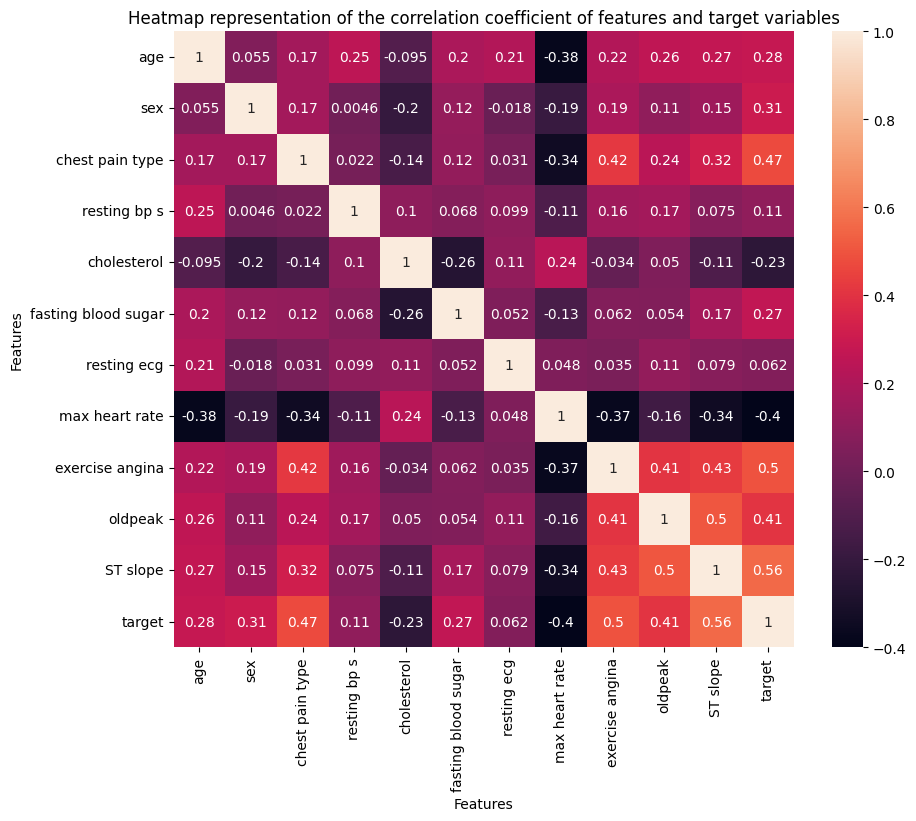

In [10]:
# Heat map of correlation of feattures and target variables
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True)
plt.xlabel('Features')
plt.ylabel('Features')
plt.title('Heatmap representation of the correlation coefficient of features and target variables')
plt.show()
#print(df.corr())

In [11]:
# separating feature and  target
rawX=df.drop('target',axis=1)
y = rawy=df['target']

X_scaled, scalar = normalize_Xtrain(rawX)
X_scaled.columns = rawX.columns
X_scaled.head()

age       sex  chest pain type  resting bp s  cholesterol  \
0 -1.432530  0.516309        -1.344701      0.411925     0.824583   
1 -0.477163 -1.936826        -0.270580      1.492713    -0.171905   
2 -1.750986  0.516309        -1.344701     -0.128469     0.769731   
3 -0.583315 -1.936826         0.803541      0.303846     0.138926   
4  0.053597  0.516309        -0.270580      0.952319    -0.034774   

   fasting blood sugar  resting ecg  max heart rate  exercise angina  \
0            -0.550052    -0.749818        1.381996        -0.824310   
1            -0.550052    -0.749818        0.753555        -0.824310   
2            -0.550052     0.491306       -1.524543        -0.824310   
3            -0.550052    -0.749818       -1.131767         1.213136   
4            -0.550052    -0.749818       -0.581882        -0.824310   

    oldpeak  ST slope  
0 -0.833201 -1.051095  
1  0.104738  0.596519  
2 -0.833201 -1.051095  
3  0.573708  0.596519  
4 -0.833201 -1.051095

In [12]:
print(y.shape)
y.head()

(917,)


0    0
1    1
2    0
3    1
4    0
Name: target, dtype: int64

Looking at distributions of combinations of features

   sex  target  count
0    0       0    143
1    0       1     50
2    1       0    267
3    1       1    457


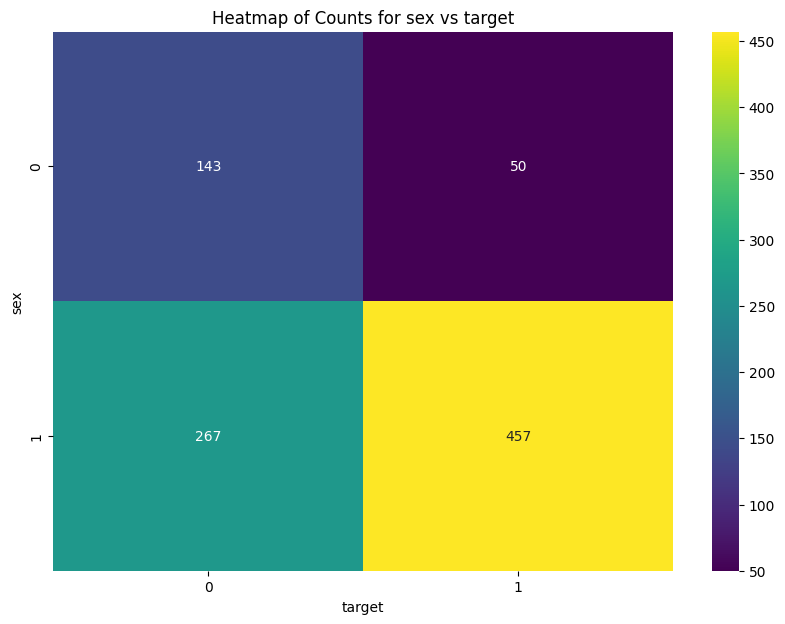

    sex        age  count
0     0    0 to 30      0
1     0   30 to 40     19
2     0   40 to 50     52
3     0   50 to 60     72
4     0   60 to 70     44
5     0   70 to 80      6
6     0  80 to inf      0
7     1    0 to 30      4
8     1   30 to 40     57
9     1   40 to 50    159
10    1   50 to 60    302
11    1   60 to 70    177
12    1   70 to 80     25
13    1  80 to inf      0


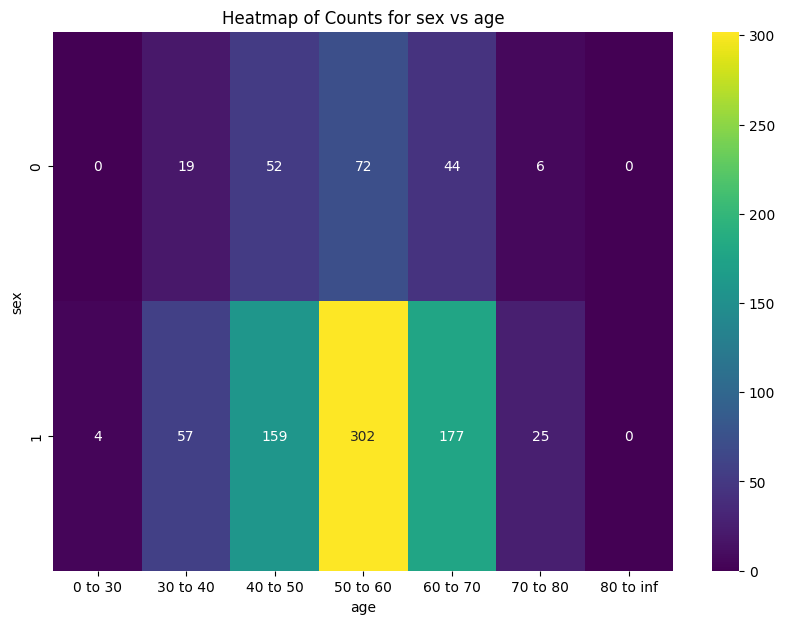

          age  target  count
0     0 to 30       0      4
1     0 to 30       1      0
2    30 to 40       0     50
3    30 to 40       1     26
4    40 to 50       0    126
5    40 to 50       1     85
6    50 to 60       0    162
7    50 to 60       1    212
8    60 to 70       0     59
9    60 to 70       1    162
10   70 to 80       0      9
11   70 to 80       1     22
12  80 to inf       0      0
13  80 to inf       1      0


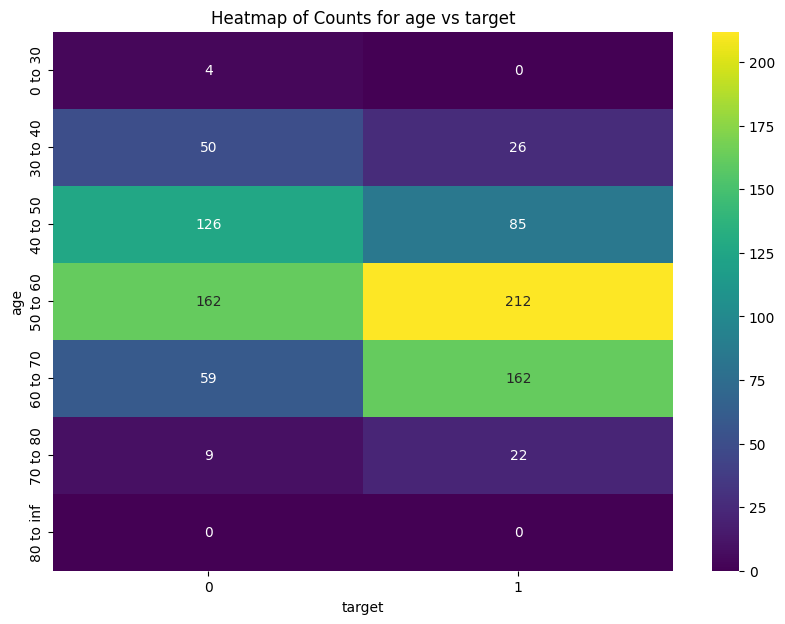

    sex        age  target  count
0     0   18 to 35       0      5
1     0   18 to 35       1      1
2     0   35 to 65       0    123
3     0   35 to 65       1     45
4     0  65 to inf       0     15
5     0  65 to inf       1      4
6     1   18 to 35       0     10
7     1   18 to 35       1      5
8     1   35 to 65       0    241
9     1   35 to 65       1    385
10    1  65 to inf       0     16
11    1  65 to inf       1     67


In [13]:
def display_counts(df, feature_names, bins=None):
    """
    Displays counts for combinations of features, where features can be categorical or binned continuous.
    Plots a heatmap if there are exactly two features.
    
    Args:
    df (pd.DataFrame): The DataFrame containing the features.
    feature_names (list): List of column names to analyze.
    bins (dict): Dictionary with feature names as keys and bin edges as values for continuous features.
    """
    if len(feature_names) < 1:
        print("Please provide at least one feature name.")
        return
    
    # Handle binning if necessary
    modified_df = df.copy()
    if bins:
        for feature, edges in bins.items():
            if feature in feature_names:
                modified_df[feature] = pd.cut(modified_df[feature], bins=edges, 
                                              labels=[f"{edges[i]} to {edges[i+1]}" for i in range(len(edges)-1)],
                                              include_lowest=True, right=False)
    
    # Create a groupby object based on the provided feature names
    group_data = modified_df.groupby(feature_names, observed=False).size().reset_index(name='count')
    print(group_data)
    
    # If there are exactly two features, plot a heatmap
    if len(feature_names) == 2:
        pivot_table = group_data.pivot_table(index=feature_names[0], columns=feature_names[1], values='count', fill_value=0, observed=False)
        plt.figure(figsize=(10, 7))
        sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap="viridis")
        plt.title(f'Heatmap of Counts for {feature_names[0]} vs {feature_names[1]}')
        plt.ylabel(f'{feature_names[0]}')
        plt.xlabel(f'{feature_names[1]}')
        plt.show()

        
        
display_counts(df, ['sex', 'target'])

bins = {'age': [0, 30, 40, 50, 60, 70, 80, np.inf]}
display_counts(df, ['sex', 'age'], bins=bins)
display_counts(df, ['age', 'target'], bins=bins)

bins = {'age': [18, 35, 65, np.inf]}
display_counts(df, ['sex', 'age', 'target'], bins=bins)

A few things to notice here. 

1. Gender vs Target (extreme inbalance)

Males: 458 Sick , 267 Healthy == 63.1%

Fems: 50 Sick , 143 Healthy == 25.9%

2. Age Distributions 
 
the studied individuals peak in the 50-60 range and are roughly symmetrical around this. They have the worst sickness rate in the 60-70 range, followed by 70-80 and 50-60. Others they are more likely to be healthy. 

3. 3d Analysis (Sex + Age + Target)

Males are more likely to be predicted as sick than healthy, at ages 35 and up. But in 18-35 they are more likely healthy. Females are always more likely healthy than sick. 



4. Overall: 

These differences can be due to true factors like men having higher prevelance of heart disease, or also due to other factors like followup rate, subjective diagnosis, and differential scanning, etc. 


 <a id='fsa'></a>

# Section 3: Feature Selection Analysis

models

In [14]:
def make_logistic_regression_classifier():
    return LogisticRegression(max_iter=1000)

def make_random_forest_classifier():
    return RandomForestClassifier(n_estimators=25)

def make_yoked_random_forest_classifier():
    return RandomForestClassifier(n_estimators=100)

def make_svm_classifier():
    return SVC(kernel='rbf', C=1.0, gamma='scale')

def make_svm_classifier_proba():
    return SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)

def make_xgboost_classifier():
    return XGBClassifier(use_label_encoder=False, eval_metric='logloss')

def make_yoked_xgboost_classifier():
    return XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        max_depth=6,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        learning_rate=0.01,
        n_estimators=600
    )

def make_catboost_classifier():
    return CatBoostClassifier(verbose=0)


def make_yoked_catboost_classifier():
    return CatBoostClassifier(
        iterations=1000,
        learning_rate=0.01,
        depth=6,
        l2_leaf_reg=3,
        bootstrap_type='Bayesian',
        loss_function='Logloss',
        verbose=0
    )

def make_50_mlp_classifier():
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    return MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, activation='relu', solver='adam', random_state=1)

def make_wide_mlp_classifier():
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    return MLPClassifier(hidden_layer_sizes=(100,), max_iter=100, activation='relu', solver='adam', random_state=1)

def make_deep_mlp_classifier():
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    return MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=100, activation='relu', solver='adam', random_state=1)

def make_boss_mlp_classifier():
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    return MLPClassifier(hidden_layer_sizes=(100, 50, 50), max_iter=300, activation='relu', solver='adam', random_state=1)


def make_scalar_logistic():
    return Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', LogisticRegression(C=.01, max_iter=1000))
        ])

def make_scaled_pipeline(make_model): 
    return lambda: Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', make_model())
    ])

Feature selection functions and plotting. Support for kfold CV or a single train/test split

In [15]:
# choosing features based on a logistic regression (bcz fast)
def logistic_sequential_feature_selection(X, y, max_features, num_folds = 5, max_iter = 5000):
    # get the feature list buildup using logistic regression
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    feature_lists = [[]]  # starts with the empty list for 0
    sfs1 = sfs(LogisticRegression(max_iter=max_iter), k_features=max_features, forward=True, scoring='accuracy', cv=num_folds, verbose=2)
    sfs1 = sfs1.fit(X, y)

    previous_features = set()
    # Gather selected features at each step
    for i in range(1, max_features + 1):
        current_features = set(sfs1.subsets_[i]['feature_names'])
        new_feature = current_features - previous_features
        previous_features = current_features.copy()

        feature_lists.append(list(current_features))
        print(f"Step {i}: New Feature Selected: {new_feature}")
    #feature_lists.extend([list(sfs1.subsets_[i]['feature_names']) for i in range(1, max_features+1)])
    
    return feature_lists


# handles k-fold or single fold (for speed)
def evaluate_feature_selection(Xs, names, y, model_types, max_features, num_folds=5, all_features=False, single_split=False, verbose=False):
    def make_model_name(i, make_model):
        return f'{i}. {make_model.__name__}'
    MAX_ITERATIONS_FEATURE_SEARCH = 5000
    
    
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42) if not single_split else None
    results = {make_model_name(i, model_func): {name: {'train_acc': [], 'test_acc': [], 'features': []} 
              for name in names} for (i, model_func) in enumerate(model_types)}
    best_overall_test_acc = 0

    
    for X, name in zip(Xs, names):
        if all_features:
            max_features = X.shape[1]  # all columns

        feature_lists = logistic_sequential_feature_selection(X, y, max_features, num_folds=num_folds)

        # Dummy model for baseline
        dummy_model = DummyClassifier(strategy='most_frequent')
        if single_split:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            dummy_model.fit(X_train, y_train)
            dummy_accuracy = accuracy_score(y_test, dummy_model.predict(X_test))
        else:
            dummy_accuracy = cross_val_score(dummy_model, X, y, cv=kf, scoring='accuracy').mean()

            
        for i, make_model in enumerate(model_types): # to differentiate same names
            model_name = make_model_name(i, make_model)
            model = make_model()
            if single_split:
                model.fit(X_train, y_train)
                baseline_accuracy = accuracy_score(y_test, model.predict(X_test))
                results[model_name][name]['train_acc'].append(baseline_accuracy)
                results[model_name][name]['test_acc'].append(baseline_accuracy)
            else:
                scores = cross_validate(model, X, y, cv=kf, scoring='accuracy', return_train_score=True)
                results[model_name][name]['train_acc'].append(np.mean(scores['train_score']))
                results[model_name][name]['test_acc'].append(np.mean(scores['test_score']))
            results[model_name][name]['features'].append(0)  # Zero indicates baseline (no feature selection)

                
            # Evaluate models with selected features
            for feat_idx in feature_lists[1:]:  # Skip the first empty list
                model = make_model()
                if single_split:
                    X_train_sfs = X_train.loc[:, feat_idx]
                    X_test_sfs = X_test.loc[:, feat_idx]
                    model.fit(X_train_sfs, y_train)
                    test_accuracy, train_accuracy = accuracy_score(y_test, model.predict(X_test_sfs)), accuracy_score(y_train, model.predict(X_train_sfs))
                else:
                    X_sfs = X.loc[:, feat_idx]
                    scores = cross_validate(model, X_sfs, y, cv=kf, scoring='accuracy', return_train_score=True)
                    test_accuracy, train_accuracy =  np.mean(scores['test_score']), np.mean(scores['train_score'])
                    if verbose:
                        train_scores, test_scores = scores['train_score'] , scores['test_score']
                        print(f'Train Scores: {train_scores} \n Test Scores: {test_scores}\n')
                    
                results[model_name][name]['train_acc'].append(train_accuracy)
                results[model_name][name]['test_acc'].append(test_accuracy)
                results[model_name][name]['features'].append(len(feat_idx))
                best_overall_test_acc = max(best_overall_test_acc, test_accuracy)

    return results, best_overall_test_acc, dummy_accuracy



# feature selection plotting
def plot_results(results, best_overall_test_acc = None, dummy_accuracy = None):
    print(f'Best Accuracy: {best_overall_test_acc}')
    for model_name, data_full in results.items():
        plt.figure(figsize=(10, 5))
        for xname, data in data_full.items():
            plt.plot(data['features'][1:], data['train_acc'][1:], marker='o', label=f'{xname} - Train Accuracy')
            plt.plot(data['features'][1:], data['test_acc'][1:], marker='x', label=f'{xname} - Test Accuracy')
            plt.axhline(y=data['test_acc'][0], color='r', linestyle='--', label=f'{xname} - Baseline Accuracy')
        if best_overall_test_acc:
            plt.axhline(y=best_overall_test_acc, color='g', linestyle='-', label='Best Accuracy Any Model')
        if dummy_accuracy:
            plt.axhline(y=dummy_accuracy, color='brown', linestyle='-', label='Dummy Model Accuracy')
        plt.title(f'Model Performance Comparison for {model_name}')
        plt.xlabel('Number of Features Selected')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()

Running Singular CV


[2024-05-19 22:53:54] Features: 1/11 -- score: 0.8133879781420765
[2024-05-19 22:53:54] Features: 2/11 -- score: 0.8144808743169399
[2024-05-19 22:53:55] Features: 3/11 -- score: 0.8210679496317415
[2024-05-19 22:53:55] Features: 4/11 -- score: 0.8330719885958662
[2024-05-19 22:53:55] Features: 5/11 -- score: 0.8385483487764315
[2024-05-19 22:53:55] Features: 6/11 -- score: 0.8396471846044191
[2024-05-19 22:53:55] Features: 7/11 -- score: 0.8374376336421954
[2024-05-19 22:53:55] Features: 8/11 -- score: 0.8352577809455928
[2024-05-19 22:53:55] Features: 9/11 -- score: 0.8254751722499407
[2024-05-19 22:53:56] Features: 10/11 -- score: 0.821103587550487
[2024-05-19 22:53:56] Features: 11/11 -- score: 0.8047814207650272

Step 1: New Feature Selected: {'ST slope'}
Step 2: New Feature Selected: {'oldpeak'}
Step 3: New Feature Selected: {'sex'}
Step 4: New Feature Selected: {'exercise angina'}
Step 5: New Feature Selected: {'chest pain type'}
Step 6: New Feature Selected: {'resting ecg'}
Step 7: New Feature Selected: {'fasting blood sugar'}
Step 8: New Feature Selected: {'resting bp s'}
Step 9: New Feature Selected: {'age'}
Step 10: New Feature Selected: {'max heart rate'}
Step 11: New Feature Selected: {'cholesterol'}
Best Accuracy: 0.8967391304347826


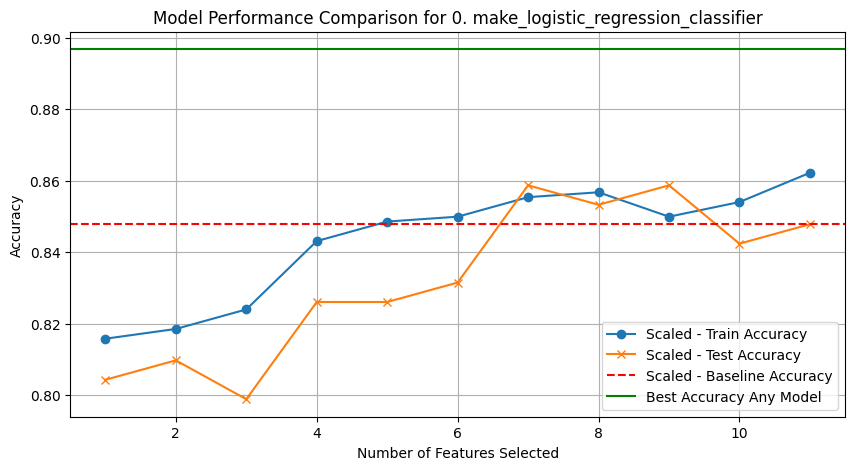

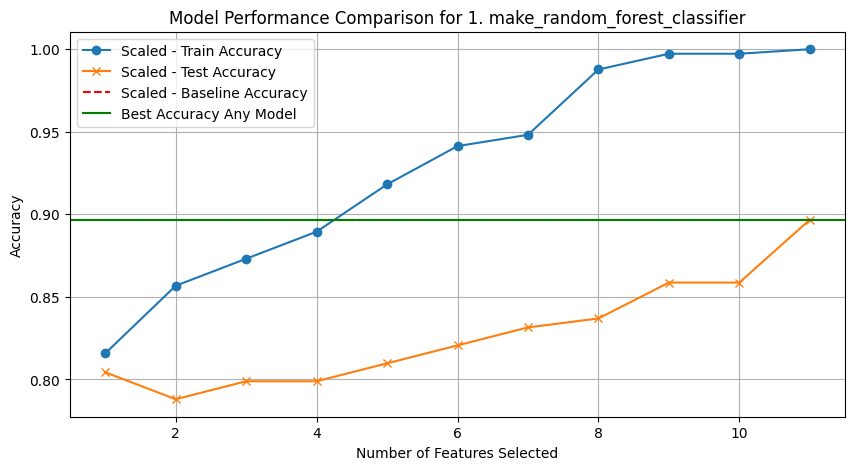

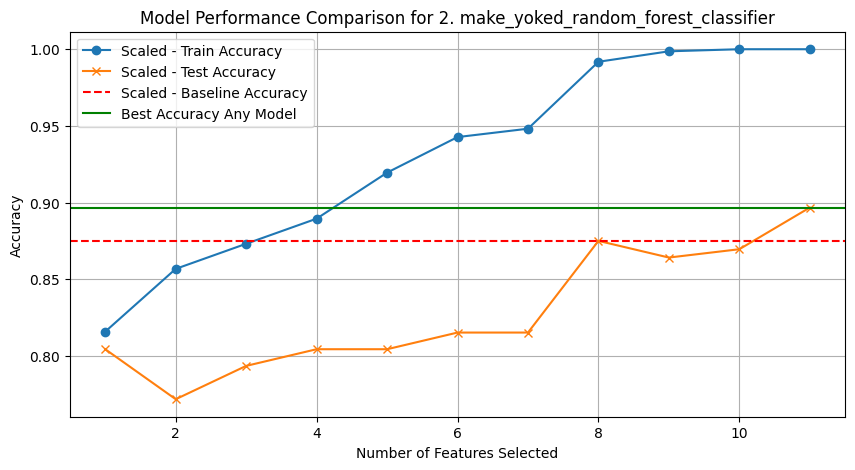

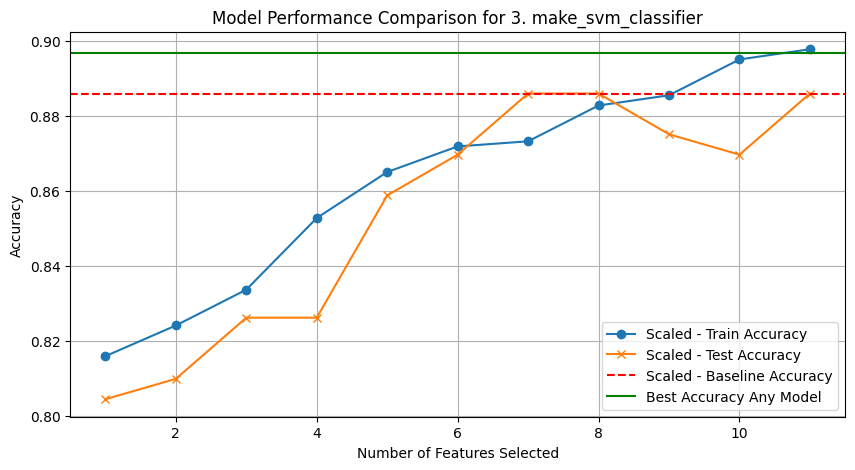

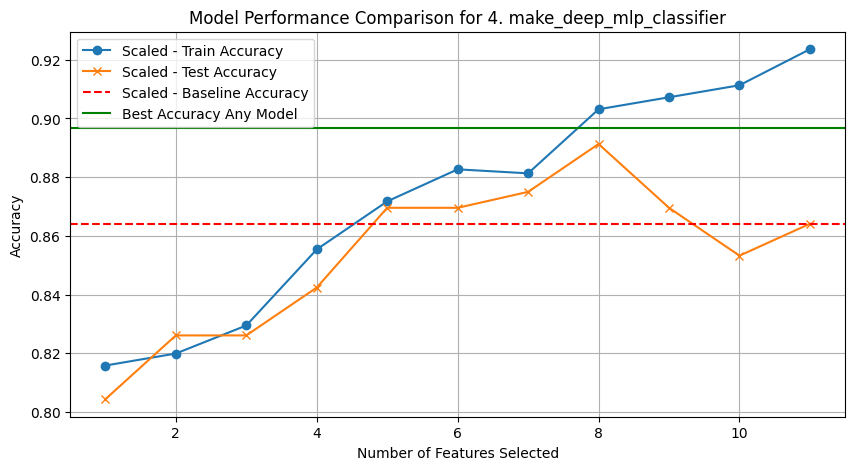

In [16]:
Xs = [rawX, X_scaled]  # Assume rawX and X_scaled are defined
Xs = [X_scaled]
names = ['Raw', 'Scaled']
names = ['Scaled'] # realizing that raw is p.much strictly worse
model_types = [make_logistic_regression_classifier, make_random_forest_classifier, make_yoked_random_forest_classifier, make_svm_classifier, make_deep_mlp_classifier]
max_features = 11

results, best_overall_test_acc, dummy_accuracy = evaluate_feature_selection(Xs, names, y, model_types, max_features, single_split=True)
plot_results(results, best_overall_test_acc = best_overall_test_acc)


Running K-Fold


[2024-05-19 22:54:13] Features: 1/11 -- score: 0.8133879781420765
[2024-05-19 22:54:13] Features: 2/11 -- score: 0.8166726063197908
[2024-05-19 22:54:14] Features: 3/11 -- score: 0.8221608458066049
[2024-05-19 22:54:14] Features: 4/11 -- score: 0.8341648847707294
[2024-05-19 22:54:15] Features: 5/11 -- score: 0.8363744357329533
[2024-05-19 22:54:15] Features: 6/11 -- score: 0.8385542884295557
[2024-05-19 22:54:16] Features: 7/11 -- score: 0.8363506771204563
[2024-05-19 22:54:16] Features: 8/11 -- score: 0.8341648847707296
[2024-05-19 22:54:17] Features: 9/11 -- score: 0.8276312663340463
[2024-05-19 22:54:18] Features: 10/11 -- score: 0.8221964837253504
[2024-05-19 22:54:19] Features: 11/11 -- score: 0.8069672131147542

Step 1: New Feature Selected: {'ST slope'}
Step 2: New Feature Selected: {'oldpeak'}
Step 3: New Feature Selected: {'sex'}
Step 4: New Feature Selected: {'exercise angina'}
Step 5: New Feature Selected: {'chest pain type'}
Step 6: New Feature Selected: {'resting ecg'}
Step 7: New Feature Selected: {'fasting blood sugar'}
Step 8: New Feature Selected: {'resting bp s'}
Step 9: New Feature Selected: {'max heart rate'}
Step 10: New Feature Selected: {'age'}
Step 11: New Feature Selected: {'cholesterol'}



[2024-05-19 22:54:42] Features: 1/11 -- score: 0.8133879781420765
[2024-05-19 22:54:43] Features: 2/11 -- score: 0.8144808743169399
[2024-05-19 22:54:43] Features: 3/11 -- score: 0.8210679496317415
[2024-05-19 22:54:43] Features: 4/11 -- score: 0.8330719885958662
[2024-05-19 22:54:43] Features: 5/11 -- score: 0.8385483487764315
[2024-05-19 22:54:43] Features: 6/11 -- score: 0.8396471846044191
[2024-05-19 22:54:44] Features: 7/11 -- score: 0.8374376336421954
[2024-05-19 22:54:44] Features: 8/11 -- score: 0.8352577809455928
[2024-05-19 22:54:44] Features: 9/11 -- score: 0.8254751722499407
[2024-05-19 22:54:44] Features: 10/11 -- score: 0.821103587550487
[2024-05-19 22:54:44] Features: 11/11 -- score: 0.8047814207650272

Step 1: New Feature Selected: {'ST slope'}
Step 2: New Feature Selected: {'oldpeak'}
Step 3: New Feature Selected: {'sex'}
Step 4: New Feature Selected: {'exercise angina'}
Step 5: New Feature Selected: {'chest pain type'}
Step 6: New Feature Selected: {'resting ecg'}
Step 7: New Feature Selected: {'fasting blood sugar'}
Step 8: New Feature Selected: {'resting bp s'}
Step 9: New Feature Selected: {'age'}
Step 10: New Feature Selected: {'max heart rate'}
Step 11: New Feature Selected: {'cholesterol'}
Best Accuracy: 0.8690722261819909


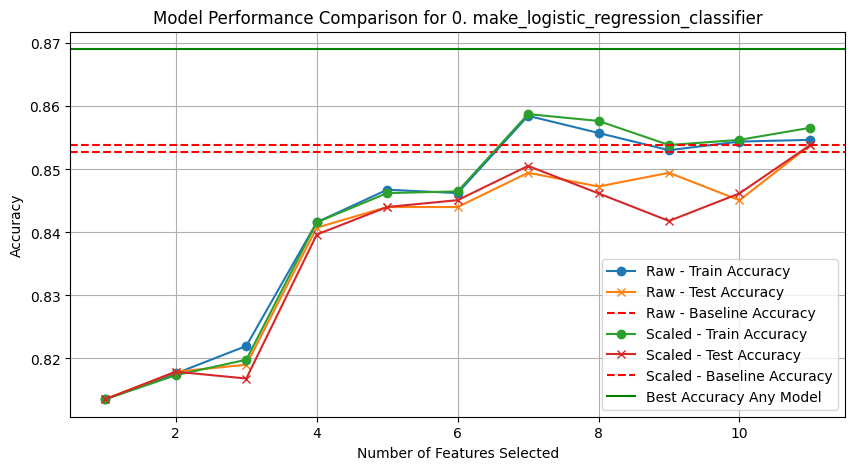

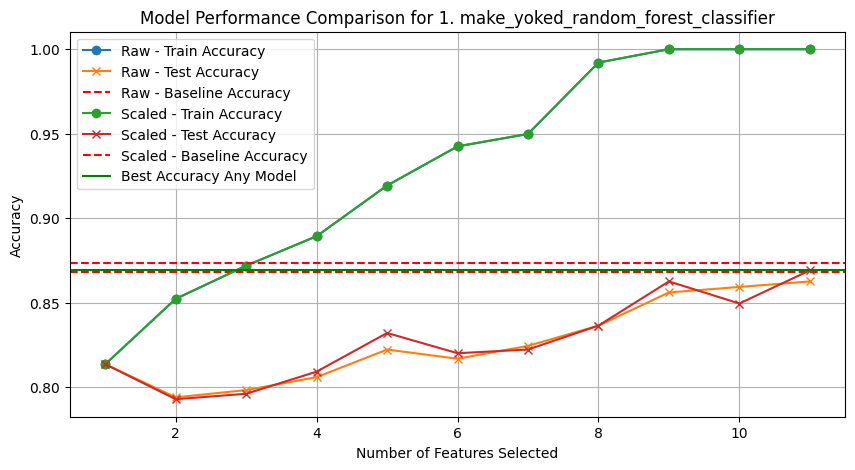

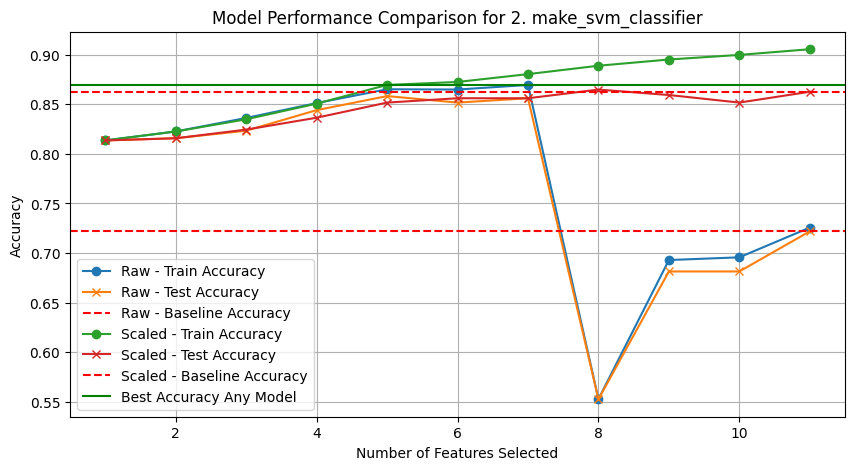

In [17]:
Xs = [rawX, X_scaled]  # Assume rawX and X_scaled are defined
names = ['Raw', 'Scaled']
model_types = [make_logistic_regression_classifier, make_yoked_random_forest_classifier, make_svm_classifier]
all_features = True

results, best_overall_test_acc, dummy_accuracy = evaluate_feature_selection(Xs, names, y, model_types, max_features, num_folds = 5, single_split=False) 
plot_results(results, best_overall_test_acc = best_overall_test_acc)


## thoughts


notice how on only the second or third feature select sex is already selected with logistic regression

also see that scaling doesn't matter for random forest but matters for logistic (someimtes) and svm

some without random seeds are not deterministic so see the baseline is not matching the second round training with all features

in cv version are we cheating by doing selection on the full data set

Trees, SVM, MLP all seem to perform about the same, beating out logistic regression

the trees seem to dub right now, svm and logistic getting crushed

Not sure we need to fine-tune the trees, default settings seem reasonable, but should fine tune MLP for sure and maybe SVM

MLP deep seems it could be good with careful training

Best accuracy around 0.89 for single fold (lucky split) and 0.87 for kfold

 <a id='featureengineering'></a>

# Section 4: Feature Engineering

The main thing here is to encode our nominal, binary, and continuous variables properly

Binary is naturally fine, nominal should be onehot, and continuous we could potentially consider binning approaches but for now we will not, we can let MLP or trees learn this

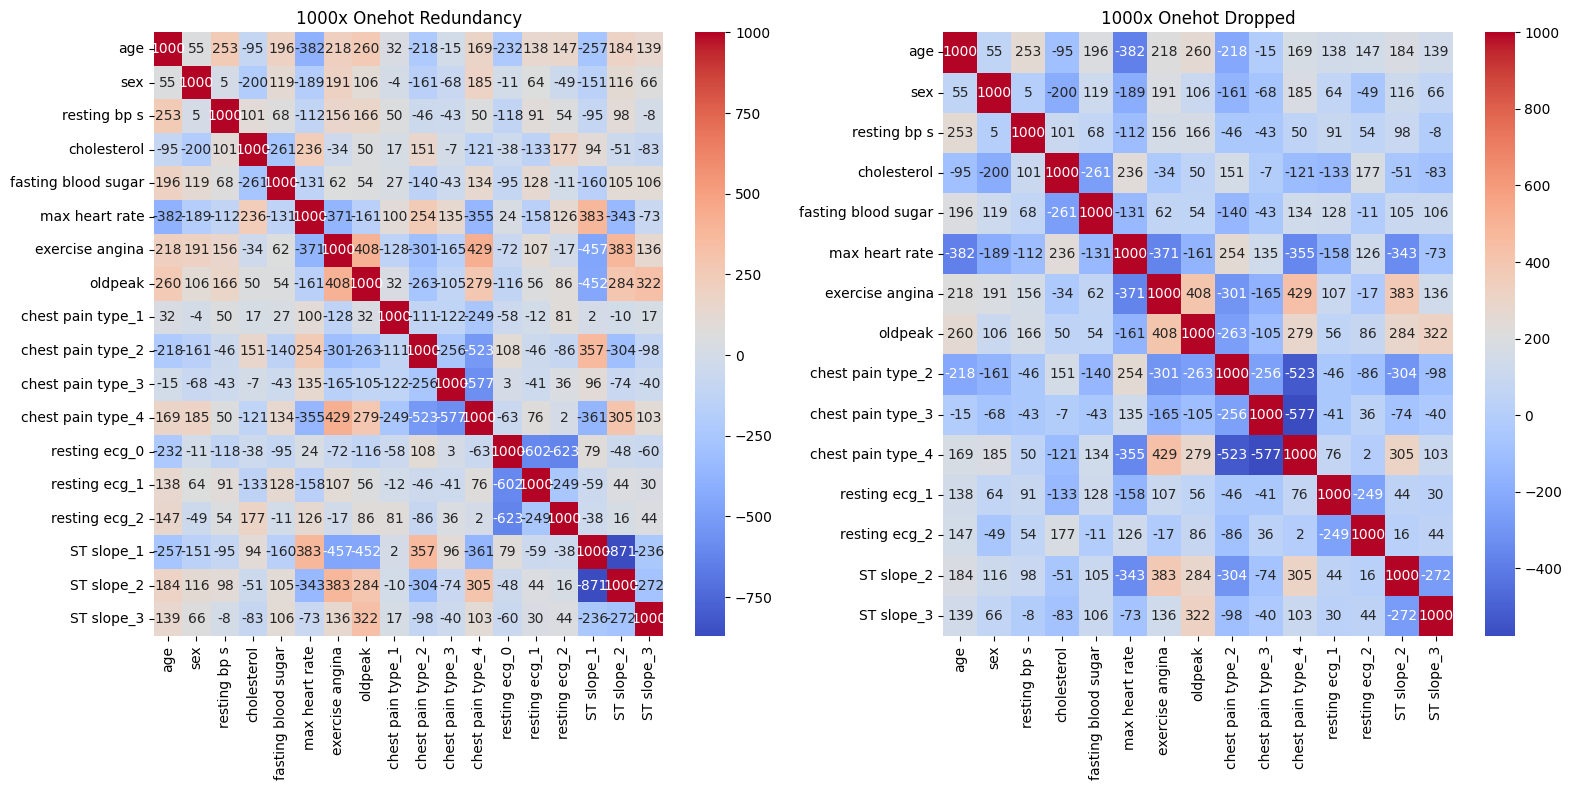

In [18]:
# Function to one-hot encode the nominal variables
def onehot_encode_nominals(X, nominal_columns, drop_first=False):
    encoder = OneHotEncoder(sparse_output=False, drop='first' if drop_first else None)
    X_nominal = encoder.fit_transform(X[nominal_columns])
    X_nominal = pd.DataFrame(X_nominal, columns=encoder.get_feature_names_out())
    X_numeric = X.drop(nominal_columns, axis=1)
    return pd.concat([X_numeric, X_nominal], axis=1)


# Plot correlation matrices
def plot_correlation_matrices(df_list, titles, fig_size=(8, 8), resolution = 100):
    titles = [f'{resolution}x {title}' for title in titles]
    n = len(df_list)
    n_cols = min(n, 3)
    n_rows = (n + n_cols - 1) // n_cols  # Round up division to get number of rows
    plt.figure(figsize=(n_cols * fig_size[0], n_rows * (fig_size[1])))  # Adjust height based on number of rows
    for i, df in enumerate(df_list):
        ax = plt.subplot(n_rows, n_cols, i + 1)
        corr = df.corr()
        sns.heatmap(resolution * corr, annot=True, fmt=".0f", cmap="coolwarm", 
                     xticklabels=df.columns, yticklabels=df.columns, ax=ax)
        ax.set_title(titles[i])
    plt.tight_layout()
    plt.show()

# Main data preparation and plotting
y = df['target']
X_pre = df.drop(['target'], axis=1)
nominal_columns = ['chest pain type', 'resting ecg', 'ST slope']

X_oh = onehot_encode_nominals(X_pre, nominal_columns, drop_first=False)
X_oh_drop = onehot_encode_nominals(X_pre, nominal_columns, drop_first=True) # eliminate redundancy

dfs = [X_oh, X_oh_drop]
titles = ['Onehot Redundancy', 'Onehot Dropped']

plot_correlation_matrices(dfs, titles, resolution = 1000)

We are reminded that the extra columns only affect themselves, but we can notice how the extra dof can be used rather than combining the others to result in potentially overfitting

Normalizing will not change the autocorrelation also

## now we scale and can run the feature selection analysis on both

lets consider the common error of scaling before the train/test split

## Scaling before splitting


[2024-05-19 22:55:10] Features: 1/18 -- score: 0.8133879781420765
[2024-05-19 22:55:11] Features: 2/18 -- score: 0.8133939177952009
[2024-05-19 22:55:11] Features: 3/18 -- score: 0.8199394155381325
[2024-05-19 22:55:11] Features: 4/18 -- score: 0.8330779282489903
[2024-05-19 22:55:12] Features: 5/18 -- score: 0.8450819672131147
[2024-05-19 22:55:12] Features: 6/18 -- score: 0.8472618199097173
[2024-05-19 22:55:13] Features: 7/18 -- score: 0.8472618199097173
[2024-05-19 22:55:13] Features: 8/18 -- score: 0.8450760275599905
[2024-05-19 22:55:13] Features: 9/18 -- score: 0.8418032786885247
[2024-05-19 22:55:13] Features: 10/18 -- score: 0.8440068899976241
[2024-05-19 22:55:14] Features: 11/18 -- score: 0.8440068899976241
[2024-05-19 22:55:14] Features: 12/18 -- score: 0.8440009503445
[2024-05-19 22:55:14] Features: 13/18 -- score: 0.8440009503445
[2024-05-19 22:55:15] Features: 14/18 -- score: 0.8429080541696365
[2024-05-19 22:55:15] Features: 15/18 -- score: 0.8385305298170586
[2024-05-

Step 1: New Feature Selected: {'ST slope_1'}
Step 2: New Feature Selected: {'oldpeak'}
Step 3: New Feature Selected: {'exercise angina'}
Step 4: New Feature Selected: {'sex'}
Step 5: New Feature Selected: {'fasting blood sugar'}
Step 6: New Feature Selected: {'ST slope_2'}
Step 7: New Feature Selected: {'ST slope_3'}
Step 8: New Feature Selected: {'resting ecg_2'}
Step 9: New Feature Selected: {'chest pain type_4'}
Step 10: New Feature Selected: {'age'}
Step 11: New Feature Selected: {'chest pain type_1'}
Step 12: New Feature Selected: {'chest pain type_2'}
Step 13: New Feature Selected: {'chest pain type_3'}
Step 14: New Feature Selected: {'resting bp s'}
Step 15: New Feature Selected: {'max heart rate'}
Step 16: New Feature Selected: {'resting ecg_0'}
Step 17: New Feature Selected: {'resting ecg_1'}
Step 18: New Feature Selected: {'cholesterol'}



[2024-05-19 22:55:49] Features: 1/15 -- score: 0.7752019482062248
[2024-05-19 22:55:49] Features: 2/15 -- score: 0.8199334758850083
[2024-05-19 22:55:50] Features: 3/15 -- score: 0.8396353052981705
[2024-05-19 22:55:50] Features: 4/15 -- score: 0.8407222618199098
[2024-05-19 22:55:50] Features: 5/15 -- score: 0.8450760275599905
[2024-05-19 22:55:51] Features: 6/15 -- score: 0.8483487764314563
[2024-05-19 22:55:51] Features: 7/15 -- score: 0.8516274649560465
[2024-05-19 22:55:51] Features: 8/15 -- score: 0.8483903540033262
[2024-05-19 22:55:51] Features: 9/15 -- score: 0.8451057258256117
[2024-05-19 22:55:52] Features: 10/15 -- score: 0.8461748633879781
[2024-05-19 22:55:52] Features: 11/15 -- score: 0.8429139938227607
[2024-05-19 22:55:52] Features: 12/15 -- score: 0.8429080541696365
[2024-05-19 22:55:52] Features: 13/15 -- score: 0.8385305298170586
[2024-05-19 22:55:52] Features: 14/15 -- score: 0.834158945117605
[2024-05-19 22:55:52] Features: 15/15 -- score: 0.8287419814682823

Step 1: New Feature Selected: {'ST slope_2'}
Step 2: New Feature Selected: {'exercise angina'}
Step 3: New Feature Selected: {'sex'}
Step 4: New Feature Selected: {'chest pain type_3'}
Step 5: New Feature Selected: {'chest pain type_2'}
Step 6: New Feature Selected: {'ST slope_3'}
Step 7: New Feature Selected: {'chest pain type_4'}
Step 8: New Feature Selected: {'oldpeak'}
Step 9: New Feature Selected: {'resting ecg_2'}
Step 10: New Feature Selected: {'age'}
Step 11: New Feature Selected: {'fasting blood sugar'}
Step 12: New Feature Selected: {'resting bp s'}
Step 13: New Feature Selected: {'max heart rate'}
Step 14: New Feature Selected: {'resting ecg_1'}
Step 15: New Feature Selected: {'cholesterol'}
Best Accuracy: 0.866904252791637


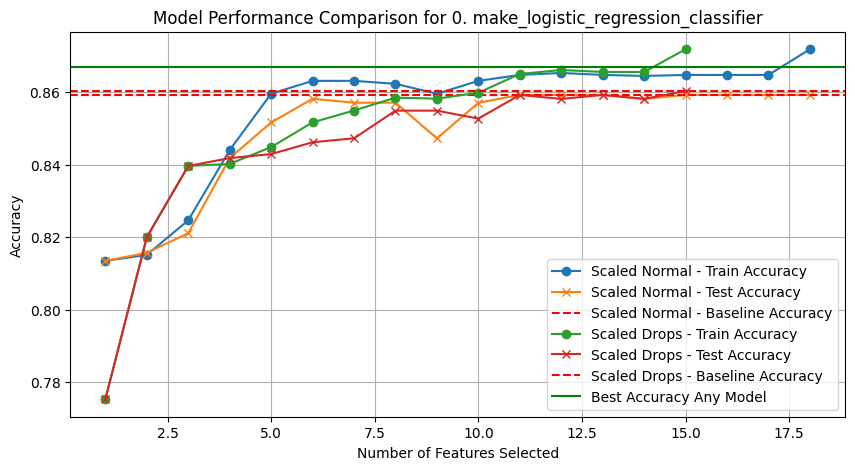

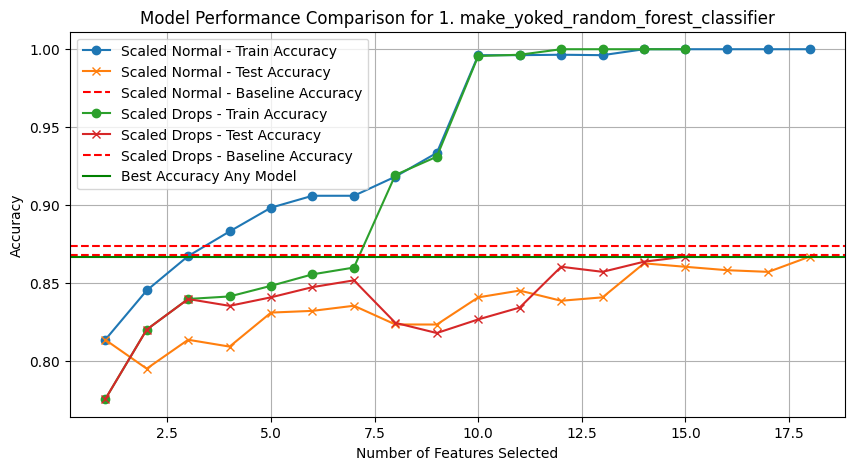

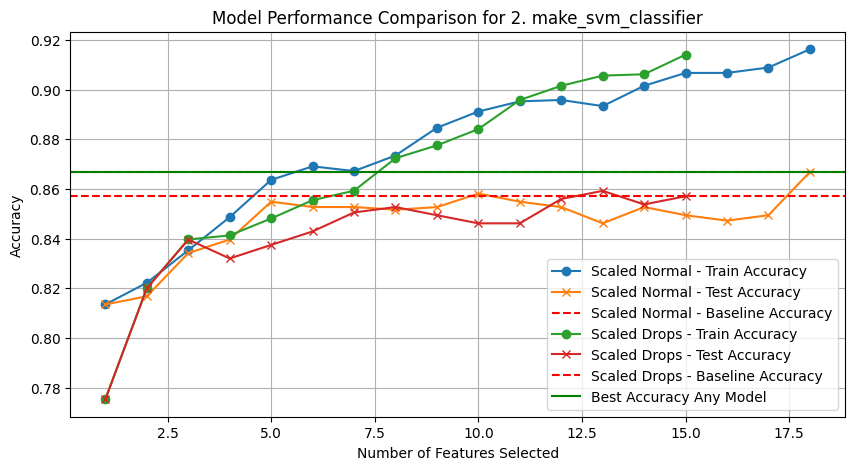

In [19]:
X_oh_scaled, _ = normalize_Xtrain(X_oh)
X_oh_drop_scaled, _ = normalize_Xtrain(X_oh_drop)
#Xs = [X_oh, X_oh_scaled, X_oh_drop, X_oh_drop_scaled]  # Assume rawX and X_scaled are defined
#names = ['Nominal OneHots', 'Scaled Normal', 'Dropped Onehots', 'Scaled Drops']
Xs = [X_oh_scaled, X_oh_drop_scaled]  # Assume rawX and X_scaled are defined
names = ['Scaled Normal', 'Scaled Drops']
model_types = [make_logistic_regression_classifier, make_yoked_random_forest_classifier, make_svm_classifier]#, make_deep_mlp_classifier]
max_features = 4
all_features = True

results, best_overall_test_acc, dummy_accuracy =  evaluate_feature_selection(Xs, names, y, model_types, max_features, all_features = all_features, num_folds = 5, single_split=False) 
plot_results(results, best_overall_test_acc = best_overall_test_acc)


## Scaling after splitting and with a pipeline model instead


[2024-05-19 22:56:22] Features: 1/18 -- score: 0.8133879781420765
[2024-05-19 22:56:22] Features: 2/18 -- score: 0.8144808743169399
[2024-05-19 22:56:23] Features: 3/18 -- score: 0.815591589451176
[2024-05-19 22:56:24] Features: 4/18 -- score: 0.823224043715847
[2024-05-19 22:56:25] Features: 5/18 -- score: 0.8330779282489903
[2024-05-19 22:56:27] Features: 6/18 -- score: 0.840704442860537
[2024-05-19 22:56:28] Features: 7/18 -- score: 0.843983131385127
[2024-05-19 22:56:30] Features: 8/18 -- score: 0.8450819672131148
[2024-05-19 22:56:32] Features: 9/18 -- score: 0.8472677595628415
[2024-05-19 22:56:34] Features: 10/18 -- score: 0.8472618199097173
[2024-05-19 22:56:36] Features: 11/18 -- score: 0.8505405084343074
[2024-05-19 22:56:38] Features: 12/18 -- score: 0.8483547160845806
[2024-05-19 22:56:45] Features: 13/18 -- score: 0.8429080541696365
[2024-05-19 22:56:51] Features: 14/18 -- score: 0.840728201473034
[2024-05-19 22:56:56] Features: 15/18 -- score: 0.8385305298170586
[2024-05

Step 1: New Feature Selected: {'ST slope_1'}
Step 2: New Feature Selected: {'age'}
Step 3: New Feature Selected: {'chest pain type_2'}
Step 4: New Feature Selected: {'exercise angina'}
Step 5: New Feature Selected: {'chest pain type_3'}
Step 6: New Feature Selected: {'sex'}
Step 7: New Feature Selected: {'ST slope_2'}
Step 8: New Feature Selected: {'chest pain type_1'}
Step 9: New Feature Selected: {'ST slope_3'}
Step 10: New Feature Selected: {'oldpeak'}
Step 11: New Feature Selected: {'resting ecg_2'}
Step 12: New Feature Selected: {'resting bp s'}
Step 13: New Feature Selected: {'chest pain type_4'}
Step 14: New Feature Selected: {'fasting blood sugar'}
Step 15: New Feature Selected: {'max heart rate'}
Step 16: New Feature Selected: {'resting ecg_0'}
Step 17: New Feature Selected: {'resting ecg_1'}
Step 18: New Feature Selected: {'cholesterol'}



[2024-05-19 22:57:43] Features: 1/15 -- score: 0.7752019482062248
[2024-05-19 22:57:43] Features: 2/15 -- score: 0.8199334758850083
[2024-05-19 22:57:44] Features: 3/15 -- score: 0.8396353052981705
[2024-05-19 22:57:45] Features: 4/15 -- score: 0.8407222618199098
[2024-05-19 22:57:45] Features: 5/15 -- score: 0.8450760275599905
[2024-05-19 22:57:46] Features: 6/15 -- score: 0.8483487764314563
[2024-05-19 22:57:46] Features: 7/15 -- score: 0.8472558802565932
[2024-05-19 22:57:47] Features: 8/15 -- score: 0.8461629840817295
[2024-05-19 22:57:48] Features: 9/15 -- score: 0.846198622000475
[2024-05-19 22:57:49] Features: 10/15 -- score: 0.8439890710382514
[2024-05-19 22:57:50] Features: 11/15 -- score: 0.8450641482537419
[2024-05-19 22:57:52] Features: 12/15 -- score: 0.8450819672131148
[2024-05-19 22:57:55] Features: 13/15 -- score: 0.839623425991922
[2024-05-19 22:57:59] Features: 14/15 -- score: 0.8374376336421951
[2024-05-19 22:58:01] Features: 15/15 -- score: 0.8298289379900213

Step 1: New Feature Selected: {'ST slope_2'}
Step 2: New Feature Selected: {'exercise angina'}
Step 3: New Feature Selected: {'sex'}
Step 4: New Feature Selected: {'chest pain type_3'}
Step 5: New Feature Selected: {'chest pain type_2'}
Step 6: New Feature Selected: {'ST slope_3'}
Step 7: New Feature Selected: {'resting ecg_2'}
Step 8: New Feature Selected: {'chest pain type_4'}
Step 9: New Feature Selected: {'oldpeak'}
Step 10: New Feature Selected: {'fasting blood sugar'}
Step 11: New Feature Selected: {'max heart rate'}
Step 12: New Feature Selected: {'resting bp s'}
Step 13: New Feature Selected: {'age'}
Step 14: New Feature Selected: {'resting ecg_1'}
Step 15: New Feature Selected: {'cholesterol'}
Best Accuracy: 0.8723568543597053


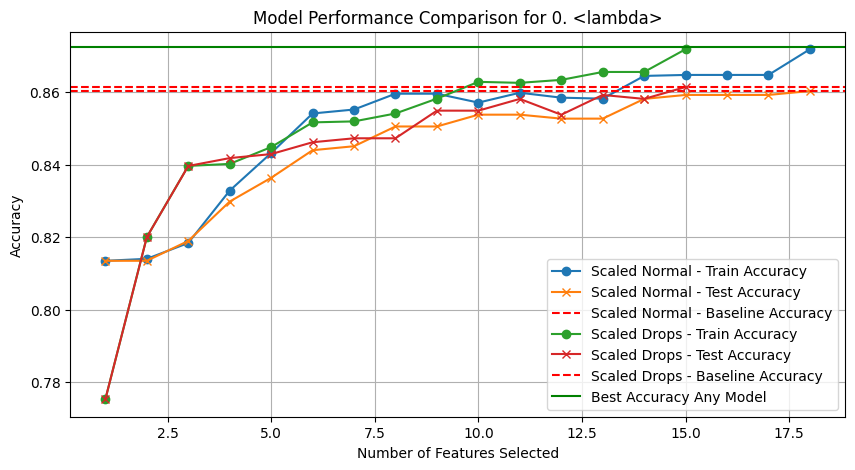

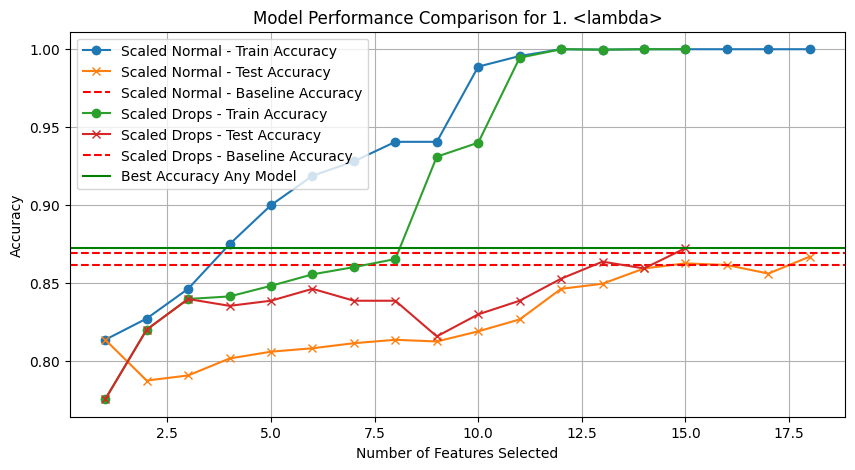

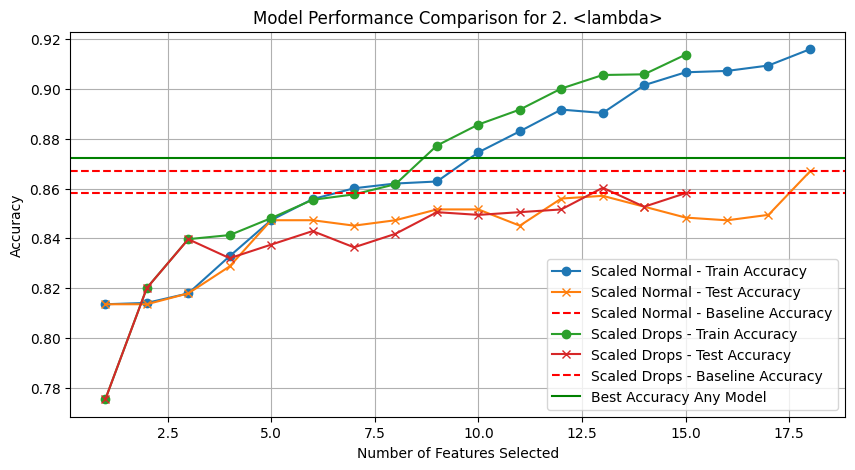

In [20]:
X_oh_scaled, _ = normalize_Xtrain(X_oh)
X_oh_drop_scaled, _ = normalize_Xtrain(X_oh_drop)
Xs = [X_oh, X_oh_drop]  
names = ['Scaled Normal', 'Scaled Drops']
model_types = [make_scaled_pipeline(make_model) for make_model in [make_logistic_regression_classifier, make_yoked_random_forest_classifier, make_svm_classifier]]#, make_deep_mlp_classifier]]
#model_types = [make_logistic_regression_classifier, make_yoked_random_forest_classifier, make_svm_classifier]
max_features = 4
all_features = True

#results, best_overall_test_acc, dummy_accuracy = evaluate_feature_selection_kfold(Xs, names, y, model_types, max_features, all_features = all_features)#, verbose = True)
results, best_overall_test_acc, dummy_accuracy = evaluate_feature_selection(Xs, names, y, model_types, max_features, num_folds=5, all_features = all_features, single_split=False, verbose=False)
plot_results(results, best_overall_test_acc = best_overall_test_acc)

notes: 
- it can't figure out what is the best to take in the case of the unscaled, prob some equivalency and just bouncing
- RF seems still to be best
- If we plot with verbose for the kfold, we see things like 0.81 - 0.88 for test scores, so highly dependent and need to use kfold
- 0.870 vs 0.872, so only a slight (possibly insignificant) difference when normalizing beforehand

 <a id='modelanal'></a>

# Section 5: Model Analysis

lets look at RF (best model), and logistic (simplest model)

In [21]:
# train RF 

X_oh_scaled, _ = normalize_Xtrain(X_oh)
X_oh_drop_scaled, _ = normalize_Xtrain(X_oh_drop)
        
X_train, X_test, y_train, y_test = train_test_split(X_oh_scaled, y, test_size=0.2, random_state=42)
model = make_yoked_random_forest_classifier()
model = make_logistic_regression_classifier()
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [22]:
# Predictions
y_pred = model.predict(X_test)

# Classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87        74
           1       0.93      0.88      0.91       110

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184



AUC-PR: 0.9422749422303276


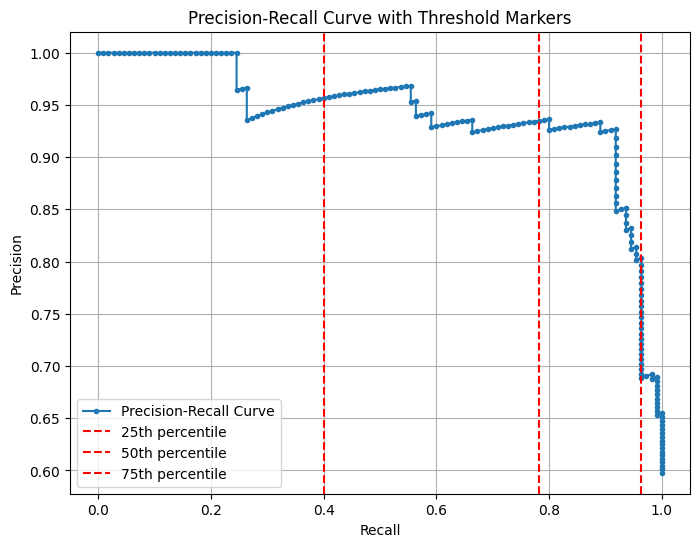

In [23]:
# Get probabilities for the positive class
y_scores = model.predict_proba(X_test)[:, 1]  # Assuming it's a binary classification and you're interested in the positive class

# Assuming y_true and y_scores are your true labels and predicted scores respectively
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Compute area under the curve
auc_score = auc(recall, precision)
print("AUC-PR:", auc_score)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')

# Find the thresholds at 25%, 50%, and 75% percentiles
percentiles = [25, 50, 75]
recall_percentiles = [np.percentile(recall, p) for p in percentiles]

# Plot vertical lines at the specified recall values
for recall_percentile in recall_percentiles:
    plt.axvline(x=recall_percentile, color='r', linestyle='--', label=f'{percentiles[np.where(recall_percentiles == recall_percentile)[0][0]]}th percentile')


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with Threshold Markers')
plt.legend()
plt.grid(True)
plt.show()


AUC-PR: 0.9425813317117666


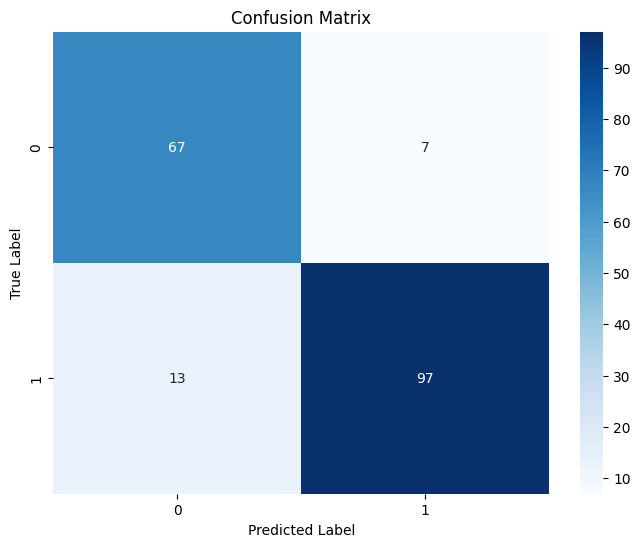

In [24]:
# Assuming y_true and y_scores are your true labels and predicted scores respectively
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# Compute area under the curve
auc_score = auc(recall, precision)
print("AUC-PR:", auc_score)


# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


 <a id='hyperparam'></a>

# Section 6: Hyperparameter Tuning

Only quick runthrough for now, to show that they don't matter so much for our analysis

- random forest num_trees
- logistic regularizer
- MLP network sizes

In [25]:
def hyperparam_plot(make_model, param_range, param_name, model_name, X, y, cv = 5, num_runs = 5, plot_categorical = False):
    results = []
    errors = []
    
    for param in param_range:
        run_scores = []
        for _ in range(num_runs):
            model = make_model(param)
            scores = cross_val_score(model, X, y, cv=cv)
            run_scores.append(np.mean(scores))
        results.append(np.mean(run_scores))
        errors.append(np.std(run_scores))

    # Convert lists to numpy arrays for better handling
    results = np.array(results)
    errors = np.array(errors)
    
    
    
    # plotting
    
    if plot_categorical:
        min_acc = results.min() - errors.max()
        max_acc = results.max() + errors.max()
        range_padding = (max_acc - min_acc) * 0.1  # 10% padding on each side
        y_min = max(0, min_acc - range_padding)  # Lower bound cannot be less than 0
        y_max = min(1, max_acc + range_padding)  # Upper bound cannot exceed 1
        
        plt.bar([str(p) for p in param_range], results, color='b', yerr=errors, capsize=5)
        plt.xlabel(param_name)
        plt.ylabel('Accuracy')
        plt.title(f'Effect of {param_name} on {model_name} Performance')
        plt.xticks(rotation=45)
        plt.ylim([y_min, y_max])
    else:
        plt.errorbar(param_range, results, yerr=errors, fmt='o-', color='b', capsize=5)
        plt.xlabel(param_name)
        plt.ylabel('Accuracy')
        plt.title(f'Effect of {param_name} on {model_name} Performance')
        plt.grid(True)
    
    plt.show()

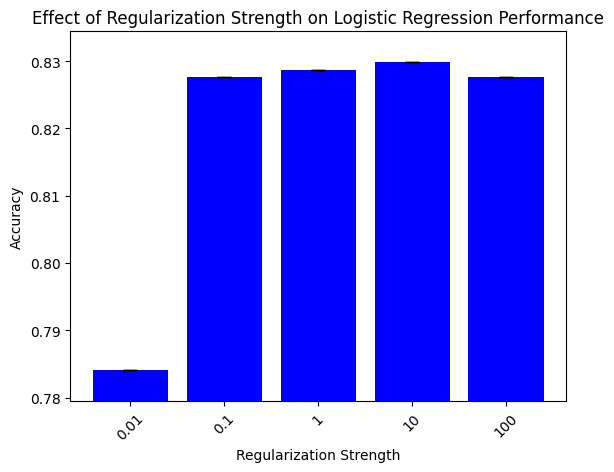

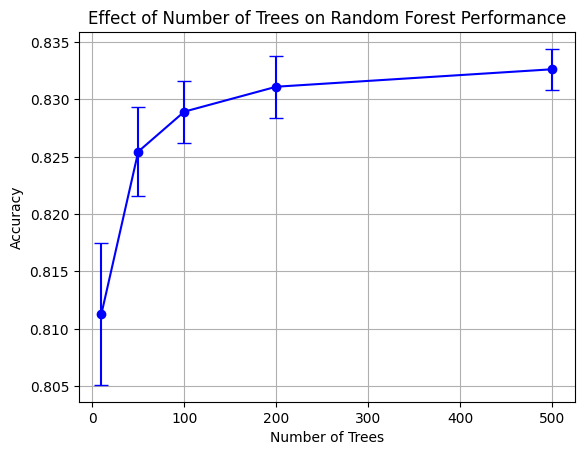

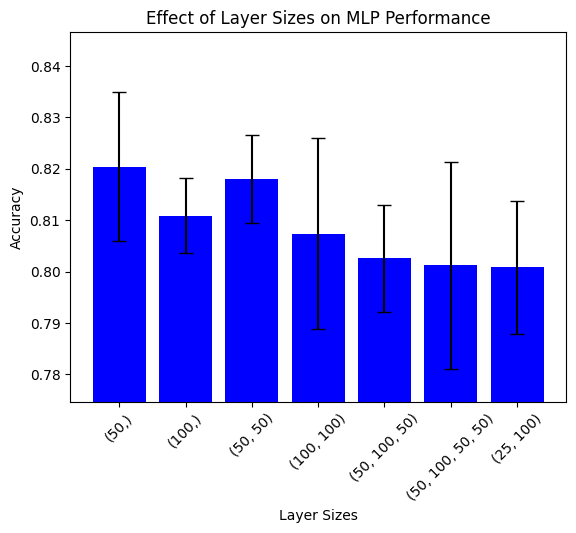

In [26]:
NUM_RUNS = 5

# logistic regression
make_lr = lambda x: LogisticRegression(C=x, max_iter=1000)
C_values = [0.01, 0.1, 1, 10, 100]
hyperparam_plot(make_lr, C_values, 'Regularization Strength', "Logistic Regression", X_oh, y, cv = 5, num_runs = NUM_RUNS, plot_categorical = True)


# random forest
make_rf = lambda x: RandomForestClassifier(n_estimators=x)
trees_range = [10, 50, 100, 200, 500]
hyperparam_plot(make_rf, trees_range, 'Number of Trees', "Random Forest", X_oh, y, cv = 5, num_runs = NUM_RUNS)

    
# MLP
make_mlp = lambda x: MLPClassifier(hidden_layer_sizes=x, max_iter=2000)
layer_sizes = [(50,), (100,), (50, 50), (100, 100), (50, 100, 50), (50, 100, 50, 50), (25, 100)]
hyperparam_plot(make_mlp, layer_sizes, 'Layer Sizes', "MLP", X_oh, y, cv = 5, num_runs = NUM_RUNS, plot_categorical = True)


In [27]:
# good svm parameters? 

# Assuming X and y are your data and labels
"""
pipeline = make_pipeline(StandardScaler(), SVC(kernel='rbf'))
param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': [0.001, 0.01, 0.1, 'scale']
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

"""

'\npipeline = make_pipeline(StandardScaler(), SVC(kernel=\'rbf\'))\nparam_grid = {\n    \'svc__C\': [0.1, 1, 10],\n    \'svc__gamma\': [0.001, 0.01, 0.1, \'scale\']\n}\ngrid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=\'accuracy\')\ngrid_search.fit(X, y)\n\nprint("Best parameters:", grid_search.best_params_)\nprint("Best cross-validation score: {:.2f}".format(grid_search.best_score_))\n\n'

And we see that a small regularization is sufficient to really help out the logistic regression, the default C is 1.0 which is good according to these plots

We were using 100 estimators but it seems here that we could get an even better gain out of 200

We see we made the network too big so below we look at some more MLP parameters

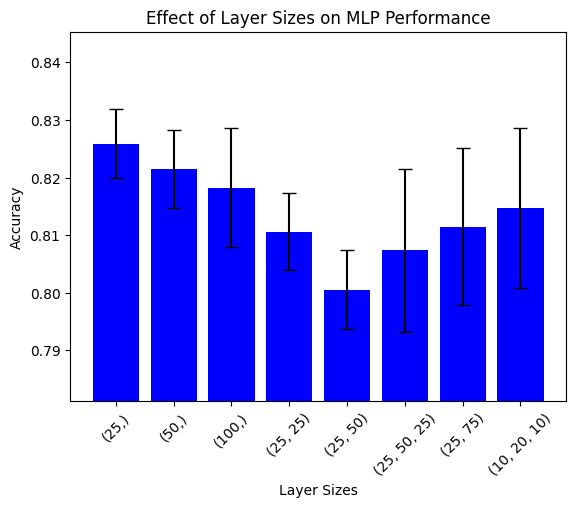

In [28]:
NUM_RUNS = 5
# MLP
make_mlp = lambda x: MLPClassifier(hidden_layer_sizes=x, max_iter=2000)
layer_sizes = [(25,), (50,), (100,), (25, 25), (25, 50), (25, 50, 25), (25, 75), (10, 20, 10)]
hyperparam_plot(make_mlp, layer_sizes, 'Layer Sizes', "MLP", X_oh, y, cv = 5, num_runs = NUM_RUNS, plot_categorical = True)

and a few more since it seems this is a good region

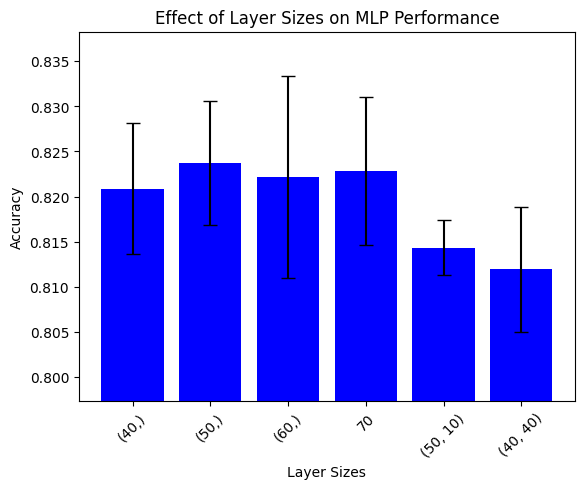

In [29]:
# MLP
make_mlp = lambda x: MLPClassifier(hidden_layer_sizes=x, max_iter=2000)
layer_sizes = [(40,), (50,), (60,), (70), (50, 10), (40, 40)]
hyperparam_plot(make_mlp, layer_sizes, 'Layer Sizes', "MLP", X_oh, y, cv = 5, num_runs = NUM_RUNS, plot_categorical = True)

and also we did that without the scaling pipeline, let's see how we do with for logistic and MLP (RF shouldn't matter)

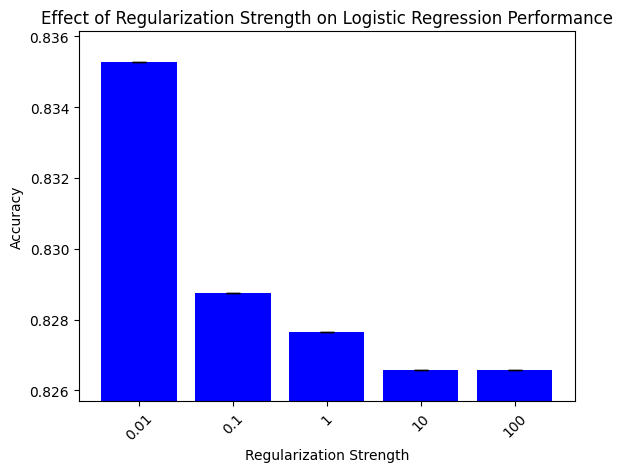

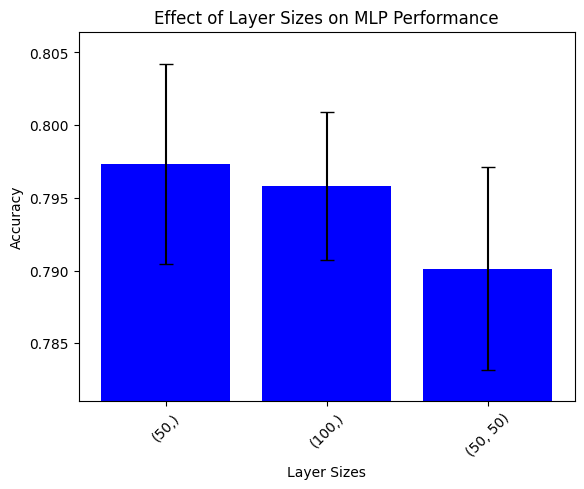

In [30]:
NUM_RUNS = 5

# logistic regression
make_lr = lambda x: Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(C=x, max_iter=1000))
    ])
C_values = [0.01, 0.1, 1, 10, 100]
hyperparam_plot(make_lr, C_values, 'Regularization Strength', "Logistic Regression", X_oh, y, cv = 5, num_runs = NUM_RUNS, plot_categorical = True)

    
# MLP
make_mlp = lambda x: Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', MLPClassifier(hidden_layer_sizes=x, max_iter=2000))
    ])
layer_sizes = [(50,), (100,), (50, 50)]
hyperparam_plot(make_mlp, layer_sizes, 'Layer Sizes', "MLP", X_oh, y, cv = 5, num_runs = NUM_RUNS, plot_categorical = True)


 <a id='fairness'></a>

how interesting, there is now almost no effect (see scale of axis) from the regularizer, if anything negative effect. So really what was important was to scale the LR

For the MLP, the scaling actually seemed to hurt us here. not too significantly. Need more tests probably. 

# Section 7: Fairness

725 male vs 193 female should give us some good stuff to work with

In [31]:
# what are the metrics , how do we compute 
# so we need to take in a sensitive feature (lets look at sex but also age binning
# and then we can get the true false positive negatives from all of these 

def calculate_confusion_components(y_test, y_scores, threshold=0.5):
    # Convert probabilities to binary predictions based on the threshold
    y_pred = (y_scores >= threshold).astype(int)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Make sure to return all four components even if some are missing
    tn, fp, fn, tp = 0, 0, 0, 0  # Default values if not otherwise set
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    elif cm.shape == (1, 1):
        if np.unique(y_test).item() == 0 and np.unique(y_pred).item() == 0:
            tn = cm.item()
        else:
            tp = cm.item()
    
    return tp, tn, fp, fn


def predictive_parity(y_test, y_scores, groups):
    # Ensure indices are aligned properly
    y_test = y_test.reset_index(drop=True)
    y_scores = pd.Series(y_scores).reset_index(drop=True)
    groups = groups.reset_index(drop=True)

    # Calculate PPV for each group
    ppvs = {}
    for group in groups.unique():
        group_mask = (groups == group)
        tp_g, tn_g, fp_g, fn_g = calculate_confusion_components(y_test[group_mask], y_scores[group_mask])
        ppv_g = tp_g / (tp_g + fp_g) if (tp_g + fp_g) > 0 else 0
        ppvs[group] = ppv_g

    return ppvs


def equalized_odds(y_test, y_scores, groups):
    # Reset indices to ensure alignment
    y_test = y_test.reset_index(drop=True)
    y_scores = pd.Series(y_scores).reset_index(drop=True)
    groups = groups.reset_index(drop=True)

    fprs = {}
    fnrs = {}
    for group in groups.unique():
        group_mask = (groups == group)
        tp_g, tn_g, fp_g, fn_g = calculate_confusion_components(y_test[group_mask], y_scores[group_mask])
        fpr_g = fp_g / (fp_g + tn_g) if (fp_g + tn_g) > 0 else 0
        fnr_g = fn_g / (fn_g + tp_g) if (fn_g + tp_g) > 0 else 0
        fprs[group] = fpr_g
        fnrs[group] = fnr_g

    return fprs, fnrs

def accuracy_equality(y_test, y_scores, groups, threshold=0.5):
    # Reset indices to ensure alignment
    y_test = y_test.reset_index(drop=True)
    y_scores = pd.Series(y_scores).reset_index(drop=True)
    groups = groups.reset_index(drop=True)

    accuracies = {}
    for group in groups.unique():
        group_mask = (groups == group)
        tp_g, tn_g, fp_g, fn_g = calculate_confusion_components(y_test[group_mask], y_scores[group_mask], threshold)
        total_correct_g = tp_g + tn_g
        total_g = tp_g + tn_g + fp_g + fn_g
        accuracy_g = total_correct_g / total_g if total_g > 0 else 0
        accuracies[group] = accuracy_g

    return accuracies

def calculate_and_plot_confusion_matrices(y_test, y_scores, groups, threshold=0.5):
    y_test = y_test.reset_index(drop=True)
    y_scores = pd.Series(y_scores).reset_index(drop=True)
    groups = groups.reset_index(drop=True)
    
    
    unique_groups = groups.unique()
    n_groups = len(unique_groups)
    fig, axes = plt.subplots(1, n_groups, figsize=(5 * n_groups, 4), sharey=True)
    if n_groups == 1:
        axes = [axes]

    for ax, group in zip(axes, unique_groups):
        group_mask = (groups == group)
        y_test_group = y_test[group_mask]
        y_scores_group = y_scores[group_mask]
        y_pred_group = (y_scores_group >= threshold).astype(int)
        cm = confusion_matrix(y_test_group, y_pred_group)
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False, ax=ax)
        ax.set_title(f'Confusion Matrix: Group {group}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

In [32]:
def parity_bar_graphs(y_test, y_scores, groups):
    # Calculate fairness metrics
    ppvs = predictive_parity(y_test, y_scores, groups)
    fprs, fnrs = equalized_odds(y_test, y_scores, groups)
    acceq = accuracy_equality(y_test, y_scores, groups)

    # Prepare data for plotting
    metrics = {
        'PPV': ppvs,
        'Accuracy': acceq,
        'FPR': fprs,
        'FNR': fnrs
    }

    # Determine the number of groups and create a bar width based on that
    group_labels = list(ppvs.keys())  # Example group labels: ['male', 'female']
    n_groups = len(group_labels)
    n_metrics = len(metrics)
    bar_width = 0.1
    index = np.arange(n_metrics)
    
    
    # Get the colormap and select colors
    cmap = mpl.colormaps['tab10']  # Corrected to use the new colormap access method
    colors = [cmap(i / n_groups) for i in range(n_groups)]


    # Create a single figure
    plt.figure(figsize=(10, 6))

    for i, (group, color) in enumerate(zip(group_labels, colors)):
        # Gather values for each metric for this group
        values = [metrics[metric_name].get(group, 0) for metric_name in metrics]
        plt.bar(index + i * bar_width, values, bar_width, label=group, color=color)

    # Add some additional features to the plot
    plt.xlabel('Fairness Metrics', fontsize=14)
    plt.ylabel('Values', fontsize=14)
    plt.title('Fairness Metrics Across Groups', fontsize=16)
    plt.xticks(index + bar_width * (n_groups - 1) / 2, list(metrics.keys()))
    plt.legend(title='Group', title_fontsize='13', fontsize='11')
    plt.tight_layout()

    plt.show()

In [33]:
# after we have the functions for these we can evaluate them on our random forest model, and see if we have any biases 

def fairness_report(y_test, y_scores, groups, rounding=3):

    # Calculate fairness metrics
    ppvs = predictive_parity(y_test, y_scores, groups)
    fprs, fnrs = equalized_odds(y_test, y_scores, groups)
    acceq = accuracy_equality(y_test, y_scores, groups)
    
    titles = ["Predictive Parity", "Accuracy Equality", "Equalized Odds - FPRs", "Equalized Odds - FNRs"]
    values = [ppvs, acceq, fprs, fnrs]
    
    for title, dic in zip(titles, values):
        output = { (k,round(v, rounding)) for (k,v) in dic.items()}
        print(f'{title}: {output}')
        
    # graphing parity
    parity_bar_graphs(y_test, y_scores, groups)

    # Plot
    confusion_matrices = calculate_and_plot_confusion_matrices(y_test, y_scores, groups)

TEST 


Predictive Parity: {('male', 0.947), ('female', 0.778)}
Accuracy Equality: {('female', 0.824), ('male', 0.907)}
Equalized Odds - FPRs: {('female', 0.087), ('male', 0.098)}
Equalized Odds - FNRs: {('male', 0.091), ('female', 0.364)}


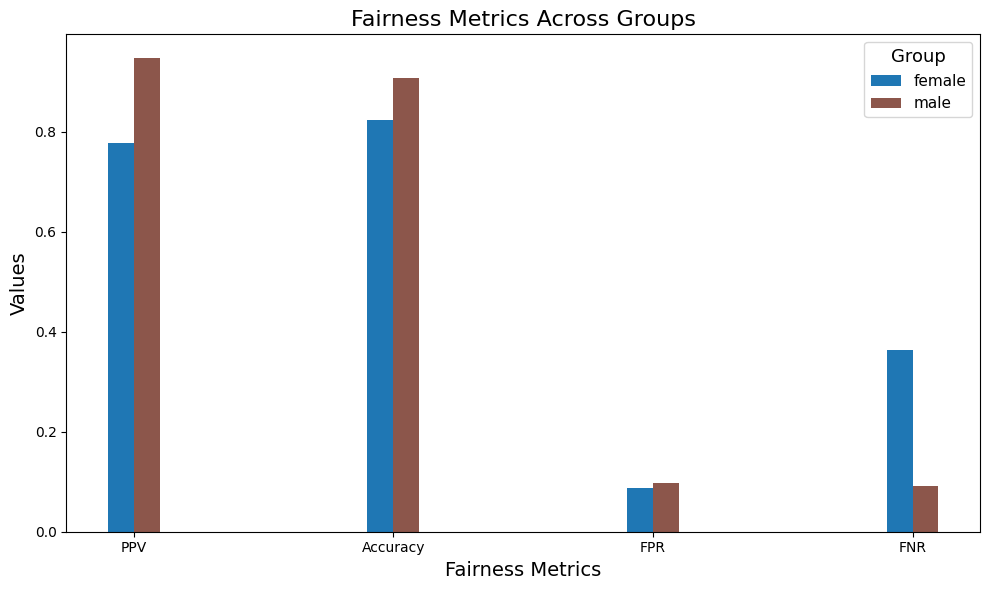

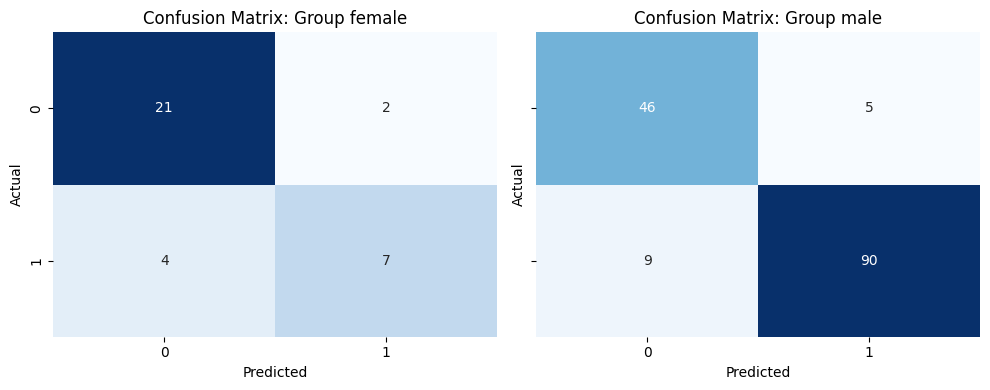




 TRAINING 



Predictive Parity: {('male', 0.874), ('female', 0.689)}
Accuracy Equality: {('female', 0.862), ('male', 0.852)}
Equalized Odds - FPRs: {('female', 0.117), ('male', 0.213)}
Equalized Odds - FNRs: {('male', 0.109), ('female', 0.205)}


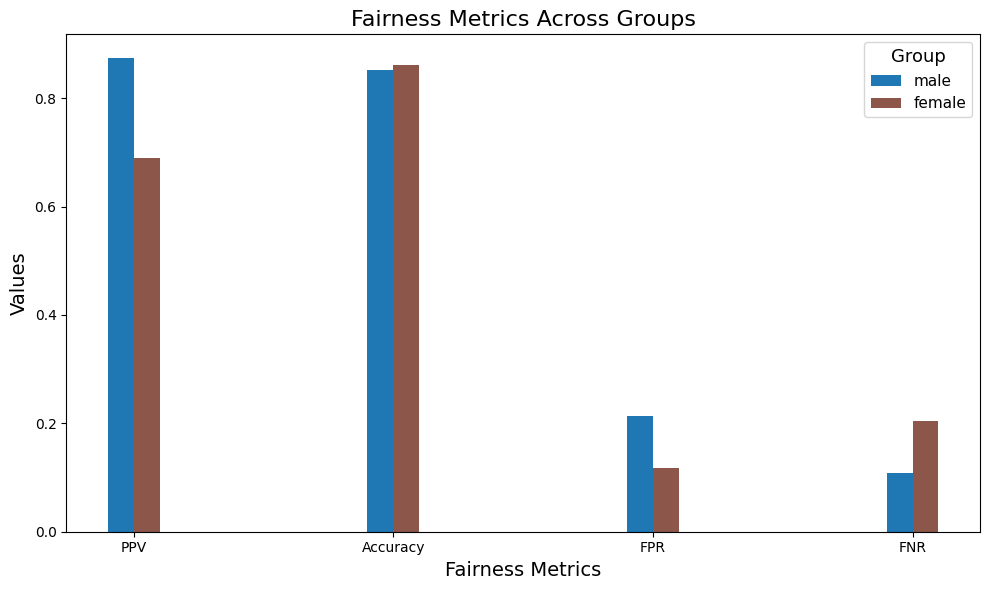

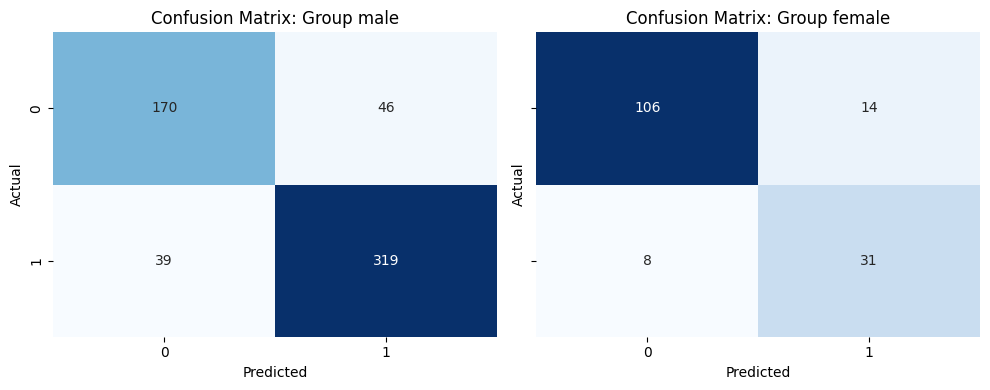

In [34]:
# scaling + logistic regression
def quick_fairness_check(make_model, X, y, train = False, test_size = 0.2):
    
    model = make_model()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    model.fit(X_train, y_train)

    print('TEST \n\n')
    y_test_scores = model.predict_proba(X_test)[:, 1] 
    groups_test = get_sex_groups(X_test)
    fairness_report(y_test, y_test_scores, groups_test)

    if train: 
        # look at the train as well 
        print('\n\n\n TRAINING \n\n\n')
        y_train_scores = model.predict_proba(X_train)[:, 1] 
        groups_train = get_sex_groups(X_train)
        fairness_report(y_train, y_train_scores, groups_train)
    return 

make_model = make_scalar_logistic
quick_fairness_check(make_model, X_oh, y, train = True)

 <a id='transferanal'></a>

# Section 8: Transfer Analysis

In [35]:
df, cledf = fetch_split_datasets_cleaned()

shapes after preprocessing but before combination analysis
df: (917, 12)
cledf: (303, 14) 


Updated shapes after combination analysis
df: (614, 12)
cledf: (303, 12)


FOR UPSTREAM: Male : 343 Sick, 175 Healthy (66.2%) vs Female : 25 sick, 71 healthy (26.0%)

FOR DOWNSTREAM: Male : 114 Sick, 92 Healthy (55.3%) vs Female : 25 sick, 72 healthy (25.8%)


 <a id='individualtraining'></a>

### A. TRAINING INDIVIDUALLY ON DF AND CLEDF


CLEVELAND
TEST 


Predictive Parity: {('female', 0.333), ('male', 0.729)}
Accuracy Equality: {('male', 0.727), ('female', 0.735)}
Equalized Odds - FPRs: {('female', 0.276), ('male', 0.31)}
Equalized Odds - FNRs: {('male', 0.239), ('female', 0.2)}


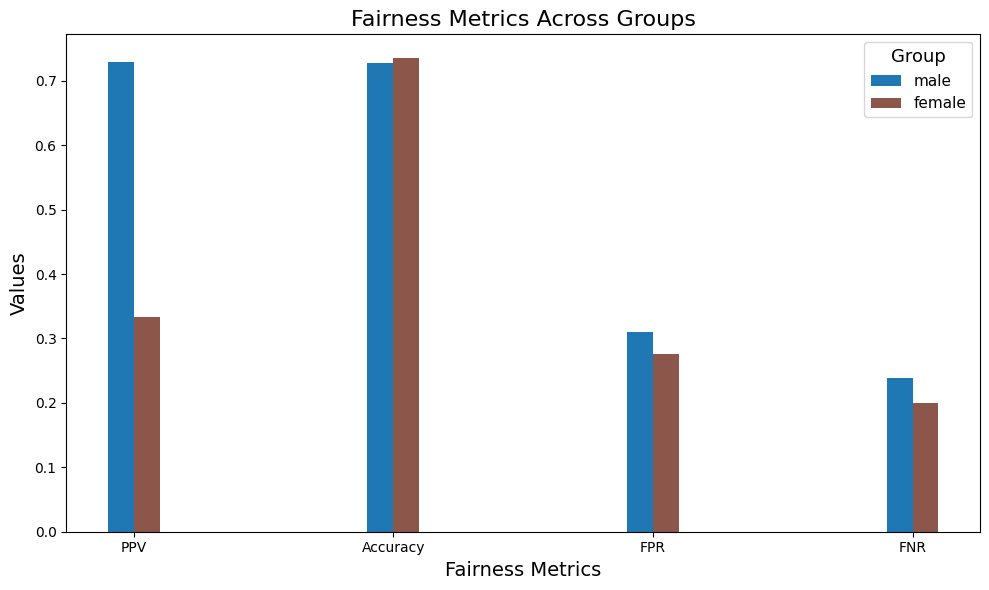

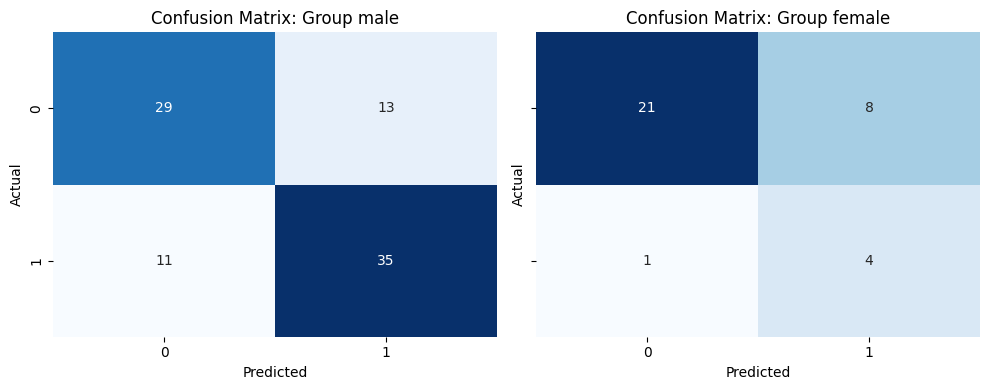


OTHERS
TEST 


Predictive Parity: {('female', 0.538), ('male', 0.944)}
Accuracy Equality: {('male', 0.933), ('female', 0.789)}
Equalized Odds - FPRs: {('female', 0.207), ('male', 0.121)}
Equalized Odds - FNRs: {('male', 0.042), ('female', 0.222)}


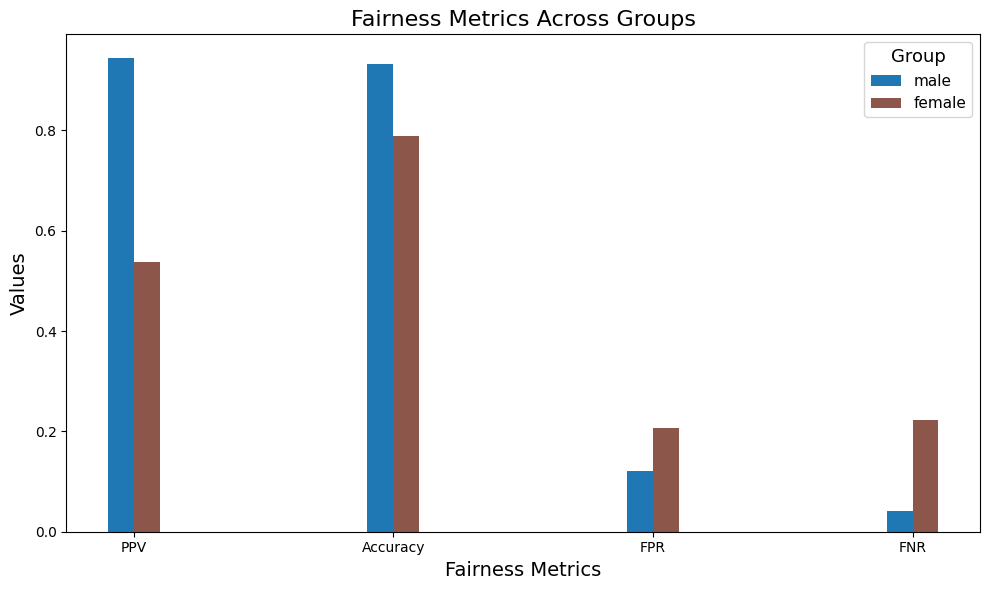

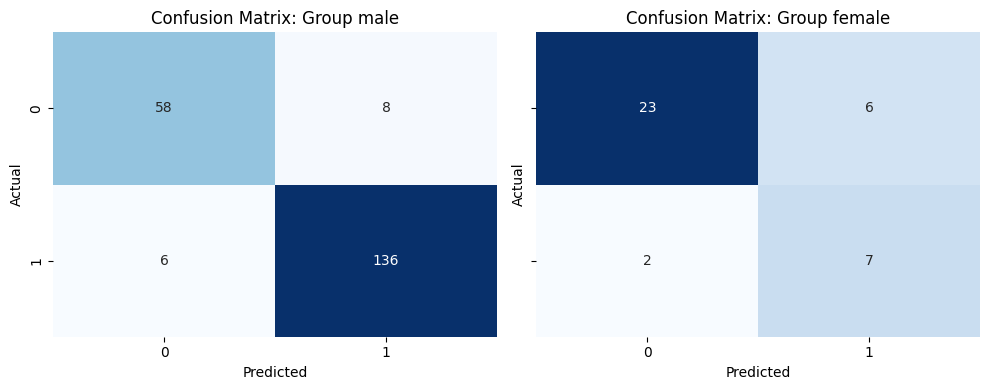

In [36]:
def xy_onehot_from_df(thisdf):
    rawX=thisdf.drop('target',axis=1)
    y = thisdf['target']
    X_oh = onehot_encode_nominals(rawX, nominal_columns, drop_first=False)
    return X_oh, y
    
make_model = make_scalar_logistic
TEST_SIZE = 0.4
    
    
print('\nCLEVELAND')
X_oh, y = xy_onehot_from_df(cledf)
quick_fairness_check(make_model, X_oh, y, train = False, test_size = TEST_SIZE)

print('\nOTHERS')
X_oh, y = xy_onehot_from_df(df)
quick_fairness_check(make_model, X_oh, y, train = False, test_size = TEST_SIZE)

Realized that high variance within single run, looking at aggregating, also don't always want to have the plots

In [37]:
def calc_fairness_metrics_brief(y_test, y_scores, groups, rounding=3):
    ppvs = predictive_parity(y_test, y_scores, groups)
    fprs, fnrs = equalized_odds(y_test, y_scores, groups)
    acceq = accuracy_equality(y_test, y_scores, groups)
    
    return {
        'PPV': ppvs,
        'FPR': fprs,
        'FNR': fnrs,
        'Accuracy': acceq
    }


def multirun_fairness_analysis(make_model, X, y, train = False, test_size = 0.2, num_runs = 30):
    
    results = []
    for seed in range(num_runs):
        model = make_model()

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
        model.fit(X_train, y_train)

        y_test_scores = model.predict_proba(X_test)[:, 1] 
        groups_test = get_sex_groups(X_test)
        test_metrics = calc_fairness_metrics_brief(y_test, y_test_scores, groups_test)

        y_train_scores = model.predict_proba(X_train)[:, 1] 
        groups_train = get_sex_groups(X_train)
        train_metrics = calc_fairness_metrics_brief(y_train, y_train_scores, groups_train)
        
        results.append({
            'seed': seed,
            'train_metrics': train_metrics,
            'test_metrics': test_metrics
        })
    
    return results


OTHERS


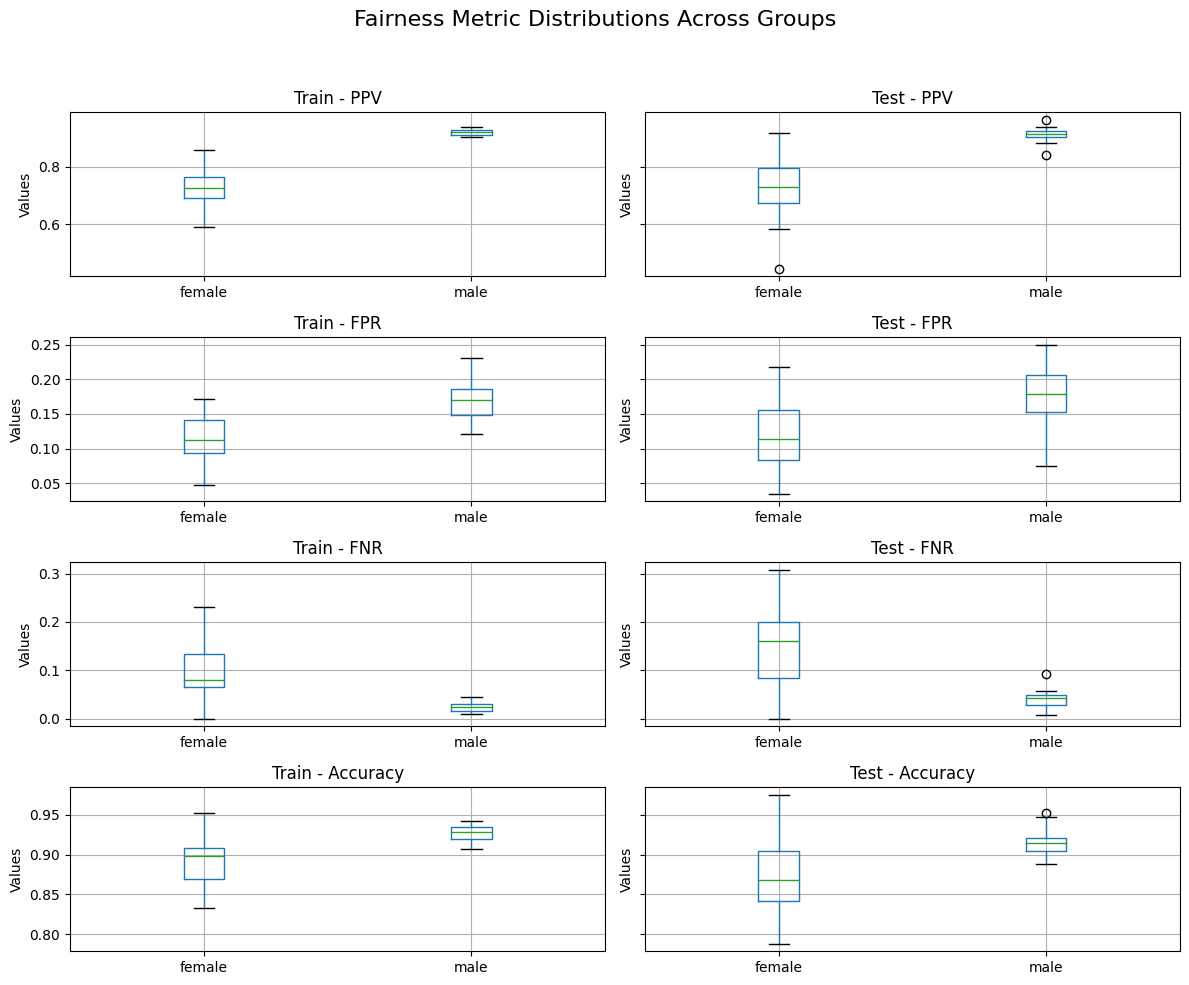

In [38]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_fairness_boxplots(results):
    # Prepare a DataFrame to store all unpacked results
    data = {
        'Phase': [],
        'Metric': [],
        'Group': [],
        'Value': []
    }

    # Unpack results
    for result in results:
        for phase in ['train_metrics', 'test_metrics']:
            for metric, groups in result[phase].items():
                for group, value in groups.items():
                    data['Phase'].append(phase.split('_')[0])  # Train or Test
                    data['Metric'].append(metric)  # PPV, FPR, FNR, Accuracy
                    data['Group'].append(group)  # Male or Female
                    data['Value'].append(value)

    # Convert dictionary to DataFrame
    df = pd.DataFrame(data)

    # Plot setup
    metrics = df['Metric'].unique()
    phases = df['Phase'].unique()
    groups = df['Group'].unique()

    # Create box plots
    fig, axs = plt.subplots(len(metrics), len(phases), figsize=(12, 10), sharey='row')
    
    for i, metric in enumerate(metrics):
        for j, phase in enumerate(phases):
            ax = axs[i, j] if len(metrics) > 1 else axs[j]
            subset = df[(df['Metric'] == metric) & (df['Phase'] == phase)]
            
            # Create boxplot
            subset.boxplot(by='Group', column='Value', ax=ax, grid=True)
            ax.set_title(f'{phase.capitalize()} - {metric}')
            ax.set_xlabel('')
            ax.set_ylabel('Values')

    plt.suptitle('Fairness Metric Distributions Across Groups', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the main title
    plt.show()

    
    
    
    
    
make_model = make_scalar_logistic
TEST_SIZE = 0.4

print('\nOTHERS')
X_oh, y = xy_onehot_from_df(df)
results = multirun_fairness_analysis(make_model, X_oh, y, train = False, test_size = TEST_SIZE, num_runs=30)

plot_fairness_boxplots(results)


and lets look at the cleveland one


CLEVELAND


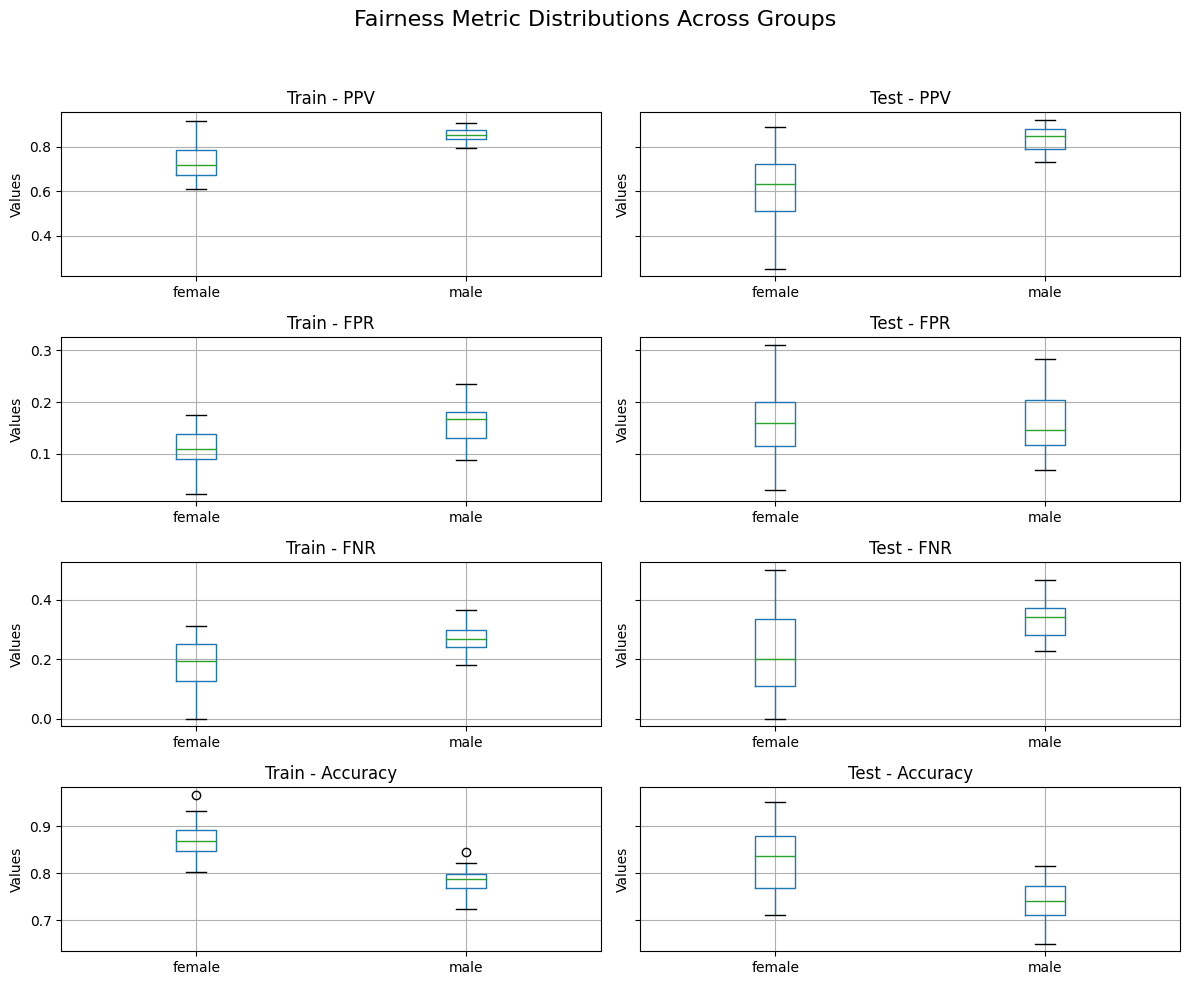

In [39]:

print('\nCLEVELAND')
X_oh, y = xy_onehot_from_df(cledf)
results = multirun_fairness_analysis(make_model, X_oh, y, train = False, test_size = TEST_SIZE, num_runs=30)

plot_fairness_boxplots(results)


 <a id='upstreamdownstream'></a>

### B. TRAINING on upstream, TESTING on downstream, baseline values

this one gives you plots of the metrics for a single one



 Pipeline
Predictive Parity: {('female', 0.714), ('male', 0.921)}
Accuracy Equality: {('female', 0.885), ('male', 0.935)}
Equalized Odds - FPRs: {('male', 0.163), ('female', 0.1)}
Equalized Odds - FNRs: {('female', 0.167), ('male', 0.015)}


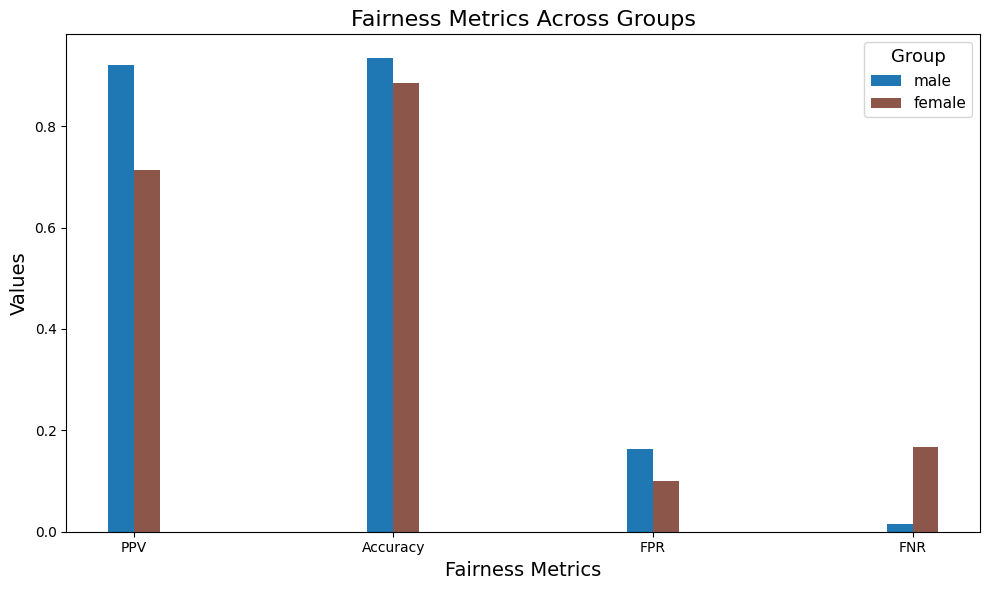

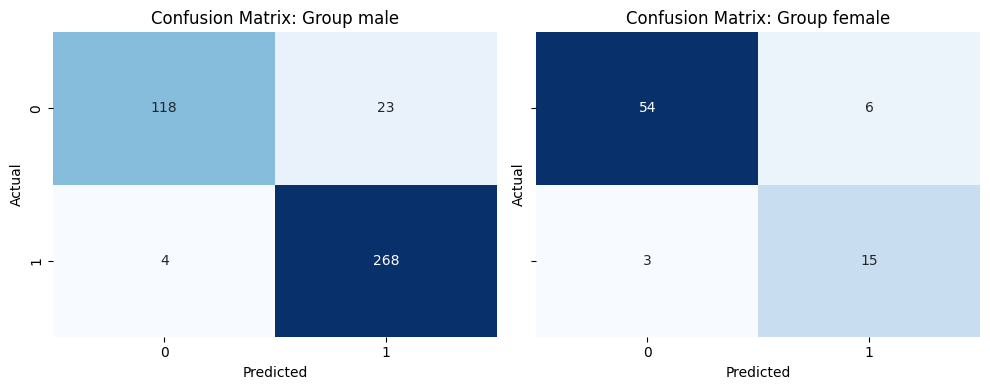

Predictive Parity: {('male', 0.931), ('female', 0.778)}
Accuracy Equality: {('male', 0.914), ('female', 0.889)}
Equalized Odds - FPRs: {('male', 0.147), ('female', 0.182)}
Equalized Odds - FNRs: {('male', 0.056), ('female', 0.0)}


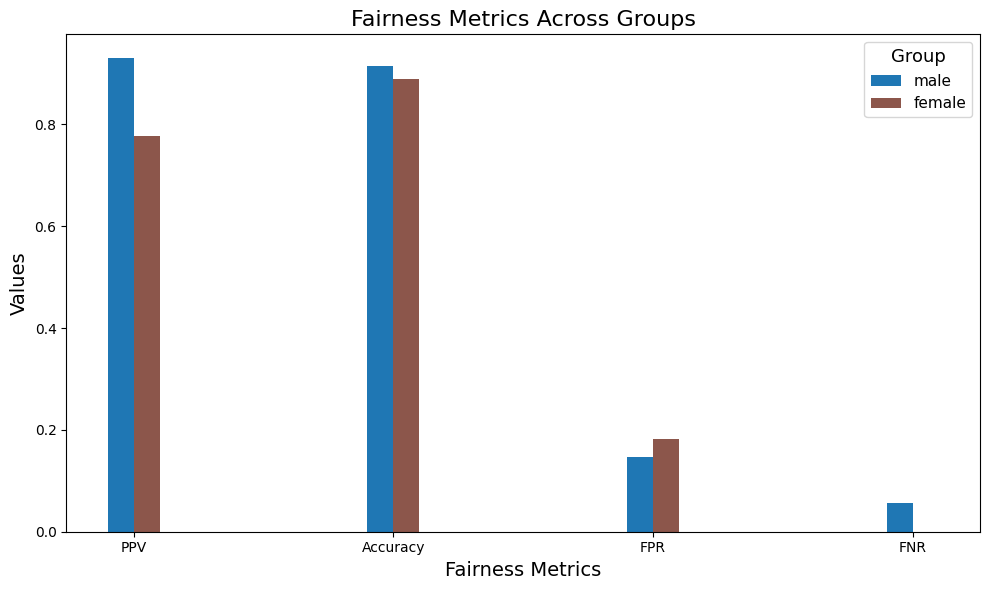

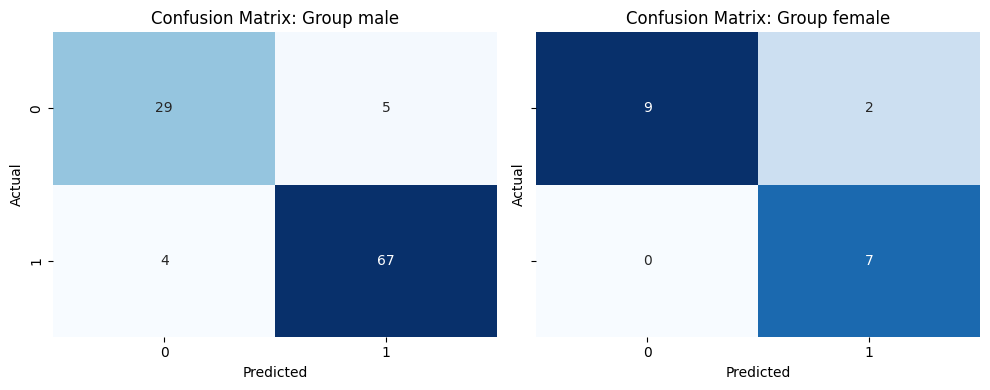

In [40]:
model_types = [make_scalar_logistic]

# train on big dataset, 
for make_model in model_types:
    model = make_model()
    print('\n\n', model.__class__.__name__)
    
    X_oh, y = xy_onehot_from_df(df)
    X_train, X_test, y_train, y_test = train_test_split(X_oh, y, test_size=.2, random_state=4211)

    # fit
    model.fit(X_train, y_train)

    # predict
    y_train_scores = model.predict_proba(X_train)[:, 1]  # Assuming it's a binary classification and you're interested in the positive class
    y_test_scores = model.predict_proba(X_test)[:, 1]  # Assuming it's a binary classification and you're interested in the positive class

    train_groups = get_sex_groups(X_train)
    test_groups = get_sex_groups(X_test)

    fairness_report(y_train, y_train_scores, train_groups)
    fairness_report(y_test, y_test_scores, test_groups)

this one gives you table of the metrics

In [41]:
def fairness_report_new(y_test, y_scores, groups, rounding=3):
    y_test = y_test.reset_index(drop=True)
    y_scores = pd.Series(y_scores).reset_index(drop=True)
    groups = groups.reset_index(drop=True)
    
    
    # Calculate fairness metrics
    ppvs = predictive_parity(y_test, y_scores, groups)
    fprs, fnrs = equalized_odds(y_test, y_scores, groups)
    acceq = accuracy_equality(y_test, y_scores, groups)
    
    # Overall accuracy
    overall_accuracy = accuracy_score(y_test, np.round(y_scores))

    # Create a DataFrame to store fairness metrics and overall accuracy
    report_df = pd.DataFrame({
        'Predictive Parity (Male)': ppvs['male'],  # Assuming 1 represents male
        'Predictive Parity (Female)': ppvs['female'],  # Assuming 0 represents female
        'False Positive Rate (Male)': fprs['male'],
        'False Positive Rate (Female)': fprs['female'],
        'False Negative Rate (Male)': fnrs['male'],
        'False Negative Rate (Female)': fnrs['female'],
        'Accuracy Equality (Male)': acceq['male'],
        'Accuracy Equality (Female)': acceq['female'],
        'Overall Accuracy': overall_accuracy
    }, index=[model.__class__.__name__])

    return report_df

# calculating totals 
def print_malefem_yesno(X_test, y_test):
    tdf = pd.concat([X_test, y_test], axis=1)
    maleyes = tdf.loc[(tdf['sex']==1) & (tdf['target']==1)].shape[0]
    maleno = tdf.loc[(tdf['sex']==1) & (tdf['target']==0)].shape[0]
    femaleyes = tdf.loc[(tdf['sex']==0) & (tdf['target']==1)].shape[0]
    femaleno = tdf.loc[(tdf['sex']==0) & (tdf['target']==0)].shape[0]
    print(f'male yes = {maleyes}')
    print(f'male no = {maleno}')
    print(f'fem yes = {femaleyes}')
    print(f'fem no = {femaleno}')
    

    
model_types = [make_scalar_logistic, make_yoked_random_forest_classifier, make_50_mlp_classifier]


# Initialize an empty list to store report DataFrames for each model
train_report_dfs = []
test_report_dfs = []
trained_models = []

    
X_oh, y = xy_onehot_from_df(df)
X_train, X_test, y_train, y_test = train_test_split(X_oh, y, test_size=.4, random_state=4211)
print_malefem_yesno(X_test, y_test)
    
# train on big dataset, 
for make_model in model_types:
    model = make_model()
    print('\n\n', model.__class__.__name__)

    # fit
    model.fit(X_train, y_train)
    trained_models.append(model)

    # predict
    y_train_scores = model.predict_proba(X_train)[:, 1]  # Assuming it's a binary classification and you're interested in the positive class
    y_test_scores = model.predict_proba(X_test)[:, 1]  # Assuming it's a binary classification and you're interested in the positive class

    train_groups = get_sex_groups(X_train)
    test_groups = get_sex_groups(X_test)

    train_report_df = fairness_report_new(y_train, y_train_scores, train_groups)
    test_report_df = fairness_report_new(y_test, y_test_scores, test_groups)
    
    # Append the report DataFrame to the list
    train_report_dfs.append(train_report_df)
    test_report_dfs.append(test_report_df)
    
# Concatenate report DataFrames into a single DataFrame
train_report = pd.concat(train_report_dfs).round(3)
test_report = pd.concat(test_report_dfs).round(3)

# Print the combined report
test_report

male yes = 145
male no = 62
fem yes = 11
fem no = 28


 Pipeline


 RandomForestClassifier


 MLPClassifier


Predictive Parity (Male)  Predictive Parity (Female)  \
Pipeline                                   0.959                       0.750   
RandomForestClassifier                     0.946                       0.786   
MLPClassifier                              0.929                       0.727   

                        False Positive Rate (Male)  \
Pipeline                                     0.097   
RandomForestClassifier                       0.129   
MLPClassifier                                0.161   

                        False Positive Rate (Female)  \
Pipeline                                       0.107   
RandomForestClassifier                         0.107   
MLPClassifier                                  0.107   

                        False Negative Rate (Male)  \
Pipeline                                     0.041   
RandomForestClassifier                       0.034   
MLPClassifier                                0.103   

                        False Negative Rate (Female)  \
Pipeline                                       0.182   
RandomForestClassifier                         0.000   
MLPClassifier                                  0.273   

                        Accuracy Equality (Male)  Accuracy Equality (Female)  \
Pipeline                                   0.942                       0.872   
RandomForestClassifier                     0.937                       0.923   
MLPClassifier                              0.879                       0.846   

                        Overall Accuracy  
Pipeline                           0.931  
RandomForestClassifier             0.935  
MLPClassifier                      0.874

In [42]:
train_report

Predictive Parity (Male)  Predictive Parity (Female)  \
Pipeline                                   0.910                       0.733   
RandomForestClassifier                     1.000                       1.000   
MLPClassifier                              0.899                       0.733   

                        False Positive Rate (Male)  \
Pipeline                                     0.168   
RandomForestClassifier                       0.000   
MLPClassifier                                0.186   

                        False Positive Rate (Female)  \
Pipeline                                       0.093   
RandomForestClassifier                         0.000   
MLPClassifier                                  0.093   

                        False Negative Rate (Male)  \
Pipeline                                     0.035   
RandomForestClassifier                       0.000   
MLPClassifier                                0.061   

                        False Negative Rate (Female)  \
Pipeline                                       0.214   
RandomForestClassifier                         0.000   
MLPClassifier                                  0.214   

                        Accuracy Equality (Male)  Accuracy Equality (Female)  \
Pipeline                                   0.916                       0.877   
RandomForestClassifier                     1.000                       1.000   
MLPClassifier                              0.894                       0.877   

                        Overall Accuracy  
Pipeline                           0.910  
RandomForestClassifier             1.000  
MLPClassifier                      0.891

Notice random forest is just memorizing. You may think this .93 or .94 is high compared to earlier, although when we rerun on just the other dataset and not the combined, we get much higher accuracy, some .92 from a basic run without even onehot, so it's not crazy that we are getting this. Just shows that there are quite distributions from upstream and downstream which makes this analysis interesting but difficult. 

#### now predict on the cleveland

In [43]:
test_report_dfs = []

# preparing the data 
cleX_oh, cley = xy_onehot_from_df(cledf)

print_malefem_yesno(cleX_oh, cley)

for model in trained_models:

    y_test_scores = model.predict_proba(cleX_oh)[:, 1] 

    test_groups = get_sex_groups(cleX_oh)

    test_report_df = fairness_report_new(cley, y_test_scores, test_groups)
    
    test_report_dfs.append(test_report_df)

    
test_report_df = pd.concat(test_report_dfs).round(3)
test_report_df

male yes = 114
male no = 92
fem yes = 25
fem no = 72


Predictive Parity (Male)  Predictive Parity (Female)  \
Pipeline                                   0.798                       0.636   
RandomForestClassifier                     0.783                       0.500   
MLPClassifier                              0.795                       0.731   

                        False Positive Rate (Male)  \
Pipeline                                     0.228   
RandomForestClassifier                       0.250   
MLPClassifier                                0.196   

                        False Positive Rate (Female)  \
Pipeline                                       0.167   
RandomForestClassifier                         0.278   
MLPClassifier                                  0.097   

                        False Negative Rate (Male)  \
Pipeline                                     0.272   
RandomForestClassifier                       0.272   
MLPClassifier                                0.386   

                        False Negative Rate (Female)  \
Pipeline                                        0.16   
RandomForestClassifier                          0.20   
MLPClassifier                                   0.24   

                        Accuracy Equality (Male)  Accuracy Equality (Female)  \
Pipeline                                   0.748                       0.835   
RandomForestClassifier                     0.738                       0.742   
MLPClassifier                              0.699                       0.866   

                        Overall Accuracy  
Pipeline                           0.776  
RandomForestClassifier             0.736  
MLPClassifier                      0.752

 <a id='finetune'></a>

### C. FineTune on Downstream

One way is to just take end of MLP, another is to allow everything to change but with early stopping. 

For random forest we can add more trees. 

For logistic we can train but with penalize distance from original parameters. 

A simple way could just be to use stacked models, and have a weighting on their outputs proportional to the number of data points, with perhaps an additional weighting to your dataset (which can be chosen in the validation set)
If we use stacked models, we can easily perform for different input types as well. I think this can additionally be justified because the top MLP are not even deep (unless I should've tried like 8,8,8,8,8,8) because we have such few features. So therefore, it is difficult even to do the MLP fine-tuning. 

So what we are indeed targetting is a stacked model. With some learnable validation parameter to control how much of each model is used. Like a voting system. 

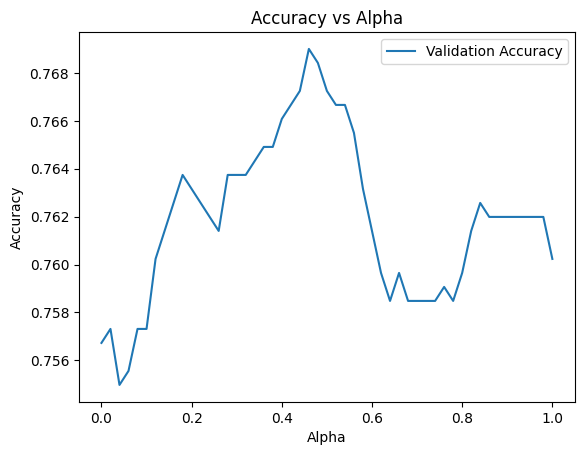

Best alpha: 0.46


In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def make_stacked_model(model, downstream_model, X, y, validation_fraction=0.5, num_seeds=20, alphas=np.linspace(0, 1, 51)):
    """
    Train a stacked model using upstream and downstream models, and find the best alpha
    based on validation accuracy.
    
    Parameters:
    - model: The upstream model
    - downstream_model: The downstream model
    - X: Features
    - y: Target
    - validation_fraction: Fraction of training data to use for validation
    - num_seeds: Number of seeds for averaging
    - alphas: Range of alphas to evaluate
    
    Returns:
    - alpha_star: The best alpha based on validation accuracy
    - mean_accuracies: Mean validation accuracies for each alpha
    """
    
    # Initialize lists to store accuracies
    all_accuracies = []

    for seed in range(num_seeds):
        np.random.seed(seed)
        
        # Split the data
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=validation_fraction, random_state=seed)

        # Train the downstream model
        downstream_model.fit(X_train, y_train)

        # Predict probabilities
        y_val_pred_probs_upstream = model.predict_proba(X_val)[:, 1]
        y_val_pred_probs_downstream = downstream_model.predict_proba(X_val)[:, 1]

        # Initialize list for accuracies of the current seed
        accuracies = []

        for alpha in alphas:
            y_val_pred_combined = alpha * y_val_pred_probs_upstream + (1 - alpha) * y_val_pred_probs_downstream
            overall_accuracy = accuracy_score(y_val, np.round(y_val_pred_combined))
            accuracies.append(overall_accuracy)

        # Append the accuracies for the current seed
        all_accuracies.append(accuracies)

    # Average the accuracies over all seeds
    mean_accuracies = np.mean(all_accuracies, axis=0)

    # Plot the results
    plt.plot(alphas, mean_accuracies, label='Validation Accuracy')
    plt.xlabel('Alpha')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Alpha')
    plt.legend()
    plt.show()

    # Use the best alpha from validation set
    alpha_star = alphas[np.argmax(mean_accuracies)]
    print(f'Best alpha: {alpha_star}')

    return alpha_star, mean_accuracies



# Example usage
TEST_FRACTION_DOWNSTREAM = 0.25
VALIDATION_FRACTION_DOWNSTREAM = 0.25
NUM_SEEDS = 30  # Number of seeds for averaging

model = trained_models[0]
downstream_model = make_scalar_logistic()
X_train_full, X_test, y_train_full, y_test = train_test_split(cleX_oh, cley, test_size=TEST_FRACTION_DOWNSTREAM)#, random_state=22)
alpha_star, mean_accuracies = make_stacked_model(model, downstream_model, X_train_full, y_train_full, validation_fraction = VALIDATION_FRACTION_DOWNSTREAM, num_seeds = NUM_SEEDS)


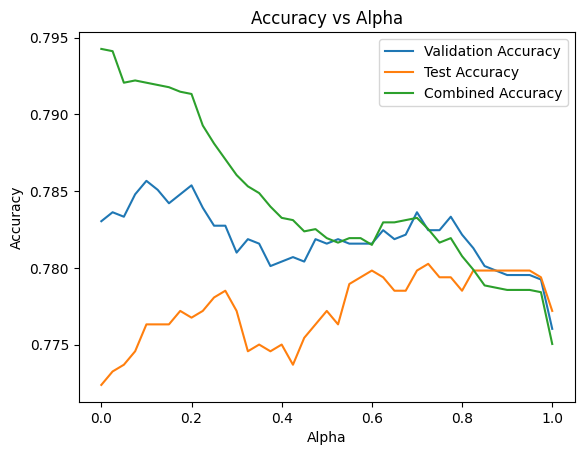

Best alpha: 0.1
Test Accuracy with best alpha: 0.7631578947368421


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Define the upstream and downstream models
model = trained_models[0]
downstream_model = make_scalar_logistic()

# Parameters
TEST_FRACTION_DOWNSTREAM = 0.25
VALIDATION_FRACTION_DOWNSTREAM = 0.5
NUM_SEEDS = 30  # Number of seeds for averaging
alphas = np.linspace(0, 1, 41)  # Range of alphas from 0 to 1 in 41 steps

# Initialize lists to store accuracies
all_accuracies = []
all_test_accuracies = []
all_combo_accuracies = []

for seed in range(NUM_SEEDS):
    np.random.seed(seed)
    
    # Split the data
    X_train_full, X_test, y_train_full, y_test = train_test_split(cleX_oh, cley, test_size=TEST_FRACTION_DOWNSTREAM, random_state=seed)
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=VALIDATION_FRACTION_DOWNSTREAM, random_state=seed)

    # Train the downstream model
    downstream_model.fit(X_train, y_train)

    # Predict probabilities
    y_val_pred_probs_upstream = model.predict_proba(X_val)[:, 1]
    y_val_pred_probs_downstream = downstream_model.predict_proba(X_val)[:, 1]
    y_test_pred_probs_upstream = model.predict_proba(X_test)[:, 1]
    y_test_pred_probs_downstream = downstream_model.predict_proba(X_test)[:, 1]
    y_combo_pred_probs_upstream = model.predict_proba(X_train_full)[:, 1]
    y_combo_pred_probs_downstream = downstream_model.predict_proba(X_train_full)[:, 1]

    # Initialize lists for accuracies of the current seed
    accuracies = []
    test_accuracies = []
    combo_accuracies = []

    for alpha in alphas:
        y_val_pred_combined = alpha * y_val_pred_probs_upstream + (1 - alpha) * y_val_pred_probs_downstream
        overall_accuracy = accuracy_score(y_val, np.round(y_val_pred_combined))
        accuracies.append(overall_accuracy)

        y_test_pred_combined = alpha * y_test_pred_probs_upstream + (1 - alpha) * y_test_pred_probs_downstream
        overall_accuracy = accuracy_score(y_test, np.round(y_test_pred_combined))
        test_accuracies.append(overall_accuracy)

        y_combo_pred_combined = alpha * y_combo_pred_probs_upstream + (1 - alpha) * y_combo_pred_probs_downstream
        overall_accuracy = accuracy_score(y_train_full, np.round(y_combo_pred_combined))
        combo_accuracies.append(overall_accuracy)

    # Append the accuracies for the current seed
    all_accuracies.append(accuracies)
    all_test_accuracies.append(test_accuracies)
    all_combo_accuracies.append(combo_accuracies)

# Average the accuracies over all seeds
mean_accuracies = np.mean(all_accuracies, axis=0)
mean_test_accuracies = np.mean(all_test_accuracies, axis=0)
mean_combo_accuracies = np.mean(all_combo_accuracies, axis=0)

# Plot the results
plt.plot(alphas, mean_accuracies, label='Validation Accuracy')
plt.plot(alphas, mean_test_accuracies, label='Test Accuracy')
plt.plot(alphas, mean_combo_accuracies, label='Combined Accuracy')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Alpha')
plt.legend()
plt.show()

# Use the best alpha from validation set to estimate test accuracy
alpha_star = alphas[np.argmax(mean_accuracies)]
print(f'Best alpha: {alpha_star}')

star_test_preds = alpha_star * y_test_pred_probs_upstream + (1 - alpha_star) * y_test_pred_probs_downstream
test_accuracy = accuracy_score(y_test, np.round(star_test_preds))
print(f'Test Accuracy with best alpha: {test_accuracy}')


 <a id='oldfinetune'></a>

## previous fine-tuning work

previously, we looked at tuning an MLP, but there is a lot of hyperparamm sensitivity here and difficult to consistently outperform the upstream model. 

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_layers=[64, 64], output_dim=1, dropout_rate=0.5):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        for hidden_dim in hidden_layers:
            self.layers.append(nn.Linear(input_dim, hidden_dim))
            self.layers.append(nn.BatchNorm1d(hidden_dim))  # Adding batch normalization
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout_rate))  # Adding dropout
            input_dim = hidden_dim
        self.output_layer = nn.Linear(hidden_layers[-1], output_dim)
        self.output_activation = nn.Sigmoid()
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.output_layer(x)
        x = self.output_activation(x)
        return x
    
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_layers=[50, 100, 50], output_dim=1, dropout_rate=0.5):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        for hidden_dim in hidden_layers:
            self.layers.append(nn.Linear(input_dim, hidden_dim))
            self.layers.append(nn.BatchNorm1d(hidden_dim))  # Adding batch normalization
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout_rate))  # Adding dropout
            input_dim = hidden_dim
        self.output_layer = nn.Linear(hidden_layers[-1], output_dim)
        self.output_activation = nn.Sigmoid()
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.output_layer(x)
        x = self.output_activation(x)
        return x
    
        
def train_model(model, train_loader, epochs=5):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.train()
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            
def freeze_layers(model, freeze_except_last=1):
    """
    Freeze all layers of the model except the last 'freeze_except_last' layers.
    """
    total_layers = len(list(model.parameters()))
    layers_to_freeze = total_layers - freeze_except_last
    count = 0
    for param in model.parameters():
        if count < layers_to_freeze:
            param.requires_grad = False
        count += 1

def fine_tune_model(model, train_loader, val_loader, epochs=5, lr=0.001, verbose=False, patience=2, unfreeze_layers=1):
    # Freeze all but the last few layers specified by unfreeze_layers
    freeze_layers(model, freeze_except_last=unfreeze_layers)
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    model.train()
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        total_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        val_loss, val_accuracy = validate_model(model, val_loader)
        if verbose:
            print(f'Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_loader):.4f}, '
                  f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        # Check for improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Early stopping
        if epochs_no_improve == patience:
            if verbose:
                print("Early stopping triggered.")
            break

    # Optionally return the best validation loss for logging or further decisions
    return best_val_loss

def validate_model(model, val_loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    criterion = nn.BCELoss()
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            total_loss += loss.item()
            predicted = outputs.round()
            correct += (predicted.squeeze() == labels).sum().item()
            total += labels.size(0)
    val_loss = total_loss / len(val_loader)
    val_accuracy = correct / total
    return val_loss, val_accuracy


def evaluate_model(model, test_loader):
    model.eval()
    predictions, labels = [], []
    with torch.no_grad():
        for inputs, label in test_loader:
            outputs = model(inputs.float())
            predicted = outputs.round()
            predictions.extend(predicted.numpy())
            labels.extend(label.numpy())
    
    accuracy = accuracy_score(labels, predictions)
    #print("Accuracy:", accuracy)
    return accuracy
    
    
# Assuming foundation_model is trained and we are ready to evaluate on downstream data before fine-tuning
def evaluate_downstream(foundation_model, downstream_loader):
    foundation_model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for inputs, labels in downstream_loader:
            outputs = foundation_model(inputs)
            predicted = outputs.round()
            predictions.extend(predicted.numpy())
            actuals.extend(labels.numpy())
            
    accuracy = accuracy_score(actuals, predictions)
    #print("Downstream Accuracy Before Fine-tuning:", accuracy)
    return accuracy
    
    
def prepare_data_loaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=64):
    # Convert to tensors
    X_train_tensor = torch.tensor(X_train.values.astype(np.float32))
    y_train_tensor = torch.tensor(y_train.values.astype(np.float32))
    X_val_tensor = torch.tensor(X_val.values.astype(np.float32))
    y_val_tensor = torch.tensor(y_val.values.astype(np.float32))
    X_test_tensor = torch.tensor(X_test.values.astype(np.float32))
    y_test_tensor = torch.tensor(y_test.values.astype(np.float32))

    # Create datasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


In [47]:
# then we can fine-tune on the test (meaning we split the test data into train validation test)
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import copy

def preprocess_data(df):
    X, y = df.drop(['target'], axis=1), df['target']
    X = onehot_encode_nominals(X, ['chest pain type', 'resting ecg', 'ST slope'])
    return X, y


print(np.linspace(.05, .95, 10))

TEST_FRACTION_UPSTREAM = 0.2
TEST_FRACTIONS_DOWNSTREAM = np.linspace(.1, .9, num=4)
VALIDATION_FRACTIONS_DOWNSTREAM = np.linspace(.1, .9, num=5)
#TEST_FRACTION_DOWNSTREAM = 0.5
#VALIDATION_FRACTION_DOWNSTREAM = 0.2 # of the train fraction
NUM_SEEDS = 30
test_fractions = VALIDATION_FRACTIONS_DOWNSTREAM

analysis = {}
for TEST_FRACTION_DOWNSTREAM in TEST_FRACTIONS_DOWNSTREAM: 
    analysis[TEST_FRACTION_DOWNSTREAM] = {}
    
    for VALIDATION_FRACTION_DOWNSTREAM in VALIDATION_FRACTIONS_DOWNSTREAM: 

        print(f'finished {TEST_FRACTION_DOWNSTREAM}')

        # Load and preprocess data
        
        X_upstream, y_upstream = preprocess_data(df)
        X_downstream, y_downstream = preprocess_data(cledf)
        

        # Train the foundation model
        #X_train, X_test, y_train, y_test = train_test_split(X_upstream, y_upstream, test_size=TEST_FRACTION_UPSTREAM, random_state=4211)
        X_train_scaled, scaler = normalize_Xtrain(X_upstream)
        X_train_tensor = torch.tensor(X_train_scaled.values.astype(np.float32))
        y_train_tensor = torch.tensor(y_upstream.values.astype(np.float32))

        # Create DataLoader
        train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)

        # Initialize the model
        input_dim = X_train_scaled.shape[1]
        BASEMODEL = MLP(input_dim)

        # Train the model
        train_model(BASEMODEL, train_loader)


        #print('this first one is actually the upstream (aka training)')
        #upstream_acc = evaluate_downstream(model, train_loader)
        
        # testing this to see if its just a bad model 
        log_model = make_logistic_regression_classifier()
        log_model.fit(X_train_scaled, y_upstream)

        X_downstream_temp = scalar_fit(X_downstream, scaler) # scale appropriately 
        downstream_before_fine_tuning_acc = accuracy_score(y_downstream, log_model.predict(X_downstream_temp))
        print('log accuracy on the full test dataset from foundation ', downstream_before_fine_tuning_acc) #testing on the whole thing
        
        _, _, temp_loader = prepare_data_loaders(X_train_scaled, X_train_scaled, X_train_scaled, X_train_scaled, X_downstream_temp, y_downstream)
        downstream_before_fine_tuning_acc = evaluate_downstream(BASEMODEL, temp_loader)
        print('main model accuracy on the full test dataset from foundation ', downstream_before_fine_tuning_acc) #testing on the whole thing
    
        
        pre_scores, post_scores = [],[]
        for seed in range(NUM_SEEDS):
            model = copy.deepcopy(BASEMODEL)
            
            # Split downstream data for fine-tuning and evaluation
            X_downstream = scalar_fit(X_downstream, scaler) # scale appropriately 
            X_ft_train, X_ft_test, y_ft_train, y_ft_test = train_test_split(X_downstream, y_downstream, test_size=TEST_FRACTION_DOWNSTREAM, random_state = seed)
            X_ft_train, X_ft_val, y_ft_train, y_ft_val = train_test_split(X_ft_train, y_ft_train, test_size=VALIDATION_FRACTION_DOWNSTREAM, random_state = seed)

            #print('\ntrain, val, test shapes')
            #for a in (X_ft_train, y_ft_train, X_ft_val, y_ft_val, X_ft_test, y_ft_test):
            #    print(a.shape)


            # Prepare your dataloaders
            train_loader, val_loader, test_loader = prepare_data_loaders(X_ft_train, y_ft_train, X_ft_val, y_ft_val, X_ft_test, y_ft_test)

            downstream_before_fine_tuning_acc = evaluate_downstream(model, test_loader)
            
            #downstream_before_fine_tuning_acc = accuracy_score(y_downstream, log_model.predict(X_downstream))
            
            # logistic testing 

            # Fine-tune the model (ensure some layers are unfrozen in the MLP definition)
            fine_tune_model(model, train_loader, val_loader, epochs=3, lr=0.001)

            # Evaluate the model
            downstream_fine_tuned_acc = evaluate_model(model, test_loader)

            pre_scores.append(downstream_before_fine_tuning_acc)
            post_scores.append(downstream_fine_tuned_acc)

        analysis[TEST_FRACTION_DOWNSTREAM][VALIDATION_FRACTION_DOWNSTREAM] = (pre_scores, post_scores)

[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]
finished 0.1
log accuracy on the full test dataset from foundation  0.7722772277227723
main model accuracy on the full test dataset from foundation  0.7425742574257426
finished 0.1
log accuracy on the full test dataset from foundation  0.7722772277227723
main model accuracy on the full test dataset from foundation  0.7326732673267327
finished 0.1
log accuracy on the full test dataset from foundation  0.7722772277227723
main model accuracy on the full test dataset from foundation  0.7623762376237624
finished 0.1
log accuracy on the full test dataset from foundation  0.7722772277227723
main model accuracy on the full test dataset from foundation  0.759075907590759
finished 0.1
log accuracy on the full test dataset from foundation  0.7722772277227723
main model accuracy on the full test dataset from foundation  0.759075907590759
finished 0.3666666666666667
log accuracy on the full test dataset from foundation  0.7722772277227723
main mod

This is for test frac =  0.1 




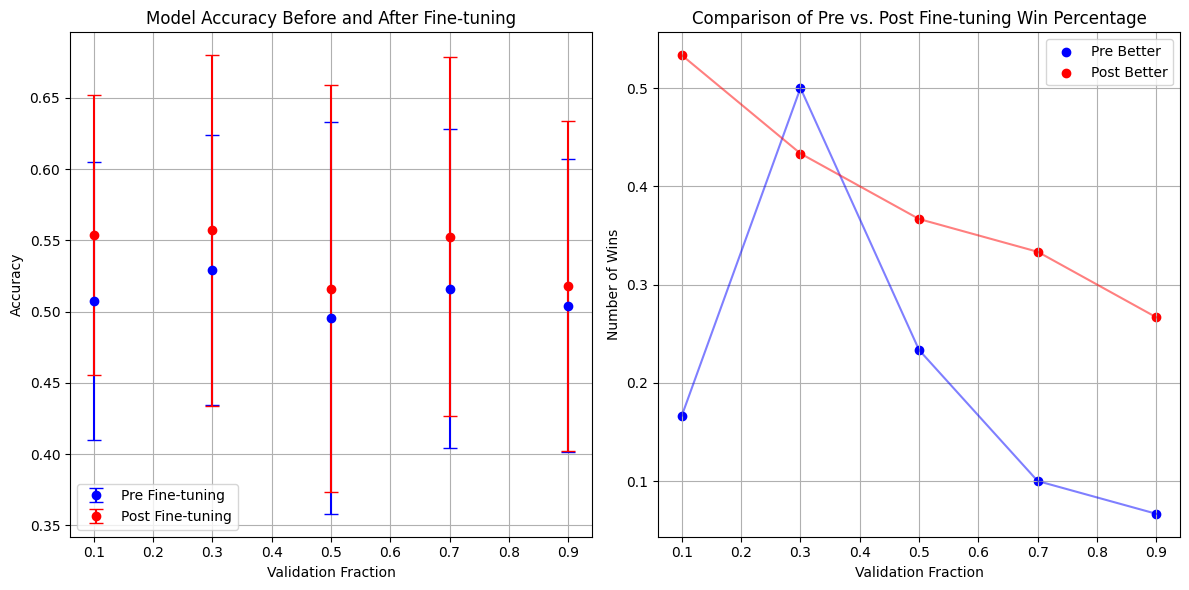

Number of times post-tuning accuracy is better than pre-tuning for each fraction:
Fraction 0.10: 0.5333333333333333 wins vs 0.16666666666666666 losses
Fraction 0.30: 0.43333333333333335 wins vs 0.5 losses
Fraction 0.50: 0.36666666666666664 wins vs 0.23333333333333334 losses
Fraction 0.70: 0.3333333333333333 wins vs 0.1 losses
Fraction 0.90: 0.26666666666666666 wins vs 0.06666666666666667 losses
This is for test frac =  0.3666666666666667 




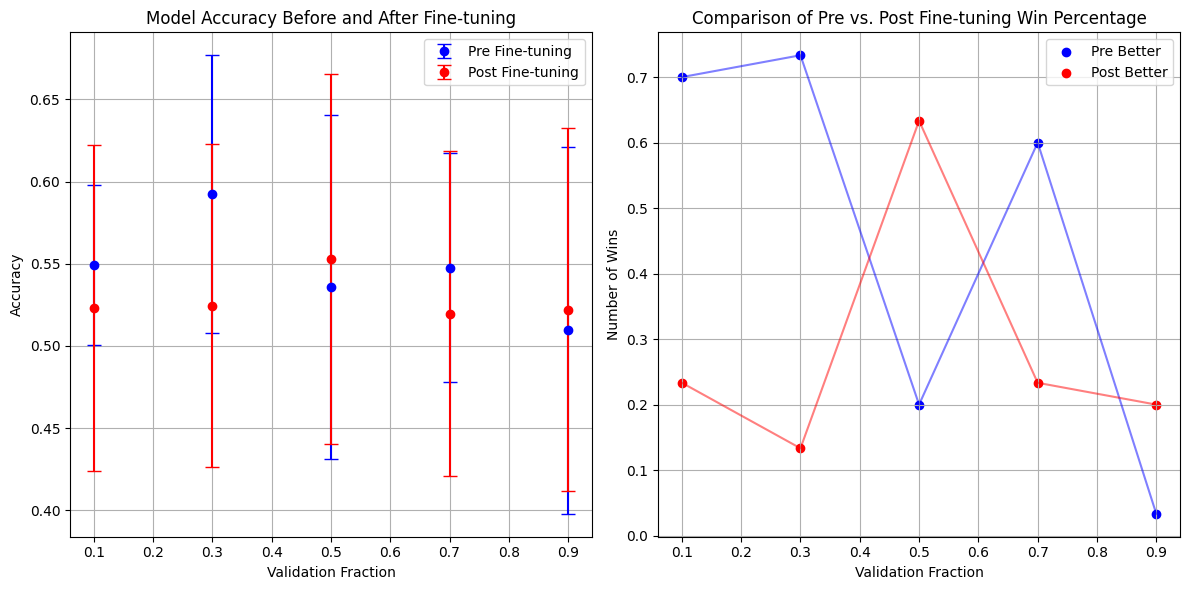

Number of times post-tuning accuracy is better than pre-tuning for each fraction:
Fraction 0.10: 0.23333333333333334 wins vs 0.7 losses
Fraction 0.30: 0.13333333333333333 wins vs 0.7333333333333333 losses
Fraction 0.50: 0.6333333333333333 wins vs 0.2 losses
Fraction 0.70: 0.23333333333333334 wins vs 0.6 losses
Fraction 0.90: 0.2 wins vs 0.03333333333333333 losses
This is for test frac =  0.6333333333333333 




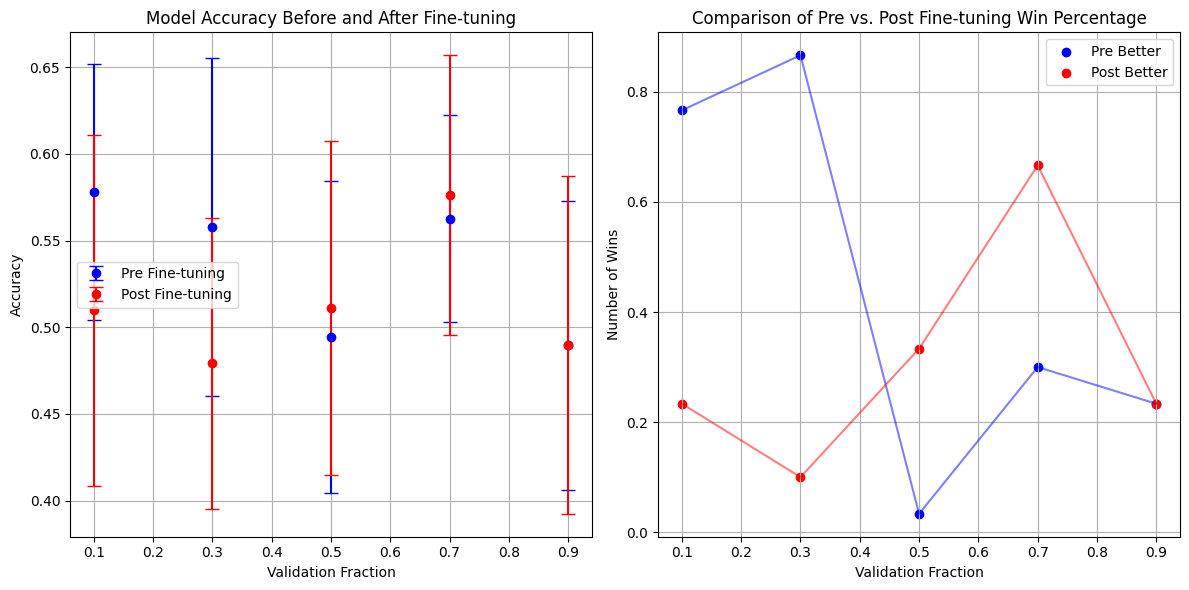

Number of times post-tuning accuracy is better than pre-tuning for each fraction:
Fraction 0.10: 0.23333333333333334 wins vs 0.7666666666666667 losses
Fraction 0.30: 0.1 wins vs 0.8666666666666667 losses
Fraction 0.50: 0.3333333333333333 wins vs 0.03333333333333333 losses
Fraction 0.70: 0.6666666666666666 wins vs 0.3 losses
Fraction 0.90: 0.23333333333333334 wins vs 0.23333333333333334 losses
This is for test frac =  0.9 




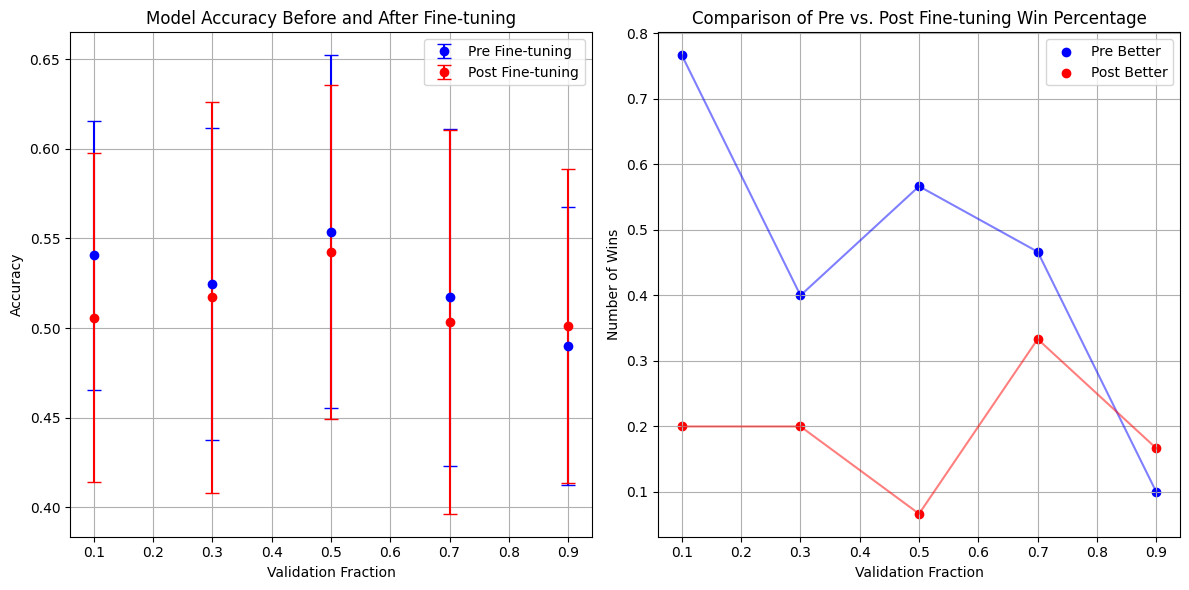

Number of times post-tuning accuracy is better than pre-tuning for each fraction:
Fraction 0.10: 0.2 wins vs 0.7666666666666667 losses
Fraction 0.30: 0.2 wins vs 0.4 losses
Fraction 0.50: 0.06666666666666667 wins vs 0.5666666666666667 losses
Fraction 0.70: 0.3333333333333333 wins vs 0.4666666666666667 losses
Fraction 0.90: 0.16666666666666666 wins vs 0.1 losses


In [48]:
import matplotlib.pyplot as plt
import numpy as np

test_fractions = VALIDATION_FRACTIONS_DOWNSTREAM
for test_frac in TEST_FRACTIONS_DOWNSTREAM:
    print('This is for test frac = ', test_frac, '\n\n')
    results = analysis[test_frac]
    # Extract data from results
    pre_means = []
    post_means = []
    pre_stds = []
    post_stds = []
    num_post_better_than_pre = []
    num_pre_better_than_post = []

    for fraction in VALIDATION_FRACTIONS_DOWNSTREAM:
        pre_scores, post_scores = results[fraction]
        pre_means.append(np.mean(pre_scores))
        post_means.append(np.mean(post_scores))
        pre_stds.append(np.std(pre_scores))
        post_stds.append(np.std(post_scores))
        num_post_better_than_pre.append(sum(p > pt for p, pt in zip(post_scores, pre_scores)) / NUM_SEEDS)
        num_pre_better_than_post.append(sum(p > pt for p, pt in zip(pre_scores, post_scores)) / NUM_SEEDS)

    plt.figure(figsize=(12, 6))

    # Create scatter plots with error bars for accuracies
    plt.subplot(1, 2, 1)
    plt.errorbar(test_fractions, pre_means, yerr=pre_stds, fmt='o', capsize=5, label='Pre Fine-tuning', color='blue')
    plt.errorbar(test_fractions, post_means, yerr=post_stds, fmt='o', capsize=5, label='Post Fine-tuning', color='red')
    plt.xlabel('Validation Fraction')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Before and After Fine-tuning')
    plt.legend()
    plt.grid(True)

    # Create scatter plots for comparison of better counts
    plt.subplot(1, 2, 2)
    plt.scatter(test_fractions, num_pre_better_than_post, color='blue', label='Pre Better')
    plt.plot(test_fractions, num_pre_better_than_post, color='blue', alpha=0.5)  # Connect pre better counts
    plt.scatter(test_fractions, num_post_better_than_pre, color='red', label='Post Better')
    plt.plot(test_fractions, num_post_better_than_pre, color='red', alpha=0.5)  # Connect post better counts
    plt.xlabel('Validation Fraction')
    plt.ylabel('Number of Wins')
    plt.title('Comparison of Pre vs. Post Fine-tuning Win Percentage')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Print the number of sequences where pre-tuning accuracy is better than post-tuning
    print("Number of times post-tuning accuracy is better than pre-tuning for each fraction:")
    for fraction, count, countLs in zip(test_fractions, num_post_better_than_pre, num_pre_better_than_post):
        print(f"Fraction {fraction:.2f}: {count} wins vs {countLs} losses")

 <a id='biasmit'></a>

# Section 9: Bias mitigation

We focus on two methods, fairness through unawareness, and a technique we will call renormalization. This renormalization is similar to equalized odds postprocessing, but for predictive parity. We have two parameters to choose, the threshold for the male and threshold for female. Note that we can always achieve predictive parity this way by selecting 0 or 1, but with a good predictor that achieves some monotonicity of likelihood (with clustering) as we increase logits, we hypothesize you will be able to find quality solutions on the manifold that maintain high accuracy. It would be nice for this to be validated mathematically and empirically. 

In [49]:
# Fairness Unawareness = takes in a model and data, and fits with randomness on the sex attribute 

# renormalization, takes in model and data, fits on the data, and then returns a wrapper for predict that uses the new thresholds? 

In [50]:
def calculate_confusion_components_old(y_test, y_scores, threshold=0.5):
    # Convert probabilities to binary predictions based on the threshold
    y_pred = (y_scores >= threshold).astype(int)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Make sure to return all four components even if some are missing
    tn, fp, fn, tp = 0, 0, 0, 0  # Default values if not otherwise set
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    elif cm.shape == (1, 1):
        if np.unique(y_test).item() == 0 and np.unique(y_pred).item() == 0:
            tn = cm.item()
        else:
            tp = cm.item()
    
    return tp, tn, fp, fn

def calculate_confusion_components(y_test, y_scores, threshold=0.5):
    # Convert probabilities to binary predictions based on the threshold
    y_pred = (y_scores >= threshold).astype(int)
    
    tp = np.sum((y_test == 1) & (y_pred == 1))
    tn = np.sum((y_test == 0) & (y_pred == 0))
    fp = np.sum((y_test == 0) & (y_pred == 1))
    fn = np.sum((y_test == 1) & (y_pred == 0))
    
    return tp, tn, fp, fn




def ppv_formula(tp, fp, tn, fn):
    return tp / (tp + fp) if (tp + fp) > 0 else 0


def fn_formula(tp, fp, tn, fn):
    return fn / (fn + tp) if (fn + tp) > 0 else 0

def group_parity_formula(formula_func, y_test, y_scores, groups, thresholds = None):
    
    # Ensure indices are aligned properly
    y_test = y_test.reset_index(drop=True)
    y_scores = pd.Series(y_scores).reset_index(drop=True)
    groups = groups.reset_index(drop=True)

    # Calculate PPV for each group
    scores = {}
    for group in groups.unique():
        group_mask = (groups == group)
        threshold = thresholds[group] if thresholds is not None else 0.5
        tp_g, tn_g, fp_g, fn_g = calculate_confusion_components(y_test[group_mask], y_scores[group_mask], threshold)
        score = formula_func(tp_g, fp_g, tn_g, fn_g)
        scores[group] = score

    return scores
    

def group_predictive_parity(y_test, y_scores, groups, thresholds = None):
    return group_parity_formula(ppv_formula, y_test, y_scores, groups, thresholds)

def group_false_negatives(y_test, y_scores, groups, thresholds = None):
    return group_parity_formula(fn_formula, y_test, y_scores, groups, thresholds)





def fairness_report_new(y_test, y_scores, groups, rounding=3):
    y_test = y_test.reset_index(drop=True)
    y_scores = pd.Series(y_scores).reset_index(drop=True)
    groups = groups.reset_index(drop=True)
    
    
    # Calculate fairness metrics
    ppvs = group_predictive_parity(y_test, y_scores, groups)
    fnrs = group_false_negatives(y_test, y_scores, groups)
    
    # Overall accuracy
    overall_accuracy = accuracy_score(y_test, np.round(y_scores))

    # Create a DataFrame to store fairness metrics and overall accuracy
    report_df = pd.DataFrame({
        'Predictive Parity (Male)': ppvs['male'],  # Assuming 1 represents male
        'Predictive Parity (Female)': ppvs['female'],  # Assuming 0 represents female
        'False Negative Rate (Male)': fnrs['male'],
        'False Negative Rate (Female)': fnrs['female'],
        'Overall Accuracy': overall_accuracy
    }, index=[model.__class__.__name__])

    return report_df

In [51]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np

class FairnessUnawareness(BaseEstimator, ClassifierMixin):
    def __init__(self, base_model):
        self.base_model = base_model
    
    def fit(self, X, y):
        # Replace the sensitive attribute (e.g., sex) with random values
        X_fair = X.copy()
        X_fair['sex'] = np.random.permutation(X_fair['sex'])
        self.base_model.fit(X_fair, y)
        return self
    
    def predict(self, X):
        X_fair = X.copy()
        X_fair['sex'] = np.random.permutation(X_fair['sex'])
        return self.base_model.predict(X_fair)
    
    def predict_proba(self, X):
        X_fair = X.copy()
        X_fair['sex'] = np.random.permutation(X_fair['sex'])
        return self.base_model.predict_proba(X_fair)

    
class Renormalization(BaseEstimator, ClassifierMixin):
    def __init__(self, base_model, epsilon=0.01, fairness_func = ppv_formula, visualize = True):
        self.base_model = base_model
        self.epsilon = epsilon
        self.threshold_male = None
        self.threshold_female = None
        self.fairness_func = fairness_func
        self.visualize = visualize
    
    def fit(self, X, y):
        self.base_model.fit(X, y)
        probs = self.base_model.predict_proba(X)[:, 1]
        groups = get_sex_groups(X)
        self.threshold_male, self.threshold_female = self.calculate_thresholds(probs, y, groups)
        return self
    
    def predict(self, X):
            probs = self.predict_proba(X)[:, 1]
            return probs > 0.5
    
    def predict_proba(self, X):
        probs = self.base_model.predict_proba(X)[:, 1]
        groups = get_sex_groups(X)
        
        
        reshaped_probs = np.where(groups == 'male',
                                  np.where(probs <= self.threshold_male,
                                           probs / (2 * self.threshold_male),
                                           0.5 + 0.5 * (probs - self.threshold_male) / (1 - self.threshold_male)),
                                  np.where(probs <= self.threshold_female,
                                           probs / (2 * self.threshold_female),
                                           0.5 + 0.5 * (probs - self.threshold_female) / (1 - self.threshold_female)))
        
        return np.column_stack((1 - reshaped_probs, reshaped_probs))
    
    
    def calculate_thresholds(self, probs, y, groups):
        best_threshold_male, best_threshold_female = 0.5, 0.5
        best_accuracy = 0
        valid_thresholds = []

        male_mask = (groups == 'male')
        female_mask = (groups == 'female')
        
        male_probs = probs[male_mask]
        male_y = y[male_mask]
        
        female_probs = probs[female_mask]
        female_y = y[female_mask]
        
        # Precompute PPVs for all thresholds
        male_ppvs = {}
        female_ppvs = {}

        for threshold in np.linspace(0, 1, 101):
            tp, tn, fp, fn = calculate_confusion_components(male_y, male_probs, threshold)
            male_ppvs[threshold] = self.fairness_func(tp, fp, tn, fn)#tp / (tp + fp) if (tp + fp) > 0 else 0

            tp, tn, fp, fn = calculate_confusion_components(female_y, female_probs, threshold)
            female_ppvs[threshold] = self.fairness_func(tp, fp, tn, fn)

        # Search for best threshold combination
        for threshold_male, ppv_male in male_ppvs.items():
            for threshold_female, ppv_female in female_ppvs.items():
                diff = abs(ppv_male - ppv_female)

                if diff <= self.epsilon:
                    overall_predictions = np.where(groups == 'male', probs > threshold_male, probs > threshold_female)
                    accuracy = accuracy_score(y, overall_predictions)
                    valid_thresholds.append((threshold_male, threshold_female, diff, accuracy))

                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_threshold_male = threshold_male
                        best_threshold_female = threshold_female
        
        # Print valid threshold pairs and their accuracies
        #print("Threshold pairs satisfying epsilon condition (Male Threshold, Female Threshold, PP, Accuracy):")
        #for threshold_male, threshold_female, diff, accuracy in valid_thresholds:
        #    print(f"({threshold_male}, {threshold_female}, {diff}, {accuracy})")

        # Visualize the process
        if self.visualize:
            self.plot_ppv_differences(probs, y, groups, valid_thresholds)
        
        return best_threshold_male, best_threshold_female
    

    def plot_ppv_differences(self, probs, y, groups, valid_thresholds):
        male_ppvs = []
        female_ppvs = []
        threshold_pairs = []
        accuracies = []

        for threshold_male, threshold_female, pp, accuracy in valid_thresholds:
            male_preds = probs[groups == 'male'] > threshold_male
            female_preds = probs[groups == 'female'] > threshold_female
            threshold_pairs.append((threshold_male, threshold_female))

            # if doing ppv heat map
            male_ppv = np.mean(y[groups == 'male'][male_preds])
            female_ppv = np.mean(y[groups == 'female'][female_preds])
            male_ppvs.append(male_ppv)
            female_ppvs.append(female_ppv)
            # if doing accuracy heatmap
            accuracies.append(accuracy)

        #diffs = np.abs(np.array(male_ppvs) - np.array(female_ppvs))
        threshold_males, threshold_females = zip(*threshold_pairs)

        plt.figure(figsize=(12, 6))
        plt.scatter(threshold_males, threshold_females, c=accuracies, cmap='viridis', s=50, edgecolor='k')
        plt.colorbar(label='accuracy')
        plt.xlabel('Male Threshold')
        plt.ylabel('Female Threshold')
        plt.title('Accuracy Differences Between Male and Female Eligible Thresholds')
        plt.show()

In [52]:
def single_fairness_reports(model, X, y, train=False, test_size=0.2, **kwargs):
    """
    Perform a fairness check with optional bias mitigation techniques.
    
    Parameters:
    - make_model: premade model
    - X: Features
    - y: Target
    - train: Boolean to indicate whether to check fairness on training data
    - test_size: Fraction of data to use for testing
    - kwargs: Additional parameters for bias mitigation methods
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1001)
    model.fit(X_train, y_train)
    
    #print('TEST \n\n')
    y_test_scores = model.predict_proba(X_test)[:, 1]
    groups_test = get_sex_groups(X_test)
    test_report = fairness_report_new(y_test, y_test_scores, groups_test)
    
    train_report = pd.DataFrame()
    if train:
        # look at the train as well 
        #print('\n\n\n TRAINING \n\n\n')
        y_train_scores = model.predict_proba(X_train)[:, 1]
        groups_train = get_sex_groups(X_train)
        train_report = fairness_report_new(y_train, y_train_scores, groups_train)
    
    return train_report, test_report


def create_normalization_model(make_model, method = 'none', **kwargs):
    base_model = make_model()
    if method == 'fairness_unawareness':
        model = FairnessUnawareness(base_model)
    elif method == 'renormalization':
        epsilon = kwargs.get('epsilon', 0.01)
        fairness_func = kwargs.get('fairness_func', ppv_formula)
        visualize = kwargs.get('visualize', True)
        model = Renormalization(base_model, epsilon, fairness_func, visualize)
    else:
        model = base_model
    return model

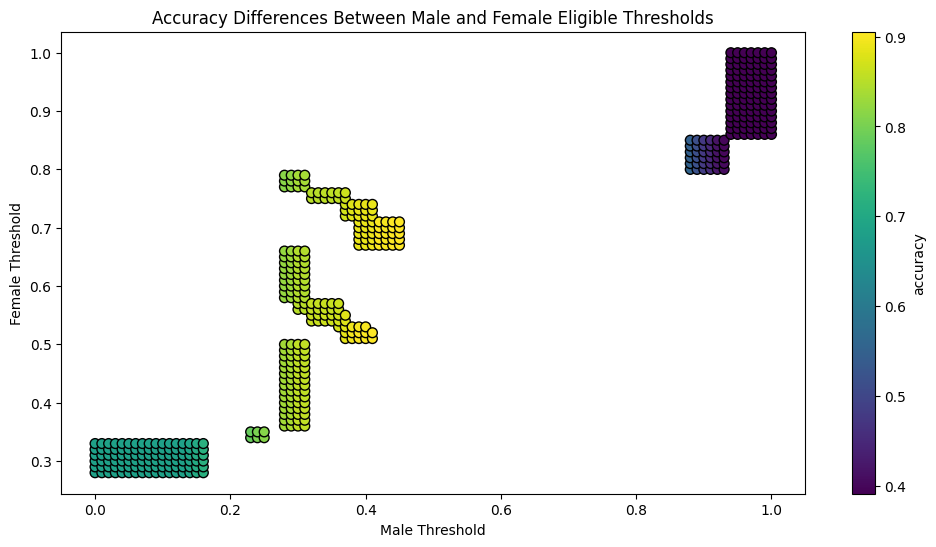

Predictive Parity (Male)  Predictive Parity (Female)  \
Pipeline                                0.905                       0.800   
FairnessUnawareness                     0.909                       0.800   
Renormalization                         0.866                       0.857   

                     False Negative Rate (Male)  False Negative Rate (Female)  \
Pipeline                                  0.017                           0.0   
FairnessUnawareness                       0.029                           0.0   
Renormalization                           0.000                           0.0   

                     Overall Accuracy  
Pipeline                        0.922  
FairnessUnawareness             0.919  
Renormalization                 0.906

In [53]:
test_report_dfs = []
train_report_dfs = []

model_methods = ['none', 'fairness_unawareness', 'renormalization']
make_model = make_scalar_logistic
EPSILON = 0.02
FAIRNESS_FUNC = ppv_formula

for model_method in model_methods:
    
    if model_method == 'renormalization':
        model = create_normalization_model(make_model, model_method, epsilon = EPSILON, fairness_func = FAIRNESS_FUNC)
    else:
        model = create_normalization_model(make_model, model_method)
    
    train_report, test_report = single_fairness_reports(model, X_oh, y, train=True, method=model_method, test_size=0.5)
    
    train_report_dfs.append(train_report)
    test_report_dfs.append(test_report)

    
test_report_df = pd.concat(test_report_dfs).round(3)
train_report_df = pd.concat(train_report_dfs).round(3)


train_report_df

In [54]:
test_report_df

Predictive Parity (Male)  Predictive Parity (Female)  \
Pipeline                                0.901                       0.611   
FairnessUnawareness                     0.910                       0.579   
Renormalization                         0.862                       0.647   

                     False Negative Rate (Male)  False Negative Rate (Female)  \
Pipeline                                  0.024                         0.154   
FairnessUnawareness                       0.036                         0.154   
Renormalization                           0.000                         0.154   

                     Overall Accuracy  
Pipeline                        0.899  
FairnessUnawareness             0.896  
Renormalization                 0.886

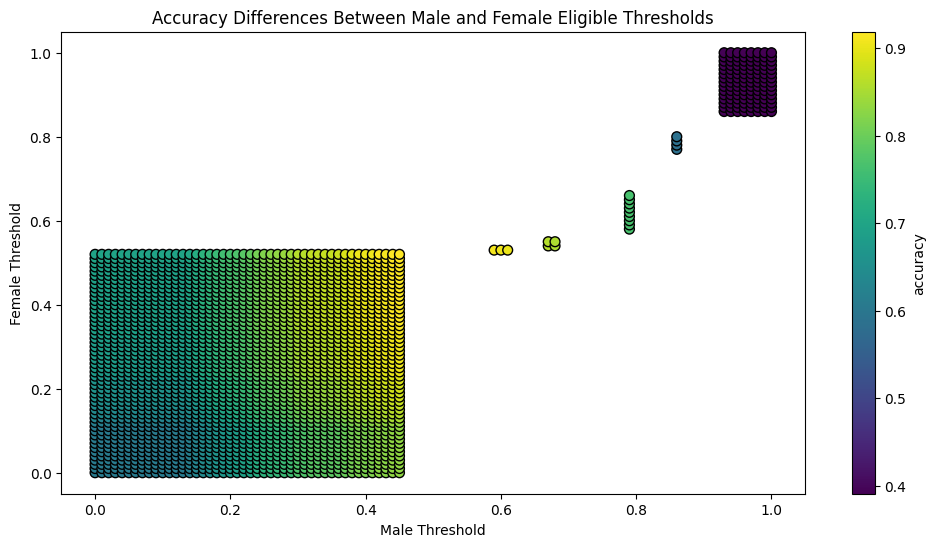

Predictive Parity (Male)  Predictive Parity (Female)  \
Pipeline                                0.905                       0.800   
FairnessUnawareness                     0.914                       0.800   
Renormalization                         0.888                       0.857   

                     False Negative Rate (Male)  False Negative Rate (Female)  \
Pipeline                                  0.017                           0.0   
FairnessUnawareness                       0.023                           0.0   
Renormalization                           0.006                           0.0   

                     Overall Accuracy  
Pipeline                        0.922  
FairnessUnawareness             0.925  
Renormalization                 0.919

In [55]:
test_report_dfs = []
train_report_dfs = []

model_methods = ['none', 'fairness_unawareness', 'renormalization']
make_model = make_scalar_logistic
EPSILON = 0.01
FAIRNESS_FUNC = fn_formula

for model_method in model_methods:
    
    if model_method == 'renormalization':
        model = create_normalization_model(make_model, model_method, epsilon = EPSILON, fairness_func = FAIRNESS_FUNC)
    else:
        model = create_normalization_model(make_model, model_method)
    
    train_report, test_report = single_fairness_reports(model, X_oh, y, train=True, method=model_method, test_size=0.5)
    
    train_report_dfs.append(train_report)
    test_report_dfs.append(test_report)

    
test_report_df = pd.concat(test_report_dfs).round(3)
train_report_df = pd.concat(train_report_dfs).round(3)


train_report_df

In [56]:
test_report_df

Predictive Parity (Male)  Predictive Parity (Female)  \
Pipeline                                0.901                       0.611   
FairnessUnawareness                     0.911                       0.611   
Renormalization                         0.879                       0.647   

                     False Negative Rate (Male)  False Negative Rate (Female)  \
Pipeline                                  0.024                         0.154   
FairnessUnawareness                       0.030                         0.154   
Renormalization                           0.006                         0.154   

                     Overall Accuracy  
Pipeline                        0.899  
FairnessUnawareness             0.902  
Renormalization                 0.896

 <a id='together'></a>

# Section 10: Putting it all Together

We do a massive grid search over such parameters of interest, and then go through the produced table to look for insights. 

This is searched over 4 genres of items

1. Transfer Learning Parameters (Test_fraction, Validation_fraction, Size of Test Data, Size of train data)
2. Bias mitigation techniques (Applied Upstream/Downstream, Fairness Through Unawareness vs Renormalization)
3. Modelling (model type for upstream and downstream)
4. Test Metrics (Train upstream test up, train up test down, train down test down, train up finetune test down :: also PP vs FN or FP or Accuracy (we focus on PP))

Since fairness through unawareness did not have much of an effect, there must be proxies, we will just look at renormalization. So BM = Renormalization, and no BM is just the normal model. 

 <a id='search'></a>

# grid search

In [57]:
class ReferenceModel(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.group_distributions = None

    def fit(self, X, y):
        groups = get_sex_groups(X)
        self.group_distributions = {}
        prenormalized = {}
        
        for group in groups.unique():
            group_mask = (groups == group)
            y_group = y[group_mask]
            prenormalized[group] = y_group.value_counts().to_dict()
            distribution = y_group.value_counts(normalize=True).to_dict()
            self.group_distributions[group] = distribution
        
        #print(prenormalized)
        #print(self.group_distributions)
        return self

    def predict(self, X):
        groups = get_sex_groups(X)
        predictions = np.zeros(groups.shape[0])
        
        for i, group in enumerate(groups):
            distribution = self.group_distributions[group]
            predictions[i] = np.random.choice(list(distribution.keys()), p=list(distribution.values()))
        
        return predictions

    # currently just random within
    def predict_proba(self, X):
        groups = get_sex_groups(X)
        probs = np.zeros((groups.shape[0], 2))
        
        for i, group in enumerate(groups):
            distribution = self.group_distributions[group]
            prob = np.random.rand()
            if prob < distribution.get(1, 0):
                probs[i, 1] = 0.5 + 0.5 * np.random.rand()  # Random value in [0.5, 1)
                probs[i, 0] = 1 - probs[i, 1]
            else:
                probs[i, 1] = 0.5 * np.random.rand()  # Random value in [0, 0.5)
                probs[i, 0] = 1 - probs[i, 1]
        
        return probs
    
class MajorityModel(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.group_majorities = None

    def fit(self, X, y):
        groups = get_sex_groups(X)
        self.group_majorities = {}
        
        for group in groups.unique():
            group_mask = (groups == group)
            y_group = y[group_mask]
            majority_class = y_group.mode()[0]
            self.group_majorities[group] = majority_class
        
        return self

    def predict(self, X):
        groups = get_sex_groups(X)
        predictions = np.zeros(groups.shape[0])
        
        for i, group in enumerate(groups):
            predictions[i] = self.group_majorities[group]
        
        return predictions

    def predict_proba(self, X):
        groups = get_sex_groups(X)
        probs = np.zeros((groups.shape[0], 2))
        
        for i, group in enumerate(groups):
            majority_class = self.group_majorities[group]
            probs[i, majority_class] = 1.0
            probs[i, 1 - majority_class] = 0.0
        
        return probs


In [58]:
class StackedModel(BaseEstimator, ClassifierMixin):
    def __init__(self, upstream_model, downstream_model, alpha):
        self.upstream_model = upstream_model
        self.downstream_model = downstream_model
        self.alpha = alpha

    def fit(self, X, y):
        # Fit the upstream model
        self.upstream_model.fit(X, y)
        # Fit the downstream model
        self.downstream_model.fit(X, y)
        return self

    def predict(self, X):
        probs = self.predict_proba(X)[:, 1]
        return np.round(probs)

    def predict_proba(self, X):
        probs_upstream = self.upstream_model.predict_proba(X)[:, 1]
        probs_downstream = self.downstream_model.predict_proba(X)[:, 1]
        combined_probs = self.alpha * probs_upstream + (1 - self.alpha) * probs_downstream
        return np.column_stack((1 - combined_probs, combined_probs))

# The function to create the stacked model and return it
def make_cv_stacked_model(upstream_model, make_downstream_model, X, y, validation_fraction=0.5, num_seeds=20, alphas=np.linspace(0, 1, 101)):
    all_accuracies = []

    for seed in range(num_seeds):
        np.random.seed(seed)
        downstream_model = make_downstream_model()
        
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=validation_fraction, random_state=seed)
        downstream_model.fit(X_train, y_train)

        y_val_pred_probs_upstream = upstream_model.predict_proba(X_val)[:, 1]
        y_val_pred_probs_downstream = downstream_model.predict_proba(X_val)[:, 1]

        accuracies = []

        for alpha in alphas:
            y_val_pred_combined = alpha * y_val_pred_probs_upstream + (1 - alpha) * y_val_pred_probs_downstream
            overall_accuracy = accuracy_score(y_val, np.round(y_val_pred_combined))
            accuracies.append(overall_accuracy)

        all_accuracies.append(accuracies)

    mean_accuracies = np.mean(all_accuracies, axis=0)
    alpha_star = alphas[np.argmax(mean_accuracies)]
    #print(f'Best alpha: {alpha_star}')

    downstream_model = make_downstream_model()
    downstream_model.fit(X, y)
    stacked_model = StackedModel(model, downstream_model, alpha_star)

    return stacked_model

In [59]:
def fairness_report_brief(info_params, y_test, y_scores, groups, rounding=3):
    # formatting confirmation
    y_test = y_test.reset_index(drop=True)
    y_scores = pd.Series(y_scores).reset_index(drop=True)
    groups = groups.reset_index(drop=True)
    
    # Calculate fairness metrics
    ppvs = group_predictive_parity(y_test, y_scores, groups)
    fnrs = group_false_negatives(y_test, y_scores, groups)
    overall_accuracy = accuracy_score(y_test, np.round(y_scores))
    

    # Create a DataFrame to store fairness metrics and overall accuracy
    report_df = pd.DataFrame({
        **info_params,
        'PP (m)': ppvs['male'],  # Assuming 1 represents male
        'PP (f)': ppvs['female'],  # Assuming 0 represents female
        'FN (m)': fnrs['male'],
        'FN (f)': fnrs['female'],
        'Accuracy': overall_accuracy
    }, index=[0])

    return report_df

# info params should be a dict
def model_fairness_reports(model, X_train, X_test, y_train, y_test, info_params):
    
    y_test_scores = model.predict_proba(X_test)[:, 1]
    groups_test = get_sex_groups(X_test)
    test_report = fairness_report_brief(info_params, y_test, y_test_scores, groups_test)
    
    y_train_scores = model.predict_proba(X_train)[:, 1]
    groups_train = get_sex_groups(X_train)
    train_report = fairness_report_brief(info_params, y_train, y_train_scores, groups_train)
    
    return train_report, test_report



In [60]:
# hyperparams ... later can be made to be looped 
make_model = make_scalar_logistic
UPSTREAM_TEST_FRAC = 0.25
DOWNSTREAM_TEST_FRAC = 0.67
DOWNSTREAM_VALIDATION_FRAC = 0.25
RANDOM_STATE = 3 #2

EPSILON_PP = 0.02
EPSILON_FN = 0.01

NUM_SEEDS_DOWNSTREAM_VALIDATION = 20
NUM_SEEDS_TOTAL = 3 #30

# because will need to reinstantiate
def create_models():
    raw_model = create_normalization_model(make_model, 'none')
    unaware_model = create_normalization_model(make_model, 'fairness_unawareness')
    pp_model = create_normalization_model(make_model, 'renormalization', epsilon = EPSILON_PP, fairness_func = ppv_formula, visualize = False)
    fn_model = create_normalization_model(make_model, 'renormalization', epsilon = EPSILON_FN, fairness_func = fn_formula, visualize = False)
    ref_model = ReferenceModel()
    maj_model = MajorityModel()
    models = (maj_model, ref_model, raw_model, unaware_model, pp_model, fn_model)
    model_names = ('majority', 'reference', 'raw', 'unaware', f'pp-mitigated-{EPSILON_PP}', f'fn-mitigated-{EPSILON_FN}')
    return zip(models, model_names)


def print_distributions(statement, X, y):
    groups = get_sex_groups(X)
    prenormalized = {}
    for group in groups.unique():
        group_mask = (groups == group)
        y_group = y[group_mask]
        prenormalized[group] = y_group.value_counts().to_dict()
    print(f'{statement} - {prenormalized}')

def average_results(report_dfs):
    combined_df = pd.concat(report_dfs)
    avg_df = combined_df.groupby(['trainset', 'testset', 'model', 'split_fractions', 'mitigation_where', 'migitation']).mean().reset_index()
    return avg_df
          
          
test_report_dfs = []
train_report_dfs = []


for seed in range(NUM_SEEDS_TOTAL):
    print(f'seed = {seed}')
    np.random.seed(seed)
    RANDOM_STATE = seed  # Update the random state for each seed

    # Step 1: Train 2 Foundation models, with and without BM    
    X_upstream, y_upstream = xy_onehot_from_df(df)
    X_train_upstream, X_test_upstream, y_train_upstream, y_test_upstream = train_test_split(X_upstream, y_upstream, test_size=UPSTREAM_TEST_FRAC, random_state=RANDOM_STATE)
    print_distributions('upstream train', X_train_upstream, y_train_upstream)
    print_distributions('upstream test', X_test_upstream, y_test_upstream)
    """
    for model, mitigation_type in create_models():


        info_params = {'trainset': 'up', 'testset': 'up', 'model': 'scalar_log', 'split_fractions': f'{UPSTREAM_TEST_FRAC}, {DOWNSTREAM_TEST_FRAC}, {DOWNSTREAM_VALIDATION_FRAC}',\
                       'mitigation_where': 'up', 'migitation': mitigation_type}
        model.fit(X_train_upstream, y_train_upstream)
        train_report, test_report = model_fairness_reports(model, X_train_upstream, X_test_upstream, y_train_upstream, y_test_upstream, info_params)
        #train_report_dfs.append(train_report)
        #test_report_dfs.append(test_report)

    """


    # Step 2: Train 2 Downstream models, with and without BM
    X_downstream, y_downstream = xy_onehot_from_df(cledf)
    X_train_full_downstream, X_test_downstream, y_train_full_downstream, y_test_downstream= train_test_split(X_downstream, y_downstream, test_size=DOWNSTREAM_TEST_FRAC, random_state=RANDOM_STATE)
    X_train_downstream, X_val_downstream, y_train_downstream, y_val_downstream= train_test_split(X_train_full_downstream, y_train_full_downstream, test_size=DOWNSTREAM_VALIDATION_FRAC, random_state=RANDOM_STATE)

    print('\n')
    print_distributions('downstream train full', X_train_full_downstream, y_train_full_downstream)
    print_distributions('downstream test', X_test_downstream, y_test_downstream)

    print('\n')
    print_distributions('downstream train', X_train_downstream, y_train_downstream)
    print_distributions('downstream val', X_val_downstream, y_val_downstream)

    for model, mitigation_type in create_models():


        info_params = {'trainset': 'down-fulltrain', 'testset': 'down-test', 'model': 'scalar_log', 'split_fractions': f'{UPSTREAM_TEST_FRAC}, {DOWNSTREAM_TEST_FRAC}, {DOWNSTREAM_VALIDATION_FRAC}',\
                       'mitigation_where': 'down', 'migitation': mitigation_type}
        model.fit(X_train_full_downstream, y_train_full_downstream)
        train_report, test_report = model_fairness_reports(model, X_train_full_downstream, X_test_downstream, y_train_full_downstream, y_test_downstream, info_params)
        train_report_dfs.append(train_report)
        test_report_dfs.append(test_report)

    """

    # Step 2.5: Train the actual downstream models, on the train and validation


    for model, mitigation_type in create_models():

        info_params = {'trainset': 'down-train', 'testset': 'down-val', 'model': 'scalar_log', 'split_fractions': f'{UPSTREAM_TEST_FRAC}, {DOWNSTREAM_TEST_FRAC}, {DOWNSTREAM_VALIDATION_FRAC}',\
                       'mitigation_where': 'down', 'migitation': mitigation_type}
        model.fit(X_train_downstream, y_train_downstream)
        train_report, test_report = model_fairness_reports(model, X_train_downstream, X_val_downstream, y_train_downstream, y_val_downstream, info_params)
        #train_report_dfs.append(train_report)
        #test_report_dfs.append(test_report)

    """

    # Step 3: Test on various outcomes
        # A. Upstream on Upstream and Downstream on Downstream for Baselines DONEABOVE
        # B. Upstream on Downstream

    for model, mitigation_type in create_models():


        info_params = {'trainset': 'up', 'testset': 'down-test', 'model': 'scalar_log', 'split_fractions': f'{UPSTREAM_TEST_FRAC}, {DOWNSTREAM_TEST_FRAC}, {DOWNSTREAM_VALIDATION_FRAC}',\
                       'mitigation_where': 'up', 'migitation': mitigation_type}
        model.fit(X_train_upstream, y_train_upstream)
        train_report, test_report = model_fairness_reports(model, X_train_upstream, X_test_downstream, y_train_upstream, y_test_downstream, info_params)
        train_report_dfs.append(train_report)
        test_report_dfs.append(test_report)





        # C. Use fine-tuning strategy, and do the combined on downstream
    for upstream_model, upstream_mitigation_type in create_models():
        upstream_model.fit(X_train_upstream, y_train_upstream)
        make_downstream_model = lambda: create_normalization_model(make_model, 'none')

        downstream_stacked_model = make_cv_stacked_model(upstream_model, make_downstream_model, X_train_full_downstream,\
                                                                              y_train_full_downstream, validation_fraction=DOWNSTREAM_VALIDATION_FRAC, num_seeds=NUM_SEEDS_DOWNSTREAM_VALIDATION)

        info_params = {'trainset': 'finetune', 'testset': 'down-test', 'model': 'scalar_log', 'split_fractions': f'{UPSTREAM_TEST_FRAC}, {DOWNSTREAM_TEST_FRAC}, {DOWNSTREAM_VALIDATION_FRAC}',\
                       'mitigation_where': 'up', 'migitation': upstream_mitigation_type}
        train_report, test_report = model_fairness_reports(downstream_stacked_model, X_train_full_downstream, X_test_downstream, y_train_full_downstream, y_test_downstream, info_params)
        train_report_dfs.append(train_report)
        test_report_dfs.append(test_report)

    # Step 3.5: average these scores over several seeds. 
        # DONE, NOW IT IS IN A LOOP

    # Step 4: Try different models for upstream and downstream (MLP, Tree, Logistic ... different sizes and combos)

    # Step 5: Vary the Transfer Learning parameters

    # Step 6: Look at FP-mitigation vs PPV mitigation DONE ABOVE

    test_report_df = pd.concat(test_report_dfs).round(3)
    train_report_df = pd.concat(train_report_dfs).round(3)

# Step 3.5: Average these scores over several seeds
avg_test_report_df = average_results(test_report_dfs)
avg_train_report_df = average_results(train_report_dfs)

print("\nAverage Train Report:")
avg_train_report_df

seed = 0
upstream train - {'male': {1: 256, 0: 136}, 'female': {0: 49, 1: 19}}
upstream test - {'male': {1: 87, 0: 39}, 'female': {0: 22, 1: 6}}


downstream train full - {'male': {1: 38, 0: 29}, 'female': {0: 26, 1: 6}}
downstream test - {'male': {1: 76, 0: 63}, 'female': {0: 46, 1: 19}}


downstream train - {'male': {1: 30, 0: 23}, 'female': {0: 17, 1: 4}}
downstream val - {'male': {1: 8, 0: 6}, 'female': {0: 9, 1: 2}}
seed = 1
upstream train - {'male': {1: 259, 0: 127}, 'female': {0: 56, 1: 18}}
upstream test - {'male': {1: 84, 0: 48}, 'female': {0: 15, 1: 7}}


downstream train full - {'male': {1: 32, 0: 27}, 'female': {0: 35, 1: 5}}
downstream test - {'male': {1: 82, 0: 65}, 'female': {0: 37, 1: 20}}


downstream train - {'female': {0: 27, 1: 4}, 'male': {1: 25, 0: 18}}
downstream val - {'male': {0: 9, 1: 7}, 'female': {0: 8, 1: 1}}
seed = 2
upstream train - {'male': {1: 258, 0: 127}, 'female': {0: 55, 1: 20}}
upstream test - {'male': {1: 85, 0: 48}, 'female': {0: 16, 1: 5}}


dow

trainset    testset       model   split_fractions mitigation_where  \
0   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
1   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
2   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
3   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
4   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
5   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
6         finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   
7         finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   
8         finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   
9         finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   
10        finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   
11        finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   
12              up  down-test  scalar_log  0.25, 0.67, 0.25               up   
13              up  down-test  scalar_log  0.25, 0.67, 0.25               up   
14              up  down-test  scalar_log  0.25, 0.67, 0.25               up   
15              up  down-test  scalar_log  0.25, 0.67, 0.25               up   
16              up  down-test  scalar_log  0.25, 0.67, 0.25               up   
17              up  down-test  scalar_log  0.25, 0.67, 0.25               up   

           migitation    PP (m)    PP (f)    FN (m)    FN (f)  Accuracy  
0   fn-mitigated-0.01  0.833333  0.773810  0.354715  0.355556  0.774411  
1            majority  0.369846  0.000000  0.333333  1.000000  0.656566  
2   pp-mitigated-0.02  0.708585  0.707143  0.151864  0.244444  0.787879  
3                 raw  0.883705  0.933333  0.461181  0.627778  0.784512  
4           reference  0.525641  0.248016  0.509002  0.727778  0.589226  
5             unaware  0.891794  0.640476  0.469953  0.327778  0.781145  
6   fn-mitigated-0.01  0.878719  0.746032  0.368527  0.177778  0.818182  
7            majority  0.862066  0.857143  0.412387  0.344444  0.797980  
8   pp-mitigated-0.02  0.796013  0.532468  0.335632  0.111111  0.777778  
9                 raw  0.857407  0.714286  0.387716  0.244444  0.801347  
10          reference  0.857054  0.857143  0.433220  0.544444  0.781145  
11            unaware  0.862598  0.746032  0.377299  0.177778  0.808081  
12  fn-mitigated-0.01  0.930555  0.710679  0.046568  0.052729  0.915942  
13           majority  0.664725  0.000000  0.000000  1.000000  0.676087  
14  pp-mitigated-0.02  0.894459  0.879630  0.002579  0.614230  0.905072  
15                raw  0.928514  0.721884  0.025855  0.087914  0.925362  
16          reference  0.662763  0.227564  0.310542  0.776218  0.567391  
17            unaware  0.930268  0.670940  0.033617  0.069396  0.918841

In [61]:
print("\nAverage Train Report:")
avg_train_report_df.sort_values('Accuracy')


Average Train Report:


trainset    testset       model   split_fractions mitigation_where  \
16              up  down-test  scalar_log  0.25, 0.67, 0.25               up   
4   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
1   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
13              up  down-test  scalar_log  0.25, 0.67, 0.25               up   
0   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
8         finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   
10        finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   
5   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
3   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
2   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
7         finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   
9         finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   
11        finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   
6         finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   
14              up  down-test  scalar_log  0.25, 0.67, 0.25               up   
12              up  down-test  scalar_log  0.25, 0.67, 0.25               up   
17              up  down-test  scalar_log  0.25, 0.67, 0.25               up   
15              up  down-test  scalar_log  0.25, 0.67, 0.25               up   

           migitation    PP (m)    PP (f)    FN (m)    FN (f)  Accuracy  
16          reference  0.662763  0.227564  0.310542  0.776218  0.567391  
4           reference  0.525641  0.248016  0.509002  0.727778  0.589226  
1            majority  0.369846  0.000000  0.333333  1.000000  0.656566  
13           majority  0.664725  0.000000  0.000000  1.000000  0.676087  
0   fn-mitigated-0.01  0.833333  0.773810  0.354715  0.355556  0.774411  
8   pp-mitigated-0.02  0.796013  0.532468  0.335632  0.111111  0.777778  
10          reference  0.857054  0.857143  0.433220  0.544444  0.781145  
5             unaware  0.891794  0.640476  0.469953  0.327778  0.781145  
3                 raw  0.883705  0.933333  0.461181  0.627778  0.784512  
2   pp-mitigated-0.02  0.708585  0.707143  0.151864  0.244444  0.787879  
7            majority  0.862066  0.857143  0.412387  0.344444  0.797980  
9                 raw  0.857407  0.714286  0.387716  0.244444  0.801347  
11            unaware  0.862598  0.746032  0.377299  0.177778  0.808081  
6   fn-mitigated-0.01  0.878719  0.746032  0.368527  0.177778  0.818182  
14  pp-mitigated-0.02  0.894459  0.879630  0.002579  0.614230  0.905072  
12  fn-mitigated-0.01  0.930555  0.710679  0.046568  0.052729  0.915942  
17            unaware  0.930268  0.670940  0.033617  0.069396  0.918841  
15                raw  0.928514  0.721884  0.025855  0.087914  0.925362

In [62]:
print("Average Test Report:")
avg_test_report_df.sort_values('Accuracy')

Average Test Report:


trainset    testset       model   split_fractions mitigation_where  \
4   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
1   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
16              up  down-test  scalar_log  0.25, 0.67, 0.25               up   
13              up  down-test  scalar_log  0.25, 0.67, 0.25               up   
5   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
3   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
10        finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   
0   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
6         finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   
7         finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   
9         finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   
11        finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   
14              up  down-test  scalar_log  0.25, 0.67, 0.25               up   
17              up  down-test  scalar_log  0.25, 0.67, 0.25               up   
12              up  down-test  scalar_log  0.25, 0.67, 0.25               up   
8         finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   
15              up  down-test  scalar_log  0.25, 0.67, 0.25               up   
2   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   

           migitation    PP (m)    PP (f)    FN (m)    FN (f)  Accuracy  
4           reference  0.557619  0.426263  0.493557  0.812991  0.542484  
1            majority  0.368195  0.000000  0.333333  1.000000  0.557190  
16          reference  0.609175  0.292088  0.321555  0.815539  0.568627  
13           majority  0.568678  0.000000  0.000000  1.000000  0.602941  
5             unaware  0.943074  0.861514  0.544406  0.443108  0.715686  
3                 raw  0.927581  0.916667  0.465441  0.590810  0.732026  
10          reference  0.914975  0.909091  0.437132  0.491520  0.746732  
0   fn-mitigated-0.01  0.873472  0.916667  0.382052  0.455764  0.753268  
6   fn-mitigated-0.01  0.873486  0.860806  0.398719  0.328739  0.753268  
7            majority  0.916525  0.909091  0.433067  0.425647  0.754902  
9                 raw  0.873969  0.862393  0.394703  0.329532  0.754902  
11            unaware  0.879683  0.865079  0.403105  0.346282  0.754902  
14  pp-mitigated-0.02  0.754041  1.000000  0.199473  0.600125  0.759804  
17            unaware  0.808810  0.596320  0.245004  0.165246  0.759804  
12  fn-mitigated-0.01  0.821323  0.602333  0.261167  0.149373  0.759804  
8   pp-mitigated-0.02  0.854451  0.766869  0.346244  0.230409  0.766340  
15                raw  0.796686  0.667781  0.236874  0.165246  0.772876  
2   pp-mitigated-0.02  0.807796  0.833333  0.190237  0.315414  0.799020

 <a id='tableexplore'></a>

# Exploring the Rankings

In [63]:
def add_difference_columns(df):
    df['PP_diff'] = df['PP (m)'] - df['PP (f)']
    df['FN_diff'] = df['FN (m)'] - df['FN (f)']
    return df

avg_test_report_df = add_difference_columns(avg_test_report_df)
avg_test_report_df.sort_values('PP_diff')

trainset    testset       model   split_fractions mitigation_where  \
14              up  down-test  scalar_log  0.25, 0.67, 0.25               up   
0   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
2   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
10        finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   
7         finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   
3   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
9         finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   
6         finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   
11        finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   
5   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
8         finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   
15              up  down-test  scalar_log  0.25, 0.67, 0.25               up   
4   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
17              up  down-test  scalar_log  0.25, 0.67, 0.25               up   
12              up  down-test  scalar_log  0.25, 0.67, 0.25               up   
16              up  down-test  scalar_log  0.25, 0.67, 0.25               up   
1   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
13              up  down-test  scalar_log  0.25, 0.67, 0.25               up   

           migitation    PP (m)    PP (f)    FN (m)    FN (f)  Accuracy  \
14  pp-mitigated-0.02  0.754041  1.000000  0.199473  0.600125  0.759804   
0   fn-mitigated-0.01  0.873472  0.916667  0.382052  0.455764  0.753268   
2   pp-mitigated-0.02  0.807796  0.833333  0.190237  0.315414  0.799020   
10          reference  0.914975  0.909091  0.437132  0.491520  0.746732   
7            majority  0.916525  0.909091  0.433067  0.425647  0.754902   
3                 raw  0.927581  0.916667  0.465441  0.590810  0.732026   
9                 raw  0.873969  0.862393  0.394703  0.329532  0.754902   
6   fn-mitigated-0.01  0.873486  0.860806  0.398719  0.328739  0.753268   
11            unaware  0.879683  0.865079  0.403105  0.346282  0.754902   
5             unaware  0.943074  0.861514  0.544406  0.443108  0.715686   
8   pp-mitigated-0.02  0.854451  0.766869  0.346244  0.230409  0.766340   
15                raw  0.796686  0.667781  0.236874  0.165246  0.772876   
4           reference  0.557619  0.426263  0.493557  0.812991  0.542484   
17            unaware  0.808810  0.596320  0.245004  0.165246  0.759804   
12  fn-mitigated-0.01  0.821323  0.602333  0.261167  0.149373  0.759804   
16          reference  0.609175  0.292088  0.321555  0.815539  0.568627   
1            majority  0.368195  0.000000  0.333333  1.000000  0.557190   
13           majority  0.568678  0.000000  0.000000  1.000000  0.602941   

     PP_diff   FN_diff  
14 -0.245959 -0.400652  
0  -0.043194 -0.073712  
2  -0.025537 -0.125176  
10  0.005884 -0.054388  
7   0.007434  0.007420  
3   0.010915 -0.125370  
9   0.011575  0.065171  
6   0.012680  0.069981  
11  0.014603  0.056823  
5   0.081560  0.101298  
8   0.087583  0.115834  
15  0.128904  0.071628  
4   0.131357 -0.319434  
17  0.212490  0.079758  
12  0.218990  0.111793  
16  0.317087 -0.493984  
1   0.368195 -0.666667  
13  0.568678 -1.000000

In [64]:
avg_test_report_df.sort_values('FN_diff')

trainset    testset       model   split_fractions mitigation_where  \
13              up  down-test  scalar_log  0.25, 0.67, 0.25               up   
1   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
16              up  down-test  scalar_log  0.25, 0.67, 0.25               up   
14              up  down-test  scalar_log  0.25, 0.67, 0.25               up   
4   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
3   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
2   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
0   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
10        finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   
7         finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   
11        finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   
9         finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   
6         finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   
15              up  down-test  scalar_log  0.25, 0.67, 0.25               up   
17              up  down-test  scalar_log  0.25, 0.67, 0.25               up   
5   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
12              up  down-test  scalar_log  0.25, 0.67, 0.25               up   
8         finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   

           migitation    PP (m)    PP (f)    FN (m)    FN (f)  Accuracy  \
13           majority  0.568678  0.000000  0.000000  1.000000  0.602941   
1            majority  0.368195  0.000000  0.333333  1.000000  0.557190   
16          reference  0.609175  0.292088  0.321555  0.815539  0.568627   
14  pp-mitigated-0.02  0.754041  1.000000  0.199473  0.600125  0.759804   
4           reference  0.557619  0.426263  0.493557  0.812991  0.542484   
3                 raw  0.927581  0.916667  0.465441  0.590810  0.732026   
2   pp-mitigated-0.02  0.807796  0.833333  0.190237  0.315414  0.799020   
0   fn-mitigated-0.01  0.873472  0.916667  0.382052  0.455764  0.753268   
10          reference  0.914975  0.909091  0.437132  0.491520  0.746732   
7            majority  0.916525  0.909091  0.433067  0.425647  0.754902   
11            unaware  0.879683  0.865079  0.403105  0.346282  0.754902   
9                 raw  0.873969  0.862393  0.394703  0.329532  0.754902   
6   fn-mitigated-0.01  0.873486  0.860806  0.398719  0.328739  0.753268   
15                raw  0.796686  0.667781  0.236874  0.165246  0.772876   
17            unaware  0.808810  0.596320  0.245004  0.165246  0.759804   
5             unaware  0.943074  0.861514  0.544406  0.443108  0.715686   
12  fn-mitigated-0.01  0.821323  0.602333  0.261167  0.149373  0.759804   
8   pp-mitigated-0.02  0.854451  0.766869  0.346244  0.230409  0.766340   

     PP_diff   FN_diff  
13  0.568678 -1.000000  
1   0.368195 -0.666667  
16  0.317087 -0.493984  
14 -0.245959 -0.400652  
4   0.131357 -0.319434  
3   0.010915 -0.125370  
2  -0.025537 -0.125176  
0  -0.043194 -0.073712  
10  0.005884 -0.054388  
7   0.007434  0.007420  
11  0.014603  0.056823  
9   0.011575  0.065171  
6   0.012680  0.069981  
15  0.128904  0.071628  
17  0.212490  0.079758  
5   0.081560  0.101298  
12  0.218990  0.111793  
8   0.087583  0.115834

In [65]:
def add_totals(df):
    df['PP_total'] = df['PP (m)'] + df['PP (f)']
    df['FN_total'] = df['FN (m)'] + df['FN (f)']
    return df

avg_test_report_df = add_totals(avg_test_report_df)
avg_test_report_df.sort_values('PP_total')

trainset    testset       model   split_fractions mitigation_where  \
1   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
13              up  down-test  scalar_log  0.25, 0.67, 0.25               up   
16              up  down-test  scalar_log  0.25, 0.67, 0.25               up   
4   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
17              up  down-test  scalar_log  0.25, 0.67, 0.25               up   
12              up  down-test  scalar_log  0.25, 0.67, 0.25               up   
15              up  down-test  scalar_log  0.25, 0.67, 0.25               up   
8         finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   
2   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
6         finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   
9         finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   
11        finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   
14              up  down-test  scalar_log  0.25, 0.67, 0.25               up   
0   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
5   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
10        finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   
7         finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   
3   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   

           migitation    PP (m)    PP (f)    FN (m)    FN (f)  Accuracy  \
1            majority  0.368195  0.000000  0.333333  1.000000  0.557190   
13           majority  0.568678  0.000000  0.000000  1.000000  0.602941   
16          reference  0.609175  0.292088  0.321555  0.815539  0.568627   
4           reference  0.557619  0.426263  0.493557  0.812991  0.542484   
17            unaware  0.808810  0.596320  0.245004  0.165246  0.759804   
12  fn-mitigated-0.01  0.821323  0.602333  0.261167  0.149373  0.759804   
15                raw  0.796686  0.667781  0.236874  0.165246  0.772876   
8   pp-mitigated-0.02  0.854451  0.766869  0.346244  0.230409  0.766340   
2   pp-mitigated-0.02  0.807796  0.833333  0.190237  0.315414  0.799020   
6   fn-mitigated-0.01  0.873486  0.860806  0.398719  0.328739  0.753268   
9                 raw  0.873969  0.862393  0.394703  0.329532  0.754902   
11            unaware  0.879683  0.865079  0.403105  0.346282  0.754902   
14  pp-mitigated-0.02  0.754041  1.000000  0.199473  0.600125  0.759804   
0   fn-mitigated-0.01  0.873472  0.916667  0.382052  0.455764  0.753268   
5             unaware  0.943074  0.861514  0.544406  0.443108  0.715686   
10          reference  0.914975  0.909091  0.437132  0.491520  0.746732   
7            majority  0.916525  0.909091  0.433067  0.425647  0.754902   
3                 raw  0.927581  0.916667  0.465441  0.590810  0.732026   

     PP_diff   FN_diff  PP_total  FN_total  
1   0.368195 -0.666667  0.368195  1.333333  
13  0.568678 -1.000000  0.568678  1.000000  
16  0.317087 -0.493984  0.901263  1.137093  
4   0.131357 -0.319434  0.983882  1.306548  
17  0.212490  0.079758  1.405130  0.410251  
12  0.218990  0.111793  1.423656  0.410540  
15  0.128904  0.071628  1.464467  0.402121  
8   0.087583  0.115834  1.621320  0.576653  
2  -0.025537 -0.125176  1.641130  0.505651  
6   0.012680  0.069981  1.734291  0.727458  
9   0.011575  0.065171  1.736362  0.724235  
11  0.014603  0.056823  1.744762  0.749388  
14 -0.245959 -0.400652  1.754041  0.799598  
0  -0.043194 -0.073712  1.790139  0.837816  
5   0.081560  0.101298  1.804587  0.987514  
10  0.005884 -0.054388  1.824066  0.928653  
7   0.007434  0.007420  1.825616  0.858715  
3   0.010915 -0.125370  1.844248  1.056251

In [66]:
avg_test_report_df.sort_values('FN_total')

trainset    testset       model   split_fractions mitigation_where  \
15              up  down-test  scalar_log  0.25, 0.67, 0.25               up   
17              up  down-test  scalar_log  0.25, 0.67, 0.25               up   
12              up  down-test  scalar_log  0.25, 0.67, 0.25               up   
2   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
8         finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   
9         finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   
6         finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   
11        finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   
14              up  down-test  scalar_log  0.25, 0.67, 0.25               up   
0   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
7         finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   
10        finetune  down-test  scalar_log  0.25, 0.67, 0.25               up   
5   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
13              up  down-test  scalar_log  0.25, 0.67, 0.25               up   
3   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
16              up  down-test  scalar_log  0.25, 0.67, 0.25               up   
4   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
1   down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   

           migitation    PP (m)    PP (f)    FN (m)    FN (f)  Accuracy  \
15                raw  0.796686  0.667781  0.236874  0.165246  0.772876   
17            unaware  0.808810  0.596320  0.245004  0.165246  0.759804   
12  fn-mitigated-0.01  0.821323  0.602333  0.261167  0.149373  0.759804   
2   pp-mitigated-0.02  0.807796  0.833333  0.190237  0.315414  0.799020   
8   pp-mitigated-0.02  0.854451  0.766869  0.346244  0.230409  0.766340   
9                 raw  0.873969  0.862393  0.394703  0.329532  0.754902   
6   fn-mitigated-0.01  0.873486  0.860806  0.398719  0.328739  0.753268   
11            unaware  0.879683  0.865079  0.403105  0.346282  0.754902   
14  pp-mitigated-0.02  0.754041  1.000000  0.199473  0.600125  0.759804   
0   fn-mitigated-0.01  0.873472  0.916667  0.382052  0.455764  0.753268   
7            majority  0.916525  0.909091  0.433067  0.425647  0.754902   
10          reference  0.914975  0.909091  0.437132  0.491520  0.746732   
5             unaware  0.943074  0.861514  0.544406  0.443108  0.715686   
13           majority  0.568678  0.000000  0.000000  1.000000  0.602941   
3                 raw  0.927581  0.916667  0.465441  0.590810  0.732026   
16          reference  0.609175  0.292088  0.321555  0.815539  0.568627   
4           reference  0.557619  0.426263  0.493557  0.812991  0.542484   
1            majority  0.368195  0.000000  0.333333  1.000000  0.557190   

     PP_diff   FN_diff  PP_total  FN_total  
15  0.128904  0.071628  1.464467  0.402121  
17  0.212490  0.079758  1.405130  0.410251  
12  0.218990  0.111793  1.423656  0.410540  
2  -0.025537 -0.125176  1.641130  0.505651  
8   0.087583  0.115834  1.621320  0.576653  
9   0.011575  0.065171  1.736362  0.724235  
6   0.012680  0.069981  1.734291  0.727458  
11  0.014603  0.056823  1.744762  0.749388  
14 -0.245959 -0.400652  1.754041  0.799598  
0  -0.043194 -0.073712  1.790139  0.837816  
7   0.007434  0.007420  1.825616  0.858715  
10  0.005884 -0.054388  1.824066  0.928653  
5   0.081560  0.101298  1.804587  0.987514  
13  0.568678 -1.000000  0.568678  1.000000  
3   0.010915 -0.125370  1.844248  1.056251  
16  0.317087 -0.493984  0.901263  1.137093  
4   0.131357 -0.319434  0.983882  1.306548  
1   0.368195 -0.666667  0.368195  1.333333

In [67]:
avg_test_report_df.columns[-5:]

Index(['Accuracy', 'PP_diff', 'FN_diff', 'PP_total', 'FN_total'], dtype='object')

In [68]:
avg_test_report_df.head()

trainset    testset       model   split_fractions mitigation_where  \
0  down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
1  down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
2  down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
3  down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   
4  down-fulltrain  down-test  scalar_log  0.25, 0.67, 0.25             down   

          migitation    PP (m)    PP (f)    FN (m)    FN (f)  Accuracy  \
0  fn-mitigated-0.01  0.873472  0.916667  0.382052  0.455764  0.753268   
1           majority  0.368195  0.000000  0.333333  1.000000  0.557190   
2  pp-mitigated-0.02  0.807796  0.833333  0.190237  0.315414  0.799020   
3                raw  0.927581  0.916667  0.465441  0.590810  0.732026   
4          reference  0.557619  0.426263  0.493557  0.812991  0.542484   

    PP_diff   FN_diff  PP_total  FN_total  
0 -0.043194 -0.073712  1.790139  0.837816  
1  0.368195 -0.666667  0.368195  1.333333  
2 -0.025537 -0.125176  1.641130  0.505651  
3  0.010915 -0.125370  1.844248  1.056251  
4  0.131357 -0.319434  0.983882  1.306548

 <a id='plotsend'></a>

# Plotting to visualize differences

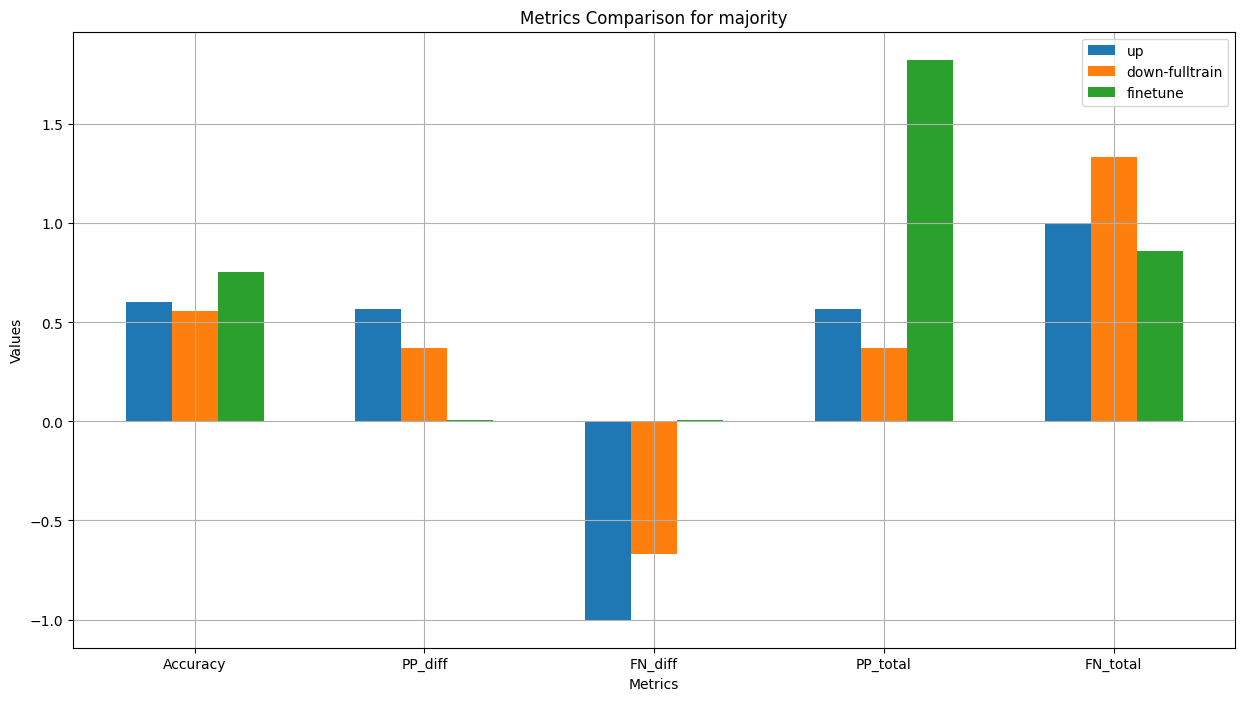

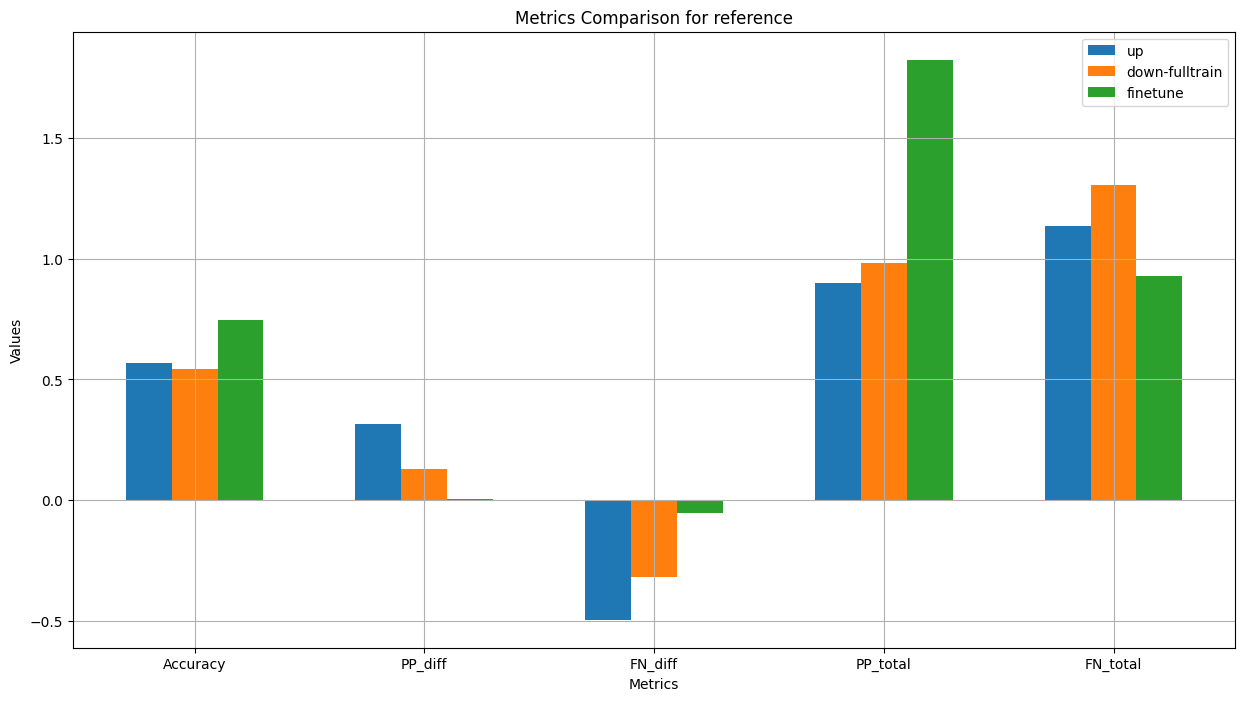

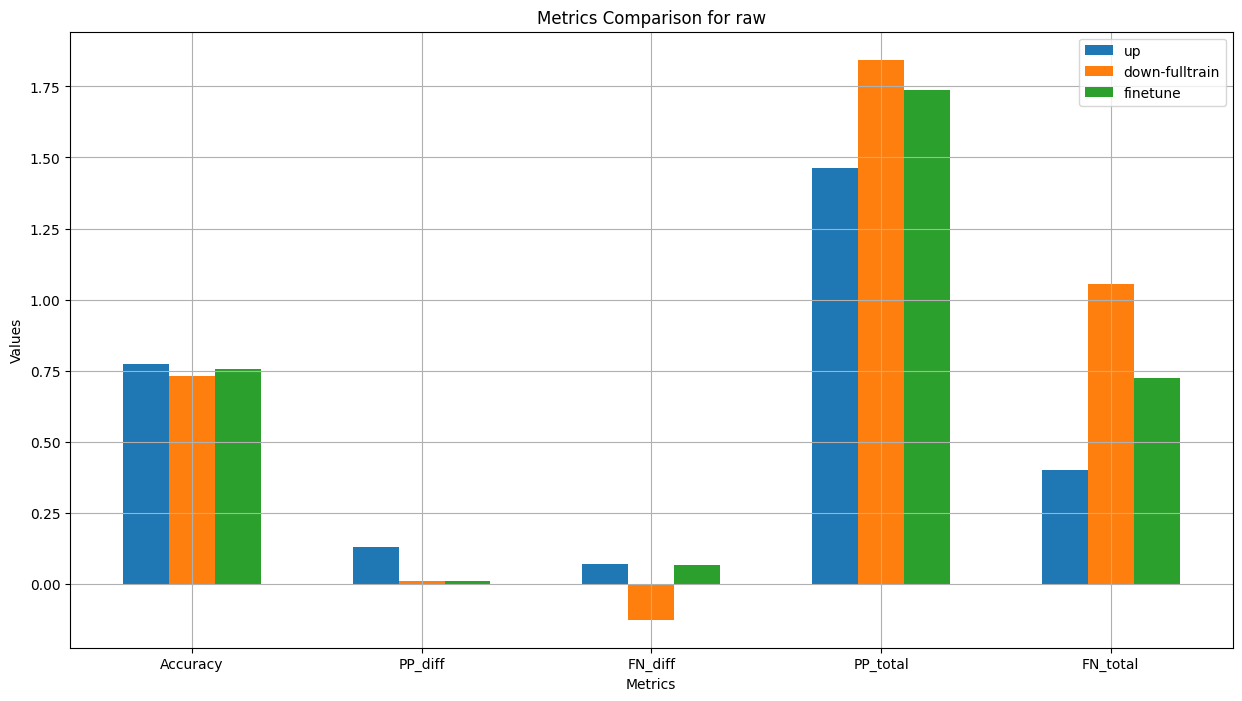

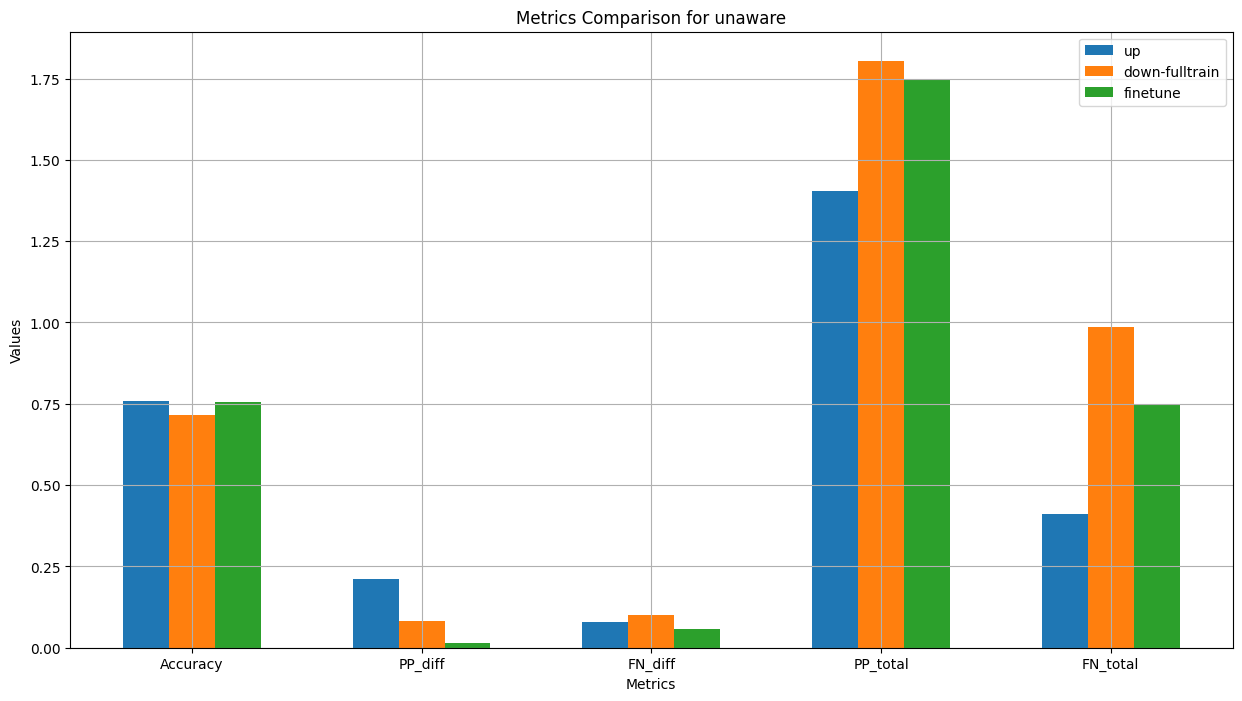

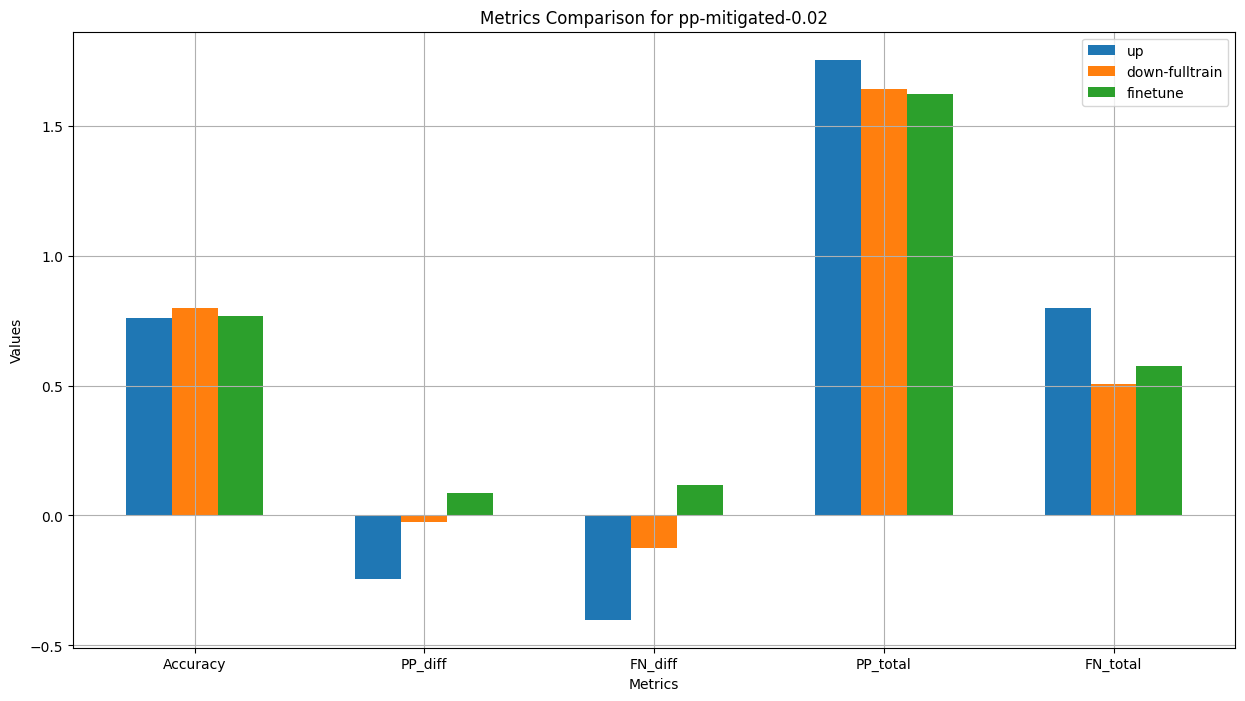

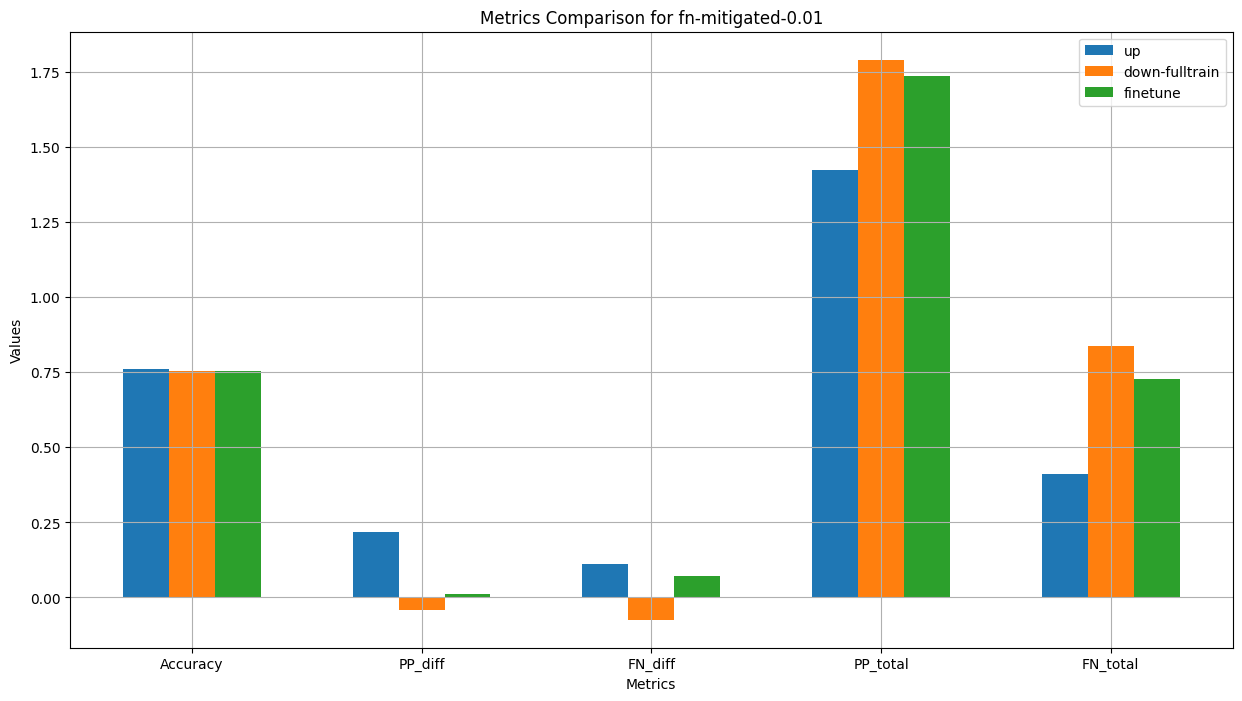

In [69]:
import matplotlib.pyplot as plt

# Function to plot the metrics for each mitigation method
def plot_metrics(df, mitigation_methods):
    metrics = ['Accuracy', 'PP_diff', 'FN_diff', 'PP_total', 'FN_total']
    trainsets = ['up', 'down-fulltrain', 'finetune']
    num_metrics = len(metrics)
    num_trainsets = len(trainsets)

    for mitigation in mitigation_methods:
        # Filter dataframe for the current mitigation method
        df_filtered = df[df['migitation'] == mitigation]

        # Create a new figure
        plt.figure(figsize=(15, 8))
        
        # Generate bar positions
        bar_width = 0.2
        index = np.arange(num_metrics)
        bar_positions = [index + i * bar_width for i in range(num_trainsets)]
        
        # Plot bars for each trainset
        for i, trainset in enumerate(trainsets):
            df_trainset = df_filtered[df_filtered['trainset'] == trainset]
            metric_values = df_trainset[metrics].values.flatten()
            plt.bar(bar_positions[i], metric_values, bar_width, label=f'{trainset}')
        
        # Set plot properties
        plt.xlabel('Metrics')
        plt.ylabel('Values')
        plt.title(f'Metrics Comparison for {mitigation}')
        plt.xticks(index + bar_width, metrics)
        plt.legend()
        plt.grid(True)
        plt.show()

# Define the mitigation methods
mitigation_methods = ['majority', 'reference', 'raw', 'unaware', f'pp-mitigated-{EPSILON_PP}', f'fn-mitigated-{EPSILON_FN}']

# Add total PP and FN columns
avg_test_report_df['PP_total'] = avg_test_report_df['PP (m)'] + avg_test_report_df['PP (f)']
avg_test_report_df['FN_total'] = avg_test_report_df['FN (m)'] + avg_test_report_df['FN (f)']

# Plot the metrics for each mitigation method
plot_metrics(avg_test_report_df, mitigation_methods)
